# ⚠️ Read Me: Foreword

After some tests beforehand that we won't show you for brievety, we opted for a modeling around XGBoostClassifier for:
- its overall remarkable performances,
- its great computational efficiency,
- its capacity to be somewhat explainable.

The purposes of this notebook are to:
- build the best model possible with a data-centric-first approach,
- gain some insight through feature importances and Shapley values,
- fine tune its hyperparameters to increase again the score thanks to randomized search (Alas, Bayesian tuning with Optuna didn't show great results)

> **NOTE**
>
> **This has to be run AFTER `cleaning.ipynb`**.

# Imports and Settings

In [20]:
from itertools import combinations
import json
import os
import sys
from typing import List, Optional

from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, ConfusionMatrixDisplay, f1_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tqdm import tqdm
import xgboost as xgb

In [2]:
# Allow imports from parent directory
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

# Load Baseline Data

In [3]:
%%time
df_short = pd.read_csv("../data/cleaned_df_short.csv", index_col=0)

CPU times: user 1.01 s, sys: 211 ms, total: 1.22 s
Wall time: 1.24 s


In [4]:
df_short.shape

(350207, 20)

# Building Function

This section is meant to build a function with flexible behavior regarding:
- dataset
- columns used

## Whole Analysis Function

In [5]:
def train_and_get_raw_scoreCV(df: pd.DataFrame,
                              cols_to_drop: List[str],
                              estimator: 'estimator') -> dict:

    X = df.copy().drop(columns=cols_to_drop)
    y = X.pop("MIS_Status")

    # Default stratify by y
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

    # Encode target
    lab_enc = LabelEncoder()
    y_train = lab_enc.fit_transform(y_train)
    y_test = lab_enc.transform(y_test)

    # Split kept columns
    kept_set = set(X_train.columns)
    num_cols = list({"Term", "NoEmp", "CreateJob", "RetainedJob", "GrAppv", "SBA_Appv"} & kept_set)
    bin_cols = list({"SameState", "Recession", "NewExist", "Franchise",
                     "LowDoc", "UrbanRural", "RevLineCr"} & kept_set)
    nom_cols = list({"Region", "NAICS"} & kept_set)
    tgt_cols = list({"City", "Bank", "State", "BankState"} & kept_set)

    # Instanciate transformers
    std_scl = StandardScaler()
    ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
                            sparse_output=False)
    ohe_nom = OneHotEncoder(handle_unknown="ignore",
                            sparse_output=False)
    tgt_enc = TargetEncoder(smoothing=1.0)

    # Pipeline
    ## Preprocessing
    preproc = ColumnTransformer(
    transformers = [
        ("num", std_scl, num_cols),
        ("bin", ohe_bin, bin_cols),
        ("nom", ohe_nom, nom_cols),
        ("tgt", tgt_enc, tgt_cols)
    ],
    verbose_feature_names_out = False
    )
    preproc.set_output(transform="pandas")
    ## Append estimator
    model = make_pipeline(preproc, estimator)

    # Train & Score model via cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    cv_results = cross_val_score(model,
                                 X_train, y_train,
                                 cv=kfold,
                                 scoring="f1_macro",
                                 n_jobs=-1)
    raw_score = np.mean(cv_results)
    
    return {
        "model": estimator.__class__.__name__,
        "dropped columns": cols_to_drop,
        "F1 macro": round(raw_score, 6)
    }

# Automate Descending Training:  `XGBClassifier`

In [6]:
xgbc = xgb.XGBClassifier(random_state=42)

## Removal Analysis Tool

In [7]:
def get_removal_score(df: pd.DataFrame,
                      n_feat_to_remove: int,
                      estimator: 'model',
                      baseline: Optional[float] = 0,
                      cols_to_drop: Optional[List[str]] = []) -> float:
    """
    Get the possible new score obtained by removing some features
    TO COMPLETE
    """
    features = df.columns[:-1]
    subsets = list(combinations(features, n_feat_to_remove))
    
    for subset in tqdm(subsets):
        subset = list(subset)
        print(f"Removing {subset}")
        report = train_and_get_raw_scoreCV(df, subset, estimator)
        if report["F1 macro"] > baseline:
            baseline = report["F1 macro"]
            cols_to_drop = report["dropped columns"]
            print(f"==> Baseline Score Beaten With Dropping {cols_to_drop}")
            print(f"==> New Score To Beat: {baseline}")

    return baseline, cols_to_drop

## Without Removal

In [8]:
%%time
baseline, cols_to_drop = get_removal_score(df_short, 0, xgbc)

  0%|                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

Removing []


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.15s/it]

==> Baseline Score Beaten With Dropping []
==> New Score To Beat: 0.947181
CPU times: user 3.42 s, sys: 648 ms, total: 4.07 s
Wall time: 24.2 s


## Removing One Feature... (19 combinations)

In [9]:
%%time
baseline, cols_to_drop = get_removal_score(df_short, 1, xgbc, baseline, cols_to_drop)

  0%|                                                                                                                                                                                            | 0/19 [00:00<?, ?it/s]

Removing ['City']


  5%|█████████▍                                                                                                                                                                          | 1/19 [00:19<05:45, 19.21s/it]

==> Baseline Score Beaten With Dropping ['City']
==> New Score To Beat: 0.948213
Removing ['State']


 11%|██████████████████▉                                                                                                                                                                 | 2/19 [00:37<05:21, 18.91s/it]

Removing ['Region']


 16%|████████████████████████████▍                                                                                                                                                       | 3/19 [00:56<05:02, 18.92s/it]

Removing ['Bank']


 21%|█████████████████████████████████████▉                                                                                                                                              | 4/19 [01:15<04:40, 18.72s/it]

Removing ['BankState']


 26%|███████████████████████████████████████████████▎                                                                                                                                    | 5/19 [01:33<04:20, 18.63s/it]

Removing ['SameState']


 32%|████████████████████████████████████████████████████████▊                                                                                                                           | 6/19 [01:52<04:04, 18.79s/it]

Removing ['NAICS']


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                 | 7/19 [02:08<03:34, 17.91s/it]

Removing ['Recession']


 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                        | 8/19 [02:27<03:21, 18.27s/it]

Removing ['Term']


 47%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 9/19 [02:50<03:14, 19.47s/it]

Removing ['NewExist']


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10/19 [03:19<03:23, 22.57s/it]

Removing ['NoEmp']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11/19 [03:44<03:06, 23.28s/it]

Removing ['CreateJob']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12/19 [04:05<02:37, 22.44s/it]

Removing ['RetainedJob']


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13/19 [04:26<02:12, 22.17s/it]

Removing ['Franchise']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14/19 [04:45<01:46, 21.27s/it]

Removing ['UrbanRural']


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 15/19 [05:04<01:22, 20.62s/it]

Removing ['RevLineCr']


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 16/19 [05:24<01:00, 20.26s/it]

Removing ['LowDoc']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 17/19 [05:44<00:40, 20.36s/it]

Removing ['GrAppv']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 18/19 [06:05<00:20, 20.36s/it]

Removing ['SBA_Appv']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [06:24<00:00, 20.24s/it]

CPU times: user 53.7 s, sys: 2.94 s, total: 56.7 s
Wall time: 6min 24s


## Removing 2 Features... (171 Combinations)

In [10]:
%%time
baseline, cols_to_drop = get_removal_score(df_short, 2, xgbc, baseline, cols_to_drop)

  0%|                                                                                                                                                                                           | 0/171 [00:00<?, ?it/s]

Removing ['City', 'State']


  1%|█                                                                                                                                                                                  | 1/171 [00:16<47:38, 16.82s/it]

Removing ['City', 'Region']


  1%|██                                                                                                                                                                                 | 2/171 [00:33<47:02, 16.70s/it]

==> Baseline Score Beaten With Dropping ['City', 'Region']
==> New Score To Beat: 0.948239
Removing ['City', 'Bank']


  2%|███▏                                                                                                                                                                               | 3/171 [00:50<46:44, 16.70s/it]

Removing ['City', 'BankState']


  2%|████▏                                                                                                                                                                              | 4/171 [01:07<46:41, 16.78s/it]

Removing ['City', 'SameState']


  3%|█████▏                                                                                                                                                                             | 5/171 [01:24<46:58, 16.98s/it]

Removing ['City', 'NAICS']


  4%|██████▎                                                                                                                                                                            | 6/171 [01:39<45:14, 16.45s/it]

Removing ['City', 'Recession']


  4%|███████▎                                                                                                                                                                           | 7/171 [01:57<46:30, 17.02s/it]

Removing ['City', 'Term']


  5%|████████▎                                                                                                                                                                          | 8/171 [02:15<46:27, 17.10s/it]

Removing ['City', 'NewExist']


  5%|█████████▍                                                                                                                                                                         | 9/171 [02:33<46:48, 17.34s/it]

Removing ['City', 'NoEmp']


  6%|██████████▍                                                                                                                                                                       | 10/171 [02:50<46:23, 17.29s/it]

Removing ['City', 'CreateJob']


  6%|███████████▍                                                                                                                                                                      | 11/171 [03:09<47:48, 17.93s/it]

Removing ['City', 'RetainedJob']


  7%|████████████▍                                                                                                                                                                     | 12/171 [03:28<47:57, 18.10s/it]

Removing ['City', 'Franchise']


  8%|█████████████▌                                                                                                                                                                    | 13/171 [03:46<47:33, 18.06s/it]

Removing ['City', 'UrbanRural']


  8%|██████████████▌                                                                                                                                                                   | 14/171 [04:05<48:20, 18.47s/it]

Removing ['City', 'RevLineCr']


  9%|███████████████▌                                                                                                                                                                  | 15/171 [04:23<47:32, 18.28s/it]

Removing ['City', 'LowDoc']


  9%|████████████████▋                                                                                                                                                                 | 16/171 [04:41<47:21, 18.33s/it]

Removing ['City', 'GrAppv']


 10%|█████████████████▋                                                                                                                                                                | 17/171 [05:02<49:13, 19.18s/it]

Removing ['City', 'SBA_Appv']


 11%|██████████████████▋                                                                                                                                                               | 18/171 [05:20<47:24, 18.59s/it]

Removing ['State', 'Region']


 11%|███████████████████▊                                                                                                                                                              | 19/171 [05:38<46:32, 18.37s/it]

Removing ['State', 'Bank']


 12%|████████████████████▊                                                                                                                                                             | 20/171 [05:56<45:57, 18.26s/it]

Removing ['State', 'BankState']


 12%|█████████████████████▊                                                                                                                                                            | 21/171 [06:15<46:35, 18.64s/it]

Removing ['State', 'SameState']


 13%|██████████████████████▉                                                                                                                                                           | 22/171 [06:38<49:17, 19.85s/it]

Removing ['State', 'NAICS']


 13%|███████████████████████▉                                                                                                                                                          | 23/171 [06:54<46:33, 18.87s/it]

Removing ['State', 'Recession']


 14%|████████████████████████▉                                                                                                                                                         | 24/171 [07:15<47:33, 19.41s/it]

Removing ['State', 'Term']


 15%|██████████████████████████                                                                                                                                                        | 25/171 [07:36<48:12, 19.81s/it]

Removing ['State', 'NewExist']


 15%|███████████████████████████                                                                                                                                                       | 26/171 [07:55<47:37, 19.71s/it]

Removing ['State', 'NoEmp']


 16%|████████████████████████████                                                                                                                                                      | 27/171 [08:16<48:08, 20.06s/it]

Removing ['State', 'CreateJob']


 16%|█████████████████████████████▏                                                                                                                                                    | 28/171 [08:36<47:58, 20.13s/it]

Removing ['State', 'RetainedJob']


 17%|██████████████████████████████▏                                                                                                                                                   | 29/171 [08:56<47:07, 19.91s/it]

Removing ['State', 'Franchise']


 18%|███████████████████████████████▏                                                                                                                                                  | 30/171 [09:15<46:31, 19.80s/it]

Removing ['State', 'UrbanRural']


 18%|████████████████████████████████▎                                                                                                                                                 | 31/171 [09:34<45:28, 19.49s/it]

Removing ['State', 'RevLineCr']


 19%|█████████████████████████████████▎                                                                                                                                                | 32/171 [09:56<46:34, 20.10s/it]

Removing ['State', 'LowDoc']


 19%|██████████████████████████████████▎                                                                                                                                               | 33/171 [10:17<46:53, 20.39s/it]

Removing ['State', 'GrAppv']


 20%|███████████████████████████████████▍                                                                                                                                              | 34/171 [10:37<46:44, 20.47s/it]

Removing ['State', 'SBA_Appv']


 20%|████████████████████████████████████▍                                                                                                                                             | 35/171 [10:57<46:00, 20.30s/it]

Removing ['Region', 'Bank']


 21%|█████████████████████████████████████▍                                                                                                                                            | 36/171 [11:17<45:25, 20.19s/it]

Removing ['Region', 'BankState']


 22%|██████████████████████████████████████▌                                                                                                                                           | 37/171 [11:36<44:04, 19.73s/it]

Removing ['Region', 'SameState']


 22%|███████████████████████████████████████▌                                                                                                                                          | 38/171 [12:00<46:42, 21.07s/it]

Removing ['Region', 'NAICS']


 23%|████████████████████████████████████████▌                                                                                                                                         | 39/171 [12:17<43:37, 19.83s/it]

Removing ['Region', 'Recession']


 23%|█████████████████████████████████████████▋                                                                                                                                        | 40/171 [12:37<43:14, 19.80s/it]

Removing ['Region', 'Term']


 24%|██████████████████████████████████████████▋                                                                                                                                       | 41/171 [12:58<43:34, 20.11s/it]

Removing ['Region', 'NewExist']


 25%|███████████████████████████████████████████▋                                                                                                                                      | 42/171 [13:20<44:43, 20.80s/it]

Removing ['Region', 'NoEmp']


 25%|████████████████████████████████████████████▊                                                                                                                                     | 43/171 [13:41<44:47, 21.00s/it]

Removing ['Region', 'CreateJob']


 26%|█████████████████████████████████████████████▊                                                                                                                                    | 44/171 [14:04<45:39, 21.57s/it]

Removing ['Region', 'RetainedJob']


 26%|██████████████████████████████████████████████▊                                                                                                                                   | 45/171 [14:26<45:27, 21.65s/it]

Removing ['Region', 'Franchise']


 27%|███████████████████████████████████████████████▉                                                                                                                                  | 46/171 [14:49<45:35, 21.88s/it]

Removing ['Region', 'UrbanRural']


 27%|████████████████████████████████████████████████▉                                                                                                                                 | 47/171 [15:09<44:00, 21.29s/it]

Removing ['Region', 'RevLineCr']


 28%|█████████████████████████████████████████████████▉                                                                                                                                | 48/171 [15:29<42:52, 20.91s/it]

Removing ['Region', 'LowDoc']


 29%|███████████████████████████████████████████████████                                                                                                                               | 49/171 [15:49<42:28, 20.89s/it]

Removing ['Region', 'GrAppv']


 29%|████████████████████████████████████████████████████                                                                                                                              | 50/171 [16:10<42:02, 20.85s/it]

Removing ['Region', 'SBA_Appv']


 30%|█████████████████████████████████████████████████████                                                                                                                             | 51/171 [16:32<42:12, 21.10s/it]

Removing ['Bank', 'BankState']


 30%|██████████████████████████████████████████████████████▏                                                                                                                           | 52/171 [16:54<42:38, 21.50s/it]

Removing ['Bank', 'SameState']


 31%|███████████████████████████████████████████████████████▏                                                                                                                          | 53/171 [17:14<41:07, 20.91s/it]

Removing ['Bank', 'NAICS']


 32%|████████████████████████████████████████████████████████▏                                                                                                                         | 54/171 [17:29<37:38, 19.30s/it]

Removing ['Bank', 'Recession']


 32%|█████████████████████████████████████████████████████████▎                                                                                                                        | 55/171 [17:49<37:16, 19.28s/it]

Removing ['Bank', 'Term']


 33%|██████████████████████████████████████████████████████████▎                                                                                                                       | 56/171 [18:08<37:03, 19.34s/it]

Removing ['Bank', 'NewExist']


 33%|███████████████████████████████████████████████████████████▎                                                                                                                      | 57/171 [18:27<36:31, 19.22s/it]

Removing ['Bank', 'NoEmp']


 34%|████████████████████████████████████████████████████████████▎                                                                                                                     | 58/171 [18:47<36:44, 19.51s/it]

Removing ['Bank', 'CreateJob']


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                    | 59/171 [19:06<36:02, 19.31s/it]

Removing ['Bank', 'RetainedJob']


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                   | 60/171 [19:25<35:25, 19.15s/it]

Removing ['Bank', 'Franchise']


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                  | 61/171 [19:44<34:54, 19.04s/it]

Removing ['Bank', 'UrbanRural']


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                 | 62/171 [20:03<34:42, 19.10s/it]

Removing ['Bank', 'RevLineCr']


 37%|█████████████████████████████████████████████████████████████████▌                                                                                                                | 63/171 [20:21<34:02, 18.91s/it]

Removing ['Bank', 'LowDoc']


 37%|██████████████████████████████████████████████████████████████████▌                                                                                                               | 64/171 [20:41<34:09, 19.15s/it]

Removing ['Bank', 'GrAppv']


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                              | 65/171 [21:00<33:32, 18.98s/it]

Removing ['Bank', 'SBA_Appv']


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                             | 66/171 [21:21<34:24, 19.66s/it]

Removing ['BankState', 'SameState']


 39%|█████████████████████████████████████████████████████████████████████▋                                                                                                            | 67/171 [21:40<33:47, 19.50s/it]

Removing ['BankState', 'NAICS']


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                           | 68/171 [21:56<31:29, 18.35s/it]

Removing ['BankState', 'Recession']


 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                          | 69/171 [22:15<31:35, 18.58s/it]

Removing ['BankState', 'Term']


 41%|████████████████████████████████████████████████████████████████████████▊                                                                                                         | 70/171 [22:33<31:10, 18.52s/it]

Removing ['BankState', 'NewExist']


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                        | 71/171 [22:52<30:58, 18.59s/it]

Removing ['BankState', 'NoEmp']


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                       | 72/171 [23:11<31:01, 18.81s/it]

Removing ['BankState', 'CreateJob']


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                      | 73/171 [23:30<30:42, 18.81s/it]

Removing ['BankState', 'RetainedJob']


 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                     | 74/171 [23:49<30:26, 18.83s/it]

Removing ['BankState', 'Franchise']


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                    | 75/171 [24:08<30:09, 18.85s/it]

Removing ['BankState', 'UrbanRural']


 44%|███████████████████████████████████████████████████████████████████████████████                                                                                                   | 76/171 [24:27<29:54, 18.88s/it]

Removing ['BankState', 'RevLineCr']


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 77/171 [24:46<29:34, 18.88s/it]

Removing ['BankState', 'LowDoc']


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 78/171 [25:05<29:18, 18.91s/it]

Removing ['BankState', 'GrAppv']


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 79/171 [25:25<29:48, 19.44s/it]

Removing ['BankState', 'SBA_Appv']


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 80/171 [25:45<29:45, 19.62s/it]

Removing ['SameState', 'NAICS']


 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 81/171 [26:03<28:33, 19.03s/it]

Removing ['SameState', 'Recession']


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 82/171 [26:23<28:48, 19.43s/it]

Removing ['SameState', 'Term']


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 83/171 [26:43<28:43, 19.58s/it]

Removing ['SameState', 'NewExist']


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 84/171 [27:04<28:56, 19.96s/it]

Removing ['SameState', 'NoEmp']


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 85/171 [27:25<29:02, 20.26s/it]

Removing ['SameState', 'CreateJob']


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 86/171 [27:45<28:36, 20.19s/it]

Removing ['SameState', 'RetainedJob']


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 87/171 [28:05<28:20, 20.24s/it]

Removing ['SameState', 'Franchise']


 51%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 88/171 [28:25<27:47, 20.10s/it]

Removing ['SameState', 'UrbanRural']


 52%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 89/171 [28:45<27:12, 19.91s/it]

Removing ['SameState', 'RevLineCr']


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 90/171 [29:04<26:45, 19.82s/it]

Removing ['SameState', 'LowDoc']


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 91/171 [29:24<26:18, 19.73s/it]

Removing ['SameState', 'GrAppv']


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 92/171 [29:44<26:08, 19.85s/it]

Removing ['SameState', 'SBA_Appv']


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 93/171 [30:05<26:10, 20.14s/it]

Removing ['NAICS', 'Recession']


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 94/171 [30:22<24:39, 19.21s/it]

Removing ['NAICS', 'Term']


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 95/171 [30:39<23:24, 18.49s/it]

Removing ['NAICS', 'NewExist']


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 96/171 [30:54<22:07, 17.69s/it]

Removing ['NAICS', 'NoEmp']


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 97/171 [31:11<21:18, 17.27s/it]

Removing ['NAICS', 'CreateJob']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 98/171 [31:27<20:43, 17.03s/it]

Removing ['NAICS', 'RetainedJob']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 99/171 [31:44<20:20, 16.95s/it]

Removing ['NAICS', 'Franchise']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 100/171 [32:01<19:58, 16.89s/it]

Removing ['NAICS', 'UrbanRural']


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 101/171 [32:17<19:30, 16.72s/it]

Removing ['NAICS', 'RevLineCr']


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 102/171 [32:34<19:16, 16.76s/it]

Removing ['NAICS', 'LowDoc']


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 103/171 [32:51<19:07, 16.87s/it]

Removing ['NAICS', 'GrAppv']


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 104/171 [33:08<18:55, 16.95s/it]

Removing ['NAICS', 'SBA_Appv']


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 105/171 [33:25<18:31, 16.84s/it]

Removing ['Recession', 'Term']


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 106/171 [33:44<18:54, 17.45s/it]

Removing ['Recession', 'NewExist']


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 107/171 [34:06<20:19, 19.06s/it]

Removing ['Recession', 'NoEmp']


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 108/171 [34:27<20:32, 19.57s/it]

Removing ['Recession', 'CreateJob']


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 109/171 [34:48<20:30, 19.85s/it]

Removing ['Recession', 'RetainedJob']


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 110/171 [35:09<20:37, 20.28s/it]

Removing ['Recession', 'Franchise']


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 111/171 [35:30<20:36, 20.60s/it]

Removing ['Recession', 'UrbanRural']


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 112/171 [35:53<20:51, 21.21s/it]

Removing ['Recession', 'RevLineCr']


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 113/171 [36:14<20:21, 21.06s/it]

Removing ['Recession', 'LowDoc']


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 114/171 [36:35<19:57, 21.01s/it]

Removing ['Recession', 'GrAppv']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 115/171 [36:55<19:24, 20.80s/it]

Removing ['Recession', 'SBA_Appv']


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 116/171 [37:16<19:02, 20.78s/it]

Removing ['Term', 'NewExist']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 117/171 [37:36<18:36, 20.68s/it]

Removing ['Term', 'NoEmp']


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 118/171 [37:57<18:23, 20.83s/it]

Removing ['Term', 'CreateJob']


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 119/171 [38:18<18:05, 20.87s/it]

Removing ['Term', 'RetainedJob']


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 120/171 [38:38<17:32, 20.64s/it]

Removing ['Term', 'Franchise']


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 121/171 [38:58<17:01, 20.42s/it]

Removing ['Term', 'UrbanRural']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 122/171 [39:19<16:39, 20.40s/it]

Removing ['Term', 'RevLineCr']


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 123/171 [39:38<16:05, 20.11s/it]

Removing ['Term', 'LowDoc']


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 124/171 [40:00<16:13, 20.71s/it]

Removing ['Term', 'GrAppv']


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 125/171 [40:20<15:36, 20.35s/it]

Removing ['Term', 'SBA_Appv']


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 126/171 [40:41<15:25, 20.57s/it]

Removing ['NewExist', 'NoEmp']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 127/171 [41:01<15:05, 20.59s/it]

Removing ['NewExist', 'CreateJob']


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 128/171 [41:22<14:43, 20.54s/it]

Removing ['NewExist', 'RetainedJob']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 129/171 [41:42<14:20, 20.48s/it]

Removing ['NewExist', 'Franchise']


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 130/171 [42:02<13:47, 20.17s/it]

Removing ['NewExist', 'UrbanRural']


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 131/171 [42:22<13:27, 20.18s/it]

Removing ['NewExist', 'RevLineCr']


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 132/171 [42:42<13:12, 20.33s/it]

Removing ['NewExist', 'LowDoc']


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 133/171 [43:04<13:02, 20.59s/it]

Removing ['NewExist', 'GrAppv']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 134/171 [43:23<12:31, 20.32s/it]

Removing ['NewExist', 'SBA_Appv']


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 135/171 [43:43<12:04, 20.12s/it]

Removing ['NoEmp', 'CreateJob']


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 136/171 [44:03<11:42, 20.07s/it]

Removing ['NoEmp', 'RetainedJob']


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 137/171 [44:23<11:20, 20.02s/it]

Removing ['NoEmp', 'Franchise']


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 138/171 [44:43<11:01, 20.03s/it]

Removing ['NoEmp', 'UrbanRural']


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 139/171 [45:03<10:41, 20.05s/it]

Removing ['NoEmp', 'RevLineCr']


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 140/171 [45:23<10:19, 19.97s/it]

Removing ['NoEmp', 'LowDoc']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 141/171 [45:43<10:05, 20.18s/it]

Removing ['NoEmp', 'GrAppv']


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 142/171 [46:04<09:48, 20.31s/it]

Removing ['NoEmp', 'SBA_Appv']


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 143/171 [46:28<09:57, 21.33s/it]

Removing ['CreateJob', 'RetainedJob']


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 144/171 [46:49<09:39, 21.46s/it]

Removing ['CreateJob', 'Franchise']


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 145/171 [47:09<09:03, 20.90s/it]

Removing ['CreateJob', 'UrbanRural']


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 146/171 [47:31<08:47, 21.11s/it]

Removing ['CreateJob', 'RevLineCr']


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 147/171 [47:51<08:20, 20.84s/it]

Removing ['CreateJob', 'LowDoc']


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 148/171 [48:12<08:00, 20.91s/it]

Removing ['CreateJob', 'GrAppv']


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 149/171 [48:32<07:36, 20.77s/it]

Removing ['CreateJob', 'SBA_Appv']


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 150/171 [48:53<07:12, 20.60s/it]

Removing ['RetainedJob', 'Franchise']


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 151/171 [49:14<06:56, 20.81s/it]

Removing ['RetainedJob', 'UrbanRural']


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 152/171 [49:35<06:35, 20.83s/it]

Removing ['RetainedJob', 'RevLineCr']


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 153/171 [49:57<06:20, 21.14s/it]

Removing ['RetainedJob', 'LowDoc']


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 154/171 [50:18<05:59, 21.18s/it]

Removing ['RetainedJob', 'GrAppv']


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 155/171 [50:39<05:36, 21.06s/it]

Removing ['RetainedJob', 'SBA_Appv']


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 156/171 [51:00<05:15, 21.02s/it]

Removing ['Franchise', 'UrbanRural']


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 157/171 [51:24<05:09, 22.07s/it]

Removing ['Franchise', 'RevLineCr']


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 158/171 [51:46<04:45, 21.98s/it]

Removing ['Franchise', 'LowDoc']


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 159/171 [52:06<04:18, 21.51s/it]

Removing ['Franchise', 'GrAppv']


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 160/171 [52:27<03:53, 21.21s/it]

Removing ['Franchise', 'SBA_Appv']


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 161/171 [52:49<03:33, 21.36s/it]

Removing ['UrbanRural', 'RevLineCr']


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 162/171 [53:08<03:07, 20.84s/it]

Removing ['UrbanRural', 'LowDoc']


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 163/171 [53:29<02:47, 20.90s/it]

Removing ['UrbanRural', 'GrAppv']


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 164/171 [53:49<02:24, 20.62s/it]

Removing ['UrbanRural', 'SBA_Appv']


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 165/171 [54:11<02:05, 20.96s/it]

Removing ['RevLineCr', 'LowDoc']


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 166/171 [54:32<01:44, 20.97s/it]

Removing ['RevLineCr', 'GrAppv']


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 167/171 [54:52<01:22, 20.64s/it]

Removing ['RevLineCr', 'SBA_Appv']


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 168/171 [55:13<01:02, 20.86s/it]

Removing ['LowDoc', 'GrAppv']


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 169/171 [55:34<00:41, 20.85s/it]

Removing ['LowDoc', 'SBA_Appv']


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 170/171 [55:55<00:20, 20.85s/it]

Removing ['GrAppv', 'SBA_Appv']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [56:15<00:00, 19.74s/it]

CPU times: user 7min 41s, sys: 24.8 s, total: 8min 6s
Wall time: 56min 15s


In [11]:
baseline, cols_to_drop

(0.948239, ['City', 'Region'])

## Removing 3 Features... (969 Combinations)

In [12]:
%%time
baseline, cols_to_drop = get_removal_score(df_short, 3, xgbc, baseline, cols_to_drop)
baseline, cols_to_drop

  0%|                                                                                                                                                                                           | 0/969 [00:00<?, ?it/s]

Removing ['City', 'State', 'Region']


  0%|▏                                                                                                                                                                                | 1/969 [00:17<4:48:22, 17.87s/it]

Removing ['City', 'State', 'Bank']


  0%|▎                                                                                                                                                                                | 2/969 [00:35<4:47:24, 17.83s/it]

Removing ['City', 'State', 'BankState']


  0%|▌                                                                                                                                                                                | 3/969 [00:53<4:46:59, 17.83s/it]

Removing ['City', 'State', 'SameState']


  0%|▋                                                                                                                                                                                | 4/969 [01:12<4:52:36, 18.19s/it]

Removing ['City', 'State', 'NAICS']


  1%|▉                                                                                                                                                                                | 5/969 [01:27<4:35:20, 17.14s/it]

Removing ['City', 'State', 'Recession']


  1%|█                                                                                                                                                                                | 6/969 [01:45<4:41:52, 17.56s/it]

Removing ['City', 'State', 'Term']


  1%|█▎                                                                                                                                                                               | 7/969 [02:03<4:43:06, 17.66s/it]

Removing ['City', 'State', 'NewExist']


  1%|█▍                                                                                                                                                                               | 8/969 [02:22<4:47:46, 17.97s/it]

Removing ['City', 'State', 'NoEmp']


  1%|█▋                                                                                                                                                                               | 9/969 [02:41<4:53:05, 18.32s/it]

Removing ['City', 'State', 'CreateJob']


  1%|█▊                                                                                                                                                                              | 10/969 [03:00<4:55:18, 18.48s/it]

Removing ['City', 'State', 'RetainedJob']


  1%|█▉                                                                                                                                                                              | 11/969 [03:19<4:56:43, 18.58s/it]

Removing ['City', 'State', 'Franchise']


  1%|██▏                                                                                                                                                                             | 12/969 [03:37<4:53:17, 18.39s/it]

Removing ['City', 'State', 'UrbanRural']


  1%|██▎                                                                                                                                                                             | 13/969 [03:54<4:50:30, 18.23s/it]

Removing ['City', 'State', 'RevLineCr']


  1%|██▌                                                                                                                                                                             | 14/969 [04:11<4:42:44, 17.76s/it]

Removing ['City', 'State', 'LowDoc']


  2%|██▋                                                                                                                                                                             | 15/969 [04:29<4:43:11, 17.81s/it]

Removing ['City', 'State', 'GrAppv']


  2%|██▉                                                                                                                                                                             | 16/969 [04:48<4:46:58, 18.07s/it]

Removing ['City', 'State', 'SBA_Appv']


  2%|███                                                                                                                                                                             | 17/969 [05:07<4:51:33, 18.38s/it]

Removing ['City', 'Region', 'Bank']


  2%|███▎                                                                                                                                                                            | 18/969 [05:25<4:49:09, 18.24s/it]

Removing ['City', 'Region', 'BankState']


  2%|███▍                                                                                                                                                                            | 19/969 [05:42<4:42:40, 17.85s/it]

Removing ['City', 'Region', 'SameState']


  2%|███▋                                                                                                                                                                            | 20/969 [06:00<4:44:09, 17.97s/it]

Removing ['City', 'Region', 'NAICS']


  2%|███▊                                                                                                                                                                            | 21/969 [06:14<4:27:03, 16.90s/it]

Removing ['City', 'Region', 'Recession']


  2%|███▉                                                                                                                                                                            | 22/969 [06:32<4:29:52, 17.10s/it]

Removing ['City', 'Region', 'Term']


  2%|████▏                                                                                                                                                                           | 23/969 [06:48<4:25:52, 16.86s/it]

Removing ['City', 'Region', 'NewExist']


  2%|████▎                                                                                                                                                                           | 24/969 [07:06<4:30:09, 17.15s/it]

Removing ['City', 'Region', 'NoEmp']


  3%|████▌                                                                                                                                                                           | 25/969 [07:24<4:31:29, 17.26s/it]

Removing ['City', 'Region', 'CreateJob']


  3%|████▋                                                                                                                                                                           | 26/969 [07:42<4:35:44, 17.54s/it]

Removing ['City', 'Region', 'RetainedJob']


  3%|████▉                                                                                                                                                                           | 27/969 [08:00<4:38:44, 17.75s/it]

Removing ['City', 'Region', 'Franchise']


  3%|█████                                                                                                                                                                           | 28/969 [08:18<4:39:48, 17.84s/it]

Removing ['City', 'Region', 'UrbanRural']


  3%|█████▎                                                                                                                                                                          | 29/969 [08:37<4:44:43, 18.17s/it]

Removing ['City', 'Region', 'RevLineCr']


  3%|█████▍                                                                                                                                                                          | 30/969 [08:53<4:36:28, 17.67s/it]

Removing ['City', 'Region', 'LowDoc']


  3%|█████▋                                                                                                                                                                          | 31/969 [09:10<4:30:15, 17.29s/it]

Removing ['City', 'Region', 'GrAppv']


  3%|█████▊                                                                                                                                                                          | 32/969 [09:28<4:33:12, 17.49s/it]

Removing ['City', 'Region', 'SBA_Appv']


  3%|█████▉                                                                                                                                                                          | 33/969 [09:48<4:46:03, 18.34s/it]

Removing ['City', 'Bank', 'BankState']


  4%|██████▏                                                                                                                                                                         | 34/969 [10:07<4:48:58, 18.54s/it]

Removing ['City', 'Bank', 'SameState']


  4%|██████▎                                                                                                                                                                         | 35/969 [10:28<4:57:59, 19.14s/it]

Removing ['City', 'Bank', 'NAICS']


  4%|██████▌                                                                                                                                                                         | 36/969 [10:43<4:41:38, 18.11s/it]

Removing ['City', 'Bank', 'Recession']


  4%|██████▋                                                                                                                                                                         | 37/969 [11:03<4:46:17, 18.43s/it]

Removing ['City', 'Bank', 'Term']


  4%|██████▉                                                                                                                                                                         | 38/969 [11:21<4:46:54, 18.49s/it]

Removing ['City', 'Bank', 'NewExist']


  4%|███████                                                                                                                                                                         | 39/969 [11:40<4:49:27, 18.67s/it]

Removing ['City', 'Bank', 'NoEmp']


  4%|███████▎                                                                                                                                                                        | 40/969 [12:00<4:52:34, 18.90s/it]

Removing ['City', 'Bank', 'CreateJob']


  4%|███████▍                                                                                                                                                                        | 41/969 [12:19<4:53:31, 18.98s/it]

Removing ['City', 'Bank', 'RetainedJob']


  4%|███████▋                                                                                                                                                                        | 42/969 [12:39<4:56:20, 19.18s/it]

Removing ['City', 'Bank', 'Franchise']


  4%|███████▊                                                                                                                                                                        | 43/969 [12:58<4:57:45, 19.29s/it]

Removing ['City', 'Bank', 'UrbanRural']


  5%|███████▉                                                                                                                                                                        | 44/969 [13:18<5:01:26, 19.55s/it]

Removing ['City', 'Bank', 'RevLineCr']


  5%|████████▏                                                                                                                                                                       | 45/969 [13:36<4:51:04, 18.90s/it]

Removing ['City', 'Bank', 'LowDoc']


  5%|████████▎                                                                                                                                                                       | 46/969 [13:54<4:49:04, 18.79s/it]

Removing ['City', 'Bank', 'GrAppv']


  5%|████████▌                                                                                                                                                                       | 47/969 [14:14<4:52:10, 19.01s/it]

Removing ['City', 'Bank', 'SBA_Appv']


  5%|████████▋                                                                                                                                                                       | 48/969 [14:32<4:47:52, 18.75s/it]

Removing ['City', 'BankState', 'SameState']


  5%|████████▉                                                                                                                                                                       | 49/969 [14:50<4:43:32, 18.49s/it]

Removing ['City', 'BankState', 'NAICS']


  5%|█████████                                                                                                                                                                       | 50/969 [15:05<4:27:21, 17.46s/it]

Removing ['City', 'BankState', 'Recession']


  5%|█████████▎                                                                                                                                                                      | 51/969 [15:23<4:30:37, 17.69s/it]

Removing ['City', 'BankState', 'Term']


  5%|█████████▍                                                                                                                                                                      | 52/969 [15:43<4:41:15, 18.40s/it]

Removing ['City', 'BankState', 'NewExist']


  5%|█████████▋                                                                                                                                                                      | 53/969 [16:01<4:40:10, 18.35s/it]

Removing ['City', 'BankState', 'NoEmp']


  6%|█████████▊                                                                                                                                                                      | 54/969 [16:19<4:37:08, 18.17s/it]

Removing ['City', 'BankState', 'CreateJob']


  6%|█████████▉                                                                                                                                                                      | 55/969 [16:37<4:37:27, 18.21s/it]

Removing ['City', 'BankState', 'RetainedJob']


  6%|██████████▏                                                                                                                                                                     | 56/969 [16:55<4:36:02, 18.14s/it]

Removing ['City', 'BankState', 'Franchise']


  6%|██████████▎                                                                                                                                                                     | 57/969 [17:13<4:33:56, 18.02s/it]

Removing ['City', 'BankState', 'UrbanRural']


  6%|██████████▌                                                                                                                                                                     | 58/969 [17:31<4:33:16, 18.00s/it]

Removing ['City', 'BankState', 'RevLineCr']


  6%|██████████▋                                                                                                                                                                     | 59/969 [17:49<4:32:19, 17.96s/it]

Removing ['City', 'BankState', 'LowDoc']


  6%|██████████▉                                                                                                                                                                     | 60/969 [18:07<4:32:53, 18.01s/it]

Removing ['City', 'BankState', 'GrAppv']


  6%|███████████                                                                                                                                                                     | 61/969 [18:25<4:33:05, 18.05s/it]

Removing ['City', 'BankState', 'SBA_Appv']


  6%|███████████▎                                                                                                                                                                    | 62/969 [18:43<4:33:16, 18.08s/it]

Removing ['City', 'SameState', 'NAICS']


  7%|███████████▍                                                                                                                                                                    | 63/969 [18:58<4:18:52, 17.14s/it]

Removing ['City', 'SameState', 'Recession']


  7%|███████████▌                                                                                                                                                                    | 64/969 [19:17<4:24:24, 17.53s/it]

Removing ['City', 'SameState', 'Term']


  7%|███████████▊                                                                                                                                                                    | 65/969 [19:35<4:26:35, 17.69s/it]

Removing ['City', 'SameState', 'NewExist']


  7%|███████████▉                                                                                                                                                                    | 66/969 [19:53<4:29:16, 17.89s/it]

Removing ['City', 'SameState', 'NoEmp']


  7%|████████████▏                                                                                                                                                                   | 67/969 [20:12<4:32:32, 18.13s/it]

Removing ['City', 'SameState', 'CreateJob']


  7%|████████████▎                                                                                                                                                                   | 68/969 [20:31<4:34:47, 18.30s/it]

Removing ['City', 'SameState', 'RetainedJob']


  7%|████████████▌                                                                                                                                                                   | 69/969 [20:49<4:36:51, 18.46s/it]

Removing ['City', 'SameState', 'Franchise']


  7%|████████████▋                                                                                                                                                                   | 70/969 [21:08<4:36:36, 18.46s/it]

Removing ['City', 'SameState', 'UrbanRural']


  7%|████████████▉                                                                                                                                                                   | 71/969 [21:26<4:35:40, 18.42s/it]

Removing ['City', 'SameState', 'RevLineCr']


  7%|█████████████                                                                                                                                                                   | 72/969 [21:45<4:36:26, 18.49s/it]

Removing ['City', 'SameState', 'LowDoc']


  8%|█████████████▎                                                                                                                                                                  | 73/969 [22:03<4:36:00, 18.48s/it]

Removing ['City', 'SameState', 'GrAppv']


  8%|█████████████▍                                                                                                                                                                  | 74/969 [22:22<4:36:05, 18.51s/it]

Removing ['City', 'SameState', 'SBA_Appv']


  8%|█████████████▌                                                                                                                                                                  | 75/969 [22:40<4:36:20, 18.55s/it]

Removing ['City', 'NAICS', 'Recession']


  8%|█████████████▊                                                                                                                                                                  | 76/969 [22:55<4:19:53, 17.46s/it]

Removing ['City', 'NAICS', 'Term']


  8%|█████████████▉                                                                                                                                                                  | 77/969 [23:10<4:07:12, 16.63s/it]

Removing ['City', 'NAICS', 'NewExist']


  8%|██████████████▏                                                                                                                                                                 | 78/969 [23:25<4:00:49, 16.22s/it]

Removing ['City', 'NAICS', 'NoEmp']


  8%|██████████████▎                                                                                                                                                                 | 79/969 [23:43<4:06:03, 16.59s/it]

Removing ['City', 'NAICS', 'CreateJob']


  8%|██████████████▌                                                                                                                                                                 | 80/969 [23:59<4:05:25, 16.56s/it]

Removing ['City', 'NAICS', 'RetainedJob']


  8%|██████████████▋                                                                                                                                                                 | 81/969 [24:16<4:04:24, 16.51s/it]

Removing ['City', 'NAICS', 'Franchise']


  8%|██████████████▉                                                                                                                                                                 | 82/969 [24:32<4:02:39, 16.41s/it]

Removing ['City', 'NAICS', 'UrbanRural']


  9%|███████████████                                                                                                                                                                 | 83/969 [24:48<4:00:16, 16.27s/it]

Removing ['City', 'NAICS', 'RevLineCr']


  9%|███████████████▎                                                                                                                                                                | 84/969 [25:03<3:54:22, 15.89s/it]

Removing ['City', 'NAICS', 'LowDoc']


  9%|███████████████▍                                                                                                                                                                | 85/969 [25:18<3:52:13, 15.76s/it]

Removing ['City', 'NAICS', 'GrAppv']


  9%|███████████████▌                                                                                                                                                                | 86/969 [25:34<3:50:17, 15.65s/it]

Removing ['City', 'NAICS', 'SBA_Appv']


  9%|███████████████▊                                                                                                                                                                | 87/969 [25:49<3:47:11, 15.46s/it]

Removing ['City', 'Recession', 'Term']


  9%|███████████████▉                                                                                                                                                                | 88/969 [26:07<3:59:22, 16.30s/it]

Removing ['City', 'Recession', 'NewExist']


  9%|████████████████▏                                                                                                                                                               | 89/969 [26:25<4:08:16, 16.93s/it]

Removing ['City', 'Recession', 'NoEmp']


  9%|████████████████▎                                                                                                                                                               | 90/969 [26:44<4:16:00, 17.47s/it]

Removing ['City', 'Recession', 'CreateJob']


  9%|████████████████▌                                                                                                                                                               | 91/969 [27:03<4:20:32, 17.81s/it]

Removing ['City', 'Recession', 'RetainedJob']


  9%|████████████████▋                                                                                                                                                               | 92/969 [27:21<4:23:31, 18.03s/it]

Removing ['City', 'Recession', 'Franchise']


 10%|████████████████▉                                                                                                                                                               | 93/969 [27:40<4:25:05, 18.16s/it]

Removing ['City', 'Recession', 'UrbanRural']


 10%|█████████████████                                                                                                                                                               | 94/969 [27:58<4:26:00, 18.24s/it]

Removing ['City', 'Recession', 'RevLineCr']


 10%|█████████████████▎                                                                                                                                                              | 95/969 [28:18<4:32:36, 18.71s/it]

Removing ['City', 'Recession', 'LowDoc']


 10%|█████████████████▍                                                                                                                                                              | 96/969 [28:44<5:05:31, 21.00s/it]

Removing ['City', 'Recession', 'GrAppv']


 10%|█████████████████▌                                                                                                                                                              | 97/969 [29:06<5:07:22, 21.15s/it]

Removing ['City', 'Recession', 'SBA_Appv']


 10%|█████████████████▊                                                                                                                                                              | 98/969 [29:28<5:11:51, 21.48s/it]

Removing ['City', 'Term', 'NewExist']


 10%|█████████████████▉                                                                                                                                                              | 99/969 [29:48<5:06:46, 21.16s/it]

Removing ['City', 'Term', 'NoEmp']


 10%|██████████████████                                                                                                                                                             | 100/969 [30:11<5:10:50, 21.46s/it]

Removing ['City', 'Term', 'CreateJob']


 10%|██████████████████▏                                                                                                                                                            | 101/969 [30:32<5:09:38, 21.40s/it]

Removing ['City', 'Term', 'RetainedJob']


 11%|██████████████████▍                                                                                                                                                            | 102/969 [30:53<5:06:00, 21.18s/it]

Removing ['City', 'Term', 'Franchise']


 11%|██████████████████▌                                                                                                                                                            | 103/969 [31:14<5:08:47, 21.39s/it]

Removing ['City', 'Term', 'UrbanRural']


 11%|██████████████████▊                                                                                                                                                            | 104/969 [31:36<5:08:02, 21.37s/it]

Removing ['City', 'Term', 'RevLineCr']


 11%|██████████████████▉                                                                                                                                                            | 105/969 [31:58<5:10:31, 21.56s/it]

Removing ['City', 'Term', 'LowDoc']


 11%|███████████████████▏                                                                                                                                                           | 106/969 [32:19<5:10:47, 21.61s/it]

Removing ['City', 'Term', 'GrAppv']


 11%|███████████████████▎                                                                                                                                                           | 107/969 [32:41<5:11:32, 21.68s/it]

Removing ['City', 'Term', 'SBA_Appv']


 11%|███████████████████▌                                                                                                                                                           | 108/969 [33:03<5:11:50, 21.73s/it]

Removing ['City', 'NewExist', 'NoEmp']


 11%|███████████████████▋                                                                                                                                                           | 109/969 [33:26<5:14:29, 21.94s/it]

==> Baseline Score Beaten With Dropping ['City', 'NewExist', 'NoEmp']
==> New Score To Beat: 0.948281
Removing ['City', 'NewExist', 'CreateJob']


 11%|███████████████████▊                                                                                                                                                           | 110/969 [33:48<5:14:55, 22.00s/it]

Removing ['City', 'NewExist', 'RetainedJob']


 11%|████████████████████                                                                                                                                                           | 111/969 [34:09<5:13:33, 21.93s/it]

Removing ['City', 'NewExist', 'Franchise']


 12%|████████████████████▏                                                                                                                                                          | 112/969 [34:31<5:09:21, 21.66s/it]

Removing ['City', 'NewExist', 'UrbanRural']


 12%|████████████████████▍                                                                                                                                                          | 113/969 [34:52<5:08:51, 21.65s/it]

Removing ['City', 'NewExist', 'RevLineCr']


 12%|████████████████████▌                                                                                                                                                          | 114/969 [35:14<5:07:22, 21.57s/it]

Removing ['City', 'NewExist', 'LowDoc']


 12%|████████████████████▊                                                                                                                                                          | 115/969 [35:36<5:09:17, 21.73s/it]

Removing ['City', 'NewExist', 'GrAppv']


 12%|████████████████████▉                                                                                                                                                          | 116/969 [35:58<5:11:13, 21.89s/it]

Removing ['City', 'NewExist', 'SBA_Appv']


 12%|█████████████████████▏                                                                                                                                                         | 117/969 [36:20<5:11:50, 21.96s/it]

Removing ['City', 'NoEmp', 'CreateJob']


 12%|█████████████████████▎                                                                                                                                                         | 118/969 [36:42<5:12:47, 22.05s/it]

Removing ['City', 'NoEmp', 'RetainedJob']


 12%|█████████████████████▍                                                                                                                                                         | 119/969 [37:04<5:11:38, 22.00s/it]

Removing ['City', 'NoEmp', 'Franchise']


 12%|█████████████████████▋                                                                                                                                                         | 120/969 [37:26<5:10:31, 21.95s/it]

Removing ['City', 'NoEmp', 'UrbanRural']


 12%|█████████████████████▊                                                                                                                                                         | 121/969 [37:49<5:14:38, 22.26s/it]

Removing ['City', 'NoEmp', 'RevLineCr']


 13%|██████████████████████                                                                                                                                                         | 122/969 [38:13<5:22:50, 22.87s/it]

Removing ['City', 'NoEmp', 'LowDoc']


 13%|██████████████████████▏                                                                                                                                                        | 123/969 [38:34<5:14:45, 22.32s/it]

Removing ['City', 'NoEmp', 'GrAppv']


 13%|██████████████████████▍                                                                                                                                                        | 124/969 [38:55<5:08:36, 21.91s/it]

Removing ['City', 'NoEmp', 'SBA_Appv']


 13%|██████████████████████▌                                                                                                                                                        | 125/969 [39:16<5:04:35, 21.65s/it]

Removing ['City', 'CreateJob', 'RetainedJob']


 13%|██████████████████████▊                                                                                                                                                        | 126/969 [39:37<4:59:33, 21.32s/it]

Removing ['City', 'CreateJob', 'Franchise']


 13%|██████████████████████▉                                                                                                                                                        | 127/969 [39:58<4:56:22, 21.12s/it]

==> Baseline Score Beaten With Dropping ['City', 'CreateJob', 'Franchise']
==> New Score To Beat: 0.948322
Removing ['City', 'CreateJob', 'UrbanRural']


 13%|███████████████████████                                                                                                                                                        | 128/969 [40:18<4:54:27, 21.01s/it]

Removing ['City', 'CreateJob', 'RevLineCr']


 13%|███████████████████████▎                                                                                                                                                       | 129/969 [40:40<4:57:45, 21.27s/it]

Removing ['City', 'CreateJob', 'LowDoc']


 13%|███████████████████████▍                                                                                                                                                       | 130/969 [41:02<4:59:17, 21.40s/it]

==> Baseline Score Beaten With Dropping ['City', 'CreateJob', 'LowDoc']
==> New Score To Beat: 0.948399
Removing ['City', 'CreateJob', 'GrAppv']


 14%|███████████████████████▋                                                                                                                                                       | 131/969 [41:26<5:08:37, 22.10s/it]

Removing ['City', 'CreateJob', 'SBA_Appv']


 14%|███████████████████████▊                                                                                                                                                       | 132/969 [41:49<5:15:25, 22.61s/it]

Removing ['City', 'RetainedJob', 'Franchise']


 14%|████████████████████████                                                                                                                                                       | 133/969 [42:13<5:17:47, 22.81s/it]

Removing ['City', 'RetainedJob', 'UrbanRural']


 14%|████████████████████████▏                                                                                                                                                      | 134/969 [42:37<5:22:20, 23.16s/it]

Removing ['City', 'RetainedJob', 'RevLineCr']


 14%|████████████████████████▍                                                                                                                                                      | 135/969 [42:58<5:15:00, 22.66s/it]

Removing ['City', 'RetainedJob', 'LowDoc']


 14%|████████████████████████▌                                                                                                                                                      | 136/969 [43:21<5:14:07, 22.63s/it]

Removing ['City', 'RetainedJob', 'GrAppv']


 14%|████████████████████████▋                                                                                                                                                      | 137/969 [43:43<5:13:32, 22.61s/it]

Removing ['City', 'RetainedJob', 'SBA_Appv']


 14%|████████████████████████▉                                                                                                                                                      | 138/969 [44:04<5:04:04, 21.96s/it]

Removing ['City', 'Franchise', 'UrbanRural']


 14%|█████████████████████████                                                                                                                                                      | 139/969 [44:24<4:55:48, 21.38s/it]

Removing ['City', 'Franchise', 'RevLineCr']


 14%|█████████████████████████▎                                                                                                                                                     | 140/969 [44:43<4:47:15, 20.79s/it]

Removing ['City', 'Franchise', 'LowDoc']


 15%|█████████████████████████▍                                                                                                                                                     | 141/969 [45:04<4:48:53, 20.93s/it]

Removing ['City', 'Franchise', 'GrAppv']


 15%|█████████████████████████▋                                                                                                                                                     | 142/969 [45:27<4:57:08, 21.56s/it]

Removing ['City', 'Franchise', 'SBA_Appv']


 15%|█████████████████████████▊                                                                                                                                                     | 143/969 [45:48<4:52:45, 21.27s/it]

Removing ['City', 'UrbanRural', 'RevLineCr']


 15%|██████████████████████████                                                                                                                                                     | 144/969 [46:11<5:00:46, 21.87s/it]

Removing ['City', 'UrbanRural', 'LowDoc']


 15%|██████████████████████████▏                                                                                                                                                    | 145/969 [46:33<4:58:05, 21.71s/it]

Removing ['City', 'UrbanRural', 'GrAppv']


 15%|██████████████████████████▎                                                                                                                                                    | 146/969 [46:53<4:52:05, 21.30s/it]

Removing ['City', 'UrbanRural', 'SBA_Appv']


 15%|██████████████████████████▌                                                                                                                                                    | 147/969 [47:16<4:59:16, 21.85s/it]

Removing ['City', 'RevLineCr', 'LowDoc']


 15%|██████████████████████████▋                                                                                                                                                    | 148/969 [47:35<4:48:17, 21.07s/it]

Removing ['City', 'RevLineCr', 'GrAppv']


 15%|██████████████████████████▉                                                                                                                                                    | 149/969 [47:55<4:41:29, 20.60s/it]

Removing ['City', 'RevLineCr', 'SBA_Appv']


 15%|███████████████████████████                                                                                                                                                    | 150/969 [48:15<4:40:23, 20.54s/it]

Removing ['City', 'LowDoc', 'GrAppv']


 16%|███████████████████████████▎                                                                                                                                                   | 151/969 [48:36<4:39:14, 20.48s/it]

Removing ['City', 'LowDoc', 'SBA_Appv']


 16%|███████████████████████████▍                                                                                                                                                   | 152/969 [48:56<4:39:24, 20.52s/it]

Removing ['City', 'GrAppv', 'SBA_Appv']


 16%|███████████████████████████▋                                                                                                                                                   | 153/969 [49:17<4:38:17, 20.46s/it]

Removing ['State', 'Region', 'Bank']


 16%|███████████████████████████▊                                                                                                                                                   | 154/969 [49:36<4:33:03, 20.10s/it]

Removing ['State', 'Region', 'BankState']


 16%|███████████████████████████▉                                                                                                                                                   | 155/969 [49:58<4:40:40, 20.69s/it]

Removing ['State', 'Region', 'SameState']


 16%|████████████████████████████▏                                                                                                                                                  | 156/969 [50:20<4:45:09, 21.05s/it]

Removing ['State', 'Region', 'NAICS']


 16%|████████████████████████████▎                                                                                                                                                  | 157/969 [50:39<4:36:24, 20.42s/it]

Removing ['State', 'Region', 'Recession']


 16%|████████████████████████████▌                                                                                                                                                  | 158/969 [51:00<4:39:43, 20.70s/it]

Removing ['State', 'Region', 'Term']


 16%|████████████████████████████▋                                                                                                                                                  | 159/969 [51:21<4:40:51, 20.80s/it]

Removing ['State', 'Region', 'NewExist']


 17%|████████████████████████████▉                                                                                                                                                  | 160/969 [51:42<4:40:32, 20.81s/it]

Removing ['State', 'Region', 'NoEmp']


 17%|█████████████████████████████                                                                                                                                                  | 161/969 [52:04<4:46:49, 21.30s/it]

Removing ['State', 'Region', 'CreateJob']


 17%|█████████████████████████████▎                                                                                                                                                 | 162/969 [52:29<4:59:42, 22.28s/it]

Removing ['State', 'Region', 'RetainedJob']


 17%|█████████████████████████████▍                                                                                                                                                 | 163/969 [52:50<4:52:42, 21.79s/it]

Removing ['State', 'Region', 'Franchise']


 17%|█████████████████████████████▌                                                                                                                                                 | 164/969 [53:10<4:46:57, 21.39s/it]

Removing ['State', 'Region', 'UrbanRural']


 17%|█████████████████████████████▊                                                                                                                                                 | 165/969 [53:30<4:41:45, 21.03s/it]

Removing ['State', 'Region', 'RevLineCr']


 17%|█████████████████████████████▉                                                                                                                                                 | 166/969 [53:50<4:36:26, 20.66s/it]

Removing ['State', 'Region', 'LowDoc']


 17%|██████████████████████████████▏                                                                                                                                                | 167/969 [54:10<4:35:29, 20.61s/it]

Removing ['State', 'Region', 'GrAppv']


 17%|██████████████████████████████▎                                                                                                                                                | 168/969 [54:32<4:37:29, 20.79s/it]

Removing ['State', 'Region', 'SBA_Appv']


 17%|██████████████████████████████▌                                                                                                                                                | 169/969 [54:54<4:44:42, 21.35s/it]

Removing ['State', 'Bank', 'BankState']


 18%|██████████████████████████████▋                                                                                                                                                | 170/969 [55:15<4:40:37, 21.07s/it]

Removing ['State', 'Bank', 'SameState']


 18%|██████████████████████████████▉                                                                                                                                                | 171/969 [55:38<4:47:13, 21.60s/it]

Removing ['State', 'Bank', 'NAICS']


 18%|███████████████████████████████                                                                                                                                                | 172/969 [55:54<4:26:49, 20.09s/it]

Removing ['State', 'Bank', 'Recession']


 18%|███████████████████████████████▏                                                                                                                                               | 173/969 [56:14<4:26:36, 20.10s/it]

Removing ['State', 'Bank', 'Term']


 18%|███████████████████████████████▍                                                                                                                                               | 174/969 [56:36<4:32:18, 20.55s/it]

Removing ['State', 'Bank', 'NewExist']


 18%|███████████████████████████████▌                                                                                                                                               | 175/969 [56:57<4:35:52, 20.85s/it]

Removing ['State', 'Bank', 'NoEmp']


 18%|███████████████████████████████▊                                                                                                                                               | 176/969 [57:21<4:48:00, 21.79s/it]

Removing ['State', 'Bank', 'CreateJob']


 18%|███████████████████████████████▉                                                                                                                                               | 177/969 [57:42<4:41:44, 21.34s/it]

Removing ['State', 'Bank', 'RetainedJob']


 18%|████████████████████████████████▏                                                                                                                                              | 178/969 [58:04<4:45:57, 21.69s/it]

Removing ['State', 'Bank', 'Franchise']


 18%|████████████████████████████████▎                                                                                                                                              | 179/969 [58:26<4:45:46, 21.70s/it]

Removing ['State', 'Bank', 'UrbanRural']


 19%|████████████████████████████████▌                                                                                                                                              | 180/969 [58:47<4:41:16, 21.39s/it]

Removing ['State', 'Bank', 'RevLineCr']


 19%|████████████████████████████████▋                                                                                                                                              | 181/969 [59:08<4:41:01, 21.40s/it]

Removing ['State', 'Bank', 'LowDoc']


 19%|████████████████████████████████▊                                                                                                                                              | 182/969 [59:29<4:40:18, 21.37s/it]

Removing ['State', 'Bank', 'GrAppv']


 19%|█████████████████████████████████                                                                                                                                              | 183/969 [59:51<4:39:58, 21.37s/it]

Removing ['State', 'Bank', 'SBA_Appv']


 19%|████████████████████████████████▊                                                                                                                                            | 184/969 [1:00:12<4:38:31, 21.29s/it]

Removing ['State', 'BankState', 'SameState']


 19%|█████████████████████████████████                                                                                                                                            | 185/969 [1:00:34<4:42:39, 21.63s/it]

Removing ['State', 'BankState', 'NAICS']


 19%|█████████████████████████████████▏                                                                                                                                           | 186/969 [1:00:52<4:26:33, 20.43s/it]

Removing ['State', 'BankState', 'Recession']


 19%|█████████████████████████████████▍                                                                                                                                           | 187/969 [1:01:15<4:36:06, 21.18s/it]

Removing ['State', 'BankState', 'Term']


 19%|█████████████████████████████████▌                                                                                                                                           | 188/969 [1:01:37<4:39:07, 21.44s/it]

Removing ['State', 'BankState', 'NewExist']


 20%|█████████████████████████████████▋                                                                                                                                           | 189/969 [1:02:00<4:44:57, 21.92s/it]

Removing ['State', 'BankState', 'NoEmp']


 20%|█████████████████████████████████▉                                                                                                                                           | 190/969 [1:02:23<4:51:06, 22.42s/it]

Removing ['State', 'BankState', 'CreateJob']


 20%|██████████████████████████████████                                                                                                                                           | 191/969 [1:02:48<4:58:30, 23.02s/it]

Removing ['State', 'BankState', 'RetainedJob']


 20%|██████████████████████████████████▎                                                                                                                                          | 192/969 [1:03:11<4:58:30, 23.05s/it]

Removing ['State', 'BankState', 'Franchise']


 20%|██████████████████████████████████▍                                                                                                                                          | 193/969 [1:03:37<5:10:04, 23.98s/it]

Removing ['State', 'BankState', 'UrbanRural']


 20%|██████████████████████████████████▋                                                                                                                                          | 194/969 [1:04:02<5:11:47, 24.14s/it]

Removing ['State', 'BankState', 'RevLineCr']


 20%|██████████████████████████████████▊                                                                                                                                          | 195/969 [1:04:26<5:11:02, 24.11s/it]

Removing ['State', 'BankState', 'LowDoc']


 20%|██████████████████████████████████▉                                                                                                                                          | 196/969 [1:04:50<5:11:25, 24.17s/it]

Removing ['State', 'BankState', 'GrAppv']


 20%|███████████████████████████████████▏                                                                                                                                         | 197/969 [1:05:14<5:08:18, 23.96s/it]

Removing ['State', 'BankState', 'SBA_Appv']


 20%|███████████████████████████████████▎                                                                                                                                         | 198/969 [1:05:37<5:07:42, 23.95s/it]

Removing ['State', 'SameState', 'NAICS']


 21%|███████████████████████████████████▌                                                                                                                                         | 199/969 [1:05:59<4:59:29, 23.34s/it]

Removing ['State', 'SameState', 'Recession']


 21%|███████████████████████████████████▋                                                                                                                                         | 200/969 [1:06:23<5:01:19, 23.51s/it]

Removing ['State', 'SameState', 'Term']


 21%|███████████████████████████████████▉                                                                                                                                         | 201/969 [1:06:48<5:04:21, 23.78s/it]

Removing ['State', 'SameState', 'NewExist']


 21%|████████████████████████████████████                                                                                                                                         | 202/969 [1:07:12<5:06:51, 24.00s/it]

Removing ['State', 'SameState', 'NoEmp']


 21%|████████████████████████████████████▏                                                                                                                                        | 203/969 [1:07:38<5:12:36, 24.49s/it]

Removing ['State', 'SameState', 'CreateJob']


 21%|████████████████████████████████████▍                                                                                                                                        | 204/969 [1:08:01<5:07:55, 24.15s/it]

Removing ['State', 'SameState', 'RetainedJob']


 21%|████████████████████████████████████▌                                                                                                                                        | 205/969 [1:08:24<5:02:17, 23.74s/it]

Removing ['State', 'SameState', 'Franchise']


 21%|████████████████████████████████████▊                                                                                                                                        | 206/969 [1:08:47<4:59:00, 23.51s/it]

Removing ['State', 'SameState', 'UrbanRural']


 21%|████████████████████████████████████▉                                                                                                                                        | 207/969 [1:09:08<4:49:55, 22.83s/it]

Removing ['State', 'SameState', 'RevLineCr']


 21%|█████████████████████████████████████▏                                                                                                                                       | 208/969 [1:09:30<4:47:16, 22.65s/it]

Removing ['State', 'SameState', 'LowDoc']


 22%|█████████████████████████████████████▎                                                                                                                                       | 209/969 [1:09:54<4:49:10, 22.83s/it]

Removing ['State', 'SameState', 'GrAppv']


 22%|█████████████████████████████████████▍                                                                                                                                       | 210/969 [1:10:19<4:57:37, 23.53s/it]

Removing ['State', 'SameState', 'SBA_Appv']


 22%|█████████████████████████████████████▋                                                                                                                                       | 211/969 [1:10:41<4:51:13, 23.05s/it]

Removing ['State', 'NAICS', 'Recession']


 22%|█████████████████████████████████████▊                                                                                                                                       | 212/969 [1:10:58<4:29:07, 21.33s/it]

Removing ['State', 'NAICS', 'Term']


 22%|██████████████████████████████████████                                                                                                                                       | 213/969 [1:11:15<4:12:17, 20.02s/it]

Removing ['State', 'NAICS', 'NewExist']


 22%|██████████████████████████████████████▏                                                                                                                                      | 214/969 [1:11:33<4:03:04, 19.32s/it]

Removing ['State', 'NAICS', 'NoEmp']


 22%|██████████████████████████████████████▍                                                                                                                                      | 215/969 [1:11:52<4:01:18, 19.20s/it]

Removing ['State', 'NAICS', 'CreateJob']


 22%|██████████████████████████████████████▌                                                                                                                                      | 216/969 [1:12:11<4:01:38, 19.25s/it]

Removing ['State', 'NAICS', 'RetainedJob']


 22%|██████████████████████████████████████▋                                                                                                                                      | 217/969 [1:12:30<3:59:12, 19.09s/it]

Removing ['State', 'NAICS', 'Franchise']


 22%|██████████████████████████████████████▉                                                                                                                                      | 218/969 [1:12:48<3:54:32, 18.74s/it]

Removing ['State', 'NAICS', 'UrbanRural']


 23%|███████████████████████████████████████                                                                                                                                      | 219/969 [1:13:05<3:49:40, 18.37s/it]

Removing ['State', 'NAICS', 'RevLineCr']


 23%|███████████████████████████████████████▎                                                                                                                                     | 220/969 [1:13:22<3:45:18, 18.05s/it]

Removing ['State', 'NAICS', 'LowDoc']


 23%|███████████████████████████████████████▍                                                                                                                                     | 221/969 [1:13:40<3:45:01, 18.05s/it]

Removing ['State', 'NAICS', 'GrAppv']


 23%|███████████████████████████████████████▋                                                                                                                                     | 222/969 [1:13:58<3:44:18, 18.02s/it]

Removing ['State', 'NAICS', 'SBA_Appv']


 23%|███████████████████████████████████████▊                                                                                                                                     | 223/969 [1:14:17<3:47:04, 18.26s/it]

Removing ['State', 'Recession', 'Term']


 23%|███████████████████████████████████████▉                                                                                                                                     | 224/969 [1:14:41<4:08:30, 20.01s/it]

Removing ['State', 'Recession', 'NewExist']


 23%|████████████████████████████████████████▏                                                                                                                                    | 225/969 [1:15:03<4:14:57, 20.56s/it]

Removing ['State', 'Recession', 'NoEmp']


 23%|████████████████████████████████████████▎                                                                                                                                    | 226/969 [1:15:26<4:23:31, 21.28s/it]

Removing ['State', 'Recession', 'CreateJob']


 23%|████████████████████████████████████████▌                                                                                                                                    | 227/969 [1:15:48<4:26:58, 21.59s/it]

Removing ['State', 'Recession', 'RetainedJob']


 24%|████████████████████████████████████████▋                                                                                                                                    | 228/969 [1:16:10<4:26:35, 21.59s/it]

Removing ['State', 'Recession', 'Franchise']


 24%|████████████████████████████████████████▉                                                                                                                                    | 229/969 [1:16:31<4:23:00, 21.32s/it]

Removing ['State', 'Recession', 'UrbanRural']


 24%|█████████████████████████████████████████                                                                                                                                    | 230/969 [1:16:51<4:20:25, 21.14s/it]

Removing ['State', 'Recession', 'RevLineCr']


 24%|█████████████████████████████████████████▏                                                                                                                                   | 231/969 [1:17:12<4:17:31, 20.94s/it]

Removing ['State', 'Recession', 'LowDoc']


 24%|█████████████████████████████████████████▍                                                                                                                                   | 232/969 [1:17:34<4:21:11, 21.26s/it]

Removing ['State', 'Recession', 'GrAppv']


 24%|█████████████████████████████████████████▌                                                                                                                                   | 233/969 [1:17:57<4:28:00, 21.85s/it]

Removing ['State', 'Recession', 'SBA_Appv']


 24%|█████████████████████████████████████████▊                                                                                                                                   | 234/969 [1:18:21<4:34:08, 22.38s/it]

Removing ['State', 'Term', 'NewExist']


 24%|█████████████████████████████████████████▉                                                                                                                                   | 235/969 [1:18:42<4:29:37, 22.04s/it]

Removing ['State', 'Term', 'NoEmp']


 24%|██████████████████████████████████████████▏                                                                                                                                  | 236/969 [1:19:04<4:28:22, 21.97s/it]

Removing ['State', 'Term', 'CreateJob']


 24%|██████████████████████████████████████████▎                                                                                                                                  | 237/969 [1:19:28<4:36:33, 22.67s/it]

Removing ['State', 'Term', 'RetainedJob']


 25%|██████████████████████████████████████████▍                                                                                                                                  | 238/969 [1:19:51<4:37:49, 22.80s/it]

Removing ['State', 'Term', 'Franchise']


 25%|██████████████████████████████████████████▋                                                                                                                                  | 239/969 [1:20:14<4:36:00, 22.69s/it]

Removing ['State', 'Term', 'UrbanRural']


 25%|██████████████████████████████████████████▊                                                                                                                                  | 240/969 [1:20:37<4:37:45, 22.86s/it]

Removing ['State', 'Term', 'RevLineCr']


 25%|███████████████████████████████████████████                                                                                                                                  | 241/969 [1:20:59<4:36:04, 22.75s/it]

Removing ['State', 'Term', 'LowDoc']


 25%|███████████████████████████████████████████▏                                                                                                                                 | 242/969 [1:21:22<4:33:15, 22.55s/it]

Removing ['State', 'Term', 'GrAppv']


 25%|███████████████████████████████████████████▍                                                                                                                                 | 243/969 [1:21:43<4:30:17, 22.34s/it]

Removing ['State', 'Term', 'SBA_Appv']


 25%|███████████████████████████████████████████▌                                                                                                                                 | 244/969 [1:22:06<4:32:34, 22.56s/it]

Removing ['State', 'NewExist', 'NoEmp']


 25%|███████████████████████████████████████████▋                                                                                                                                 | 245/969 [1:22:30<4:34:24, 22.74s/it]

Removing ['State', 'NewExist', 'CreateJob']


 25%|███████████████████████████████████████████▉                                                                                                                                 | 246/969 [1:22:52<4:33:34, 22.70s/it]

Removing ['State', 'NewExist', 'RetainedJob']


 25%|████████████████████████████████████████████                                                                                                                                 | 247/969 [1:23:16<4:37:27, 23.06s/it]

Removing ['State', 'NewExist', 'Franchise']


 26%|████████████████████████████████████████████▎                                                                                                                                | 248/969 [1:23:37<4:30:05, 22.48s/it]

Removing ['State', 'NewExist', 'UrbanRural']


 26%|████████████████████████████████████████████▍                                                                                                                                | 249/969 [1:23:59<4:27:24, 22.28s/it]

Removing ['State', 'NewExist', 'RevLineCr']


 26%|████████████████████████████████████████████▋                                                                                                                                | 250/969 [1:24:24<4:35:51, 23.02s/it]

Removing ['State', 'NewExist', 'LowDoc']


 26%|████████████████████████████████████████████▊                                                                                                                                | 251/969 [1:24:50<4:45:13, 23.84s/it]

Removing ['State', 'NewExist', 'GrAppv']


 26%|████████████████████████████████████████████▉                                                                                                                                | 252/969 [1:25:16<4:54:06, 24.61s/it]

Removing ['State', 'NewExist', 'SBA_Appv']


 26%|█████████████████████████████████████████████▏                                                                                                                               | 253/969 [1:25:41<4:56:51, 24.88s/it]

Removing ['State', 'NoEmp', 'CreateJob']


 26%|█████████████████████████████████████████████▎                                                                                                                               | 254/969 [1:26:06<4:56:10, 24.85s/it]

Removing ['State', 'NoEmp', 'RetainedJob']


 26%|█████████████████████████████████████████████▌                                                                                                                               | 255/969 [1:26:28<4:45:33, 24.00s/it]

Removing ['State', 'NoEmp', 'Franchise']


 26%|█████████████████████████████████████████████▋                                                                                                                               | 256/969 [1:26:54<4:50:46, 24.47s/it]

Removing ['State', 'NoEmp', 'UrbanRural']


 27%|█████████████████████████████████████████████▉                                                                                                                               | 257/969 [1:27:15<4:40:04, 23.60s/it]

Removing ['State', 'NoEmp', 'RevLineCr']


 27%|██████████████████████████████████████████████                                                                                                                               | 258/969 [1:27:38<4:34:56, 23.20s/it]

Removing ['State', 'NoEmp', 'LowDoc']


 27%|██████████████████████████████████████████████▏                                                                                                                              | 259/969 [1:28:00<4:31:46, 22.97s/it]

Removing ['State', 'NoEmp', 'GrAppv']


 27%|██████████████████████████████████████████████▍                                                                                                                              | 260/969 [1:28:24<4:35:50, 23.34s/it]

Removing ['State', 'NoEmp', 'SBA_Appv']


 27%|██████████████████████████████████████████████▌                                                                                                                              | 261/969 [1:28:47<4:31:41, 23.03s/it]

Removing ['State', 'CreateJob', 'RetainedJob']


 27%|██████████████████████████████████████████████▊                                                                                                                              | 262/969 [1:29:09<4:28:36, 22.80s/it]

Removing ['State', 'CreateJob', 'Franchise']


 27%|██████████████████████████████████████████████▉                                                                                                                              | 263/969 [1:29:30<4:22:22, 22.30s/it]

Removing ['State', 'CreateJob', 'UrbanRural']


 27%|███████████████████████████████████████████████▏                                                                                                                             | 264/969 [1:29:51<4:16:34, 21.84s/it]

Removing ['State', 'CreateJob', 'RevLineCr']


 27%|███████████████████████████████████████████████▎                                                                                                                             | 265/969 [1:30:11<4:12:04, 21.48s/it]

Removing ['State', 'CreateJob', 'LowDoc']


 27%|███████████████████████████████████████████████▍                                                                                                                             | 266/969 [1:30:32<4:10:05, 21.35s/it]

Removing ['State', 'CreateJob', 'GrAppv']


 28%|███████████████████████████████████████████████▋                                                                                                                             | 267/969 [1:30:54<4:08:45, 21.26s/it]

Removing ['State', 'CreateJob', 'SBA_Appv']


 28%|███████████████████████████████████████████████▊                                                                                                                             | 268/969 [1:31:14<4:06:33, 21.10s/it]

Removing ['State', 'RetainedJob', 'Franchise']


 28%|████████████████████████████████████████████████                                                                                                                             | 269/969 [1:31:35<4:05:27, 21.04s/it]

Removing ['State', 'RetainedJob', 'UrbanRural']


 28%|████████████████████████████████████████████████▏                                                                                                                            | 270/969 [1:31:56<4:04:37, 21.00s/it]

Removing ['State', 'RetainedJob', 'RevLineCr']


 28%|████████████████████████████████████████████████▍                                                                                                                            | 271/969 [1:32:17<4:03:08, 20.90s/it]

Removing ['State', 'RetainedJob', 'LowDoc']


 28%|████████████████████████████████████████████████▌                                                                                                                            | 272/969 [1:32:38<4:02:28, 20.87s/it]

Removing ['State', 'RetainedJob', 'GrAppv']


 28%|████████████████████████████████████████████████▋                                                                                                                            | 273/969 [1:32:59<4:02:38, 20.92s/it]

Removing ['State', 'RetainedJob', 'SBA_Appv']


 28%|████████████████████████████████████████████████▉                                                                                                                            | 274/969 [1:33:21<4:09:12, 21.51s/it]

Removing ['State', 'Franchise', 'UrbanRural']


 28%|█████████████████████████████████████████████████                                                                                                                            | 275/969 [1:33:42<4:05:36, 21.23s/it]

Removing ['State', 'Franchise', 'RevLineCr']


 28%|█████████████████████████████████████████████████▎                                                                                                                           | 276/969 [1:34:05<4:11:01, 21.73s/it]

Removing ['State', 'Franchise', 'LowDoc']


 29%|█████████████████████████████████████████████████▍                                                                                                                           | 277/969 [1:34:26<4:07:04, 21.42s/it]

Removing ['State', 'Franchise', 'GrAppv']


 29%|█████████████████████████████████████████████████▋                                                                                                                           | 278/969 [1:34:46<4:04:11, 21.20s/it]

Removing ['State', 'Franchise', 'SBA_Appv']


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 279/969 [1:35:07<4:02:34, 21.09s/it]

Removing ['State', 'UrbanRural', 'RevLineCr']


 29%|█████████████████████████████████████████████████▉                                                                                                                           | 280/969 [1:35:28<4:00:02, 20.90s/it]

Removing ['State', 'UrbanRural', 'LowDoc']


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 281/969 [1:35:48<3:59:32, 20.89s/it]

Removing ['State', 'UrbanRural', 'GrAppv']


 29%|██████████████████████████████████████████████████▎                                                                                                                          | 282/969 [1:36:09<3:58:49, 20.86s/it]

Removing ['State', 'UrbanRural', 'SBA_Appv']


 29%|██████████████████████████████████████████████████▌                                                                                                                          | 283/969 [1:36:30<3:57:39, 20.79s/it]

Removing ['State', 'RevLineCr', 'LowDoc']


 29%|██████████████████████████████████████████████████▋                                                                                                                          | 284/969 [1:36:51<3:57:20, 20.79s/it]

Removing ['State', 'RevLineCr', 'GrAppv']


 29%|██████████████████████████████████████████████████▉                                                                                                                          | 285/969 [1:37:11<3:56:49, 20.77s/it]

Removing ['State', 'RevLineCr', 'SBA_Appv']


 30%|███████████████████████████████████████████████████                                                                                                                          | 286/969 [1:37:32<3:55:53, 20.72s/it]

Removing ['State', 'LowDoc', 'GrAppv']


 30%|███████████████████████████████████████████████████▏                                                                                                                         | 287/969 [1:37:53<3:55:42, 20.74s/it]

Removing ['State', 'LowDoc', 'SBA_Appv']


 30%|███████████████████████████████████████████████████▍                                                                                                                         | 288/969 [1:38:13<3:54:53, 20.70s/it]

Removing ['State', 'GrAppv', 'SBA_Appv']


 30%|███████████████████████████████████████████████████▌                                                                                                                         | 289/969 [1:38:34<3:54:56, 20.73s/it]

Removing ['Region', 'Bank', 'BankState']


 30%|███████████████████████████████████████████████████▊                                                                                                                         | 290/969 [1:38:53<3:49:20, 20.27s/it]

Removing ['Region', 'Bank', 'SameState']


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 291/969 [1:39:13<3:47:16, 20.11s/it]

Removing ['Region', 'Bank', 'NAICS']


 30%|████████████████████████████████████████████████████▏                                                                                                                        | 292/969 [1:39:30<3:34:21, 19.00s/it]

Removing ['Region', 'Bank', 'Recession']


 30%|████████████████████████████████████████████████████▎                                                                                                                        | 293/969 [1:39:49<3:36:55, 19.25s/it]

Removing ['Region', 'Bank', 'Term']


 30%|████████████████████████████████████████████████████▍                                                                                                                        | 294/969 [1:40:09<3:36:53, 19.28s/it]

Removing ['Region', 'Bank', 'NewExist']


 30%|████████████████████████████████████████████████████▋                                                                                                                        | 295/969 [1:40:29<3:38:34, 19.46s/it]

Removing ['Region', 'Bank', 'NoEmp']


 31%|████████████████████████████████████████████████████▊                                                                                                                        | 296/969 [1:40:48<3:39:32, 19.57s/it]

Removing ['Region', 'Bank', 'CreateJob']


 31%|█████████████████████████████████████████████████████                                                                                                                        | 297/969 [1:41:08<3:39:45, 19.62s/it]

Removing ['Region', 'Bank', 'RetainedJob']


 31%|█████████████████████████████████████████████████████▏                                                                                                                       | 298/969 [1:41:28<3:40:00, 19.67s/it]

Removing ['Region', 'Bank', 'Franchise']


 31%|█████████████████████████████████████████████████████▍                                                                                                                       | 299/969 [1:41:48<3:39:45, 19.68s/it]

Removing ['Region', 'Bank', 'UrbanRural']


 31%|█████████████████████████████████████████████████████▌                                                                                                                       | 300/969 [1:42:07<3:39:02, 19.65s/it]

Removing ['Region', 'Bank', 'RevLineCr']


 31%|█████████████████████████████████████████████████████▋                                                                                                                       | 301/969 [1:42:27<3:39:00, 19.67s/it]

Removing ['Region', 'Bank', 'LowDoc']


 31%|█████████████████████████████████████████████████████▉                                                                                                                       | 302/969 [1:42:47<3:38:56, 19.69s/it]

Removing ['Region', 'Bank', 'GrAppv']


 31%|██████████████████████████████████████████████████████                                                                                                                       | 303/969 [1:43:07<3:38:59, 19.73s/it]

Removing ['Region', 'Bank', 'SBA_Appv']


 31%|██████████████████████████████████████████████████████▎                                                                                                                      | 304/969 [1:43:27<3:40:05, 19.86s/it]

Removing ['Region', 'BankState', 'SameState']


 31%|██████████████████████████████████████████████████████▍                                                                                                                      | 305/969 [1:43:47<3:40:32, 19.93s/it]

Removing ['Region', 'BankState', 'NAICS']


 32%|██████████████████████████████████████████████████████▋                                                                                                                      | 306/969 [1:44:03<3:28:32, 18.87s/it]

Removing ['Region', 'BankState', 'Recession']


 32%|██████████████████████████████████████████████████████▊                                                                                                                      | 307/969 [1:44:23<3:32:45, 19.28s/it]

Removing ['Region', 'BankState', 'Term']


 32%|██████████████████████████████████████████████████████▉                                                                                                                      | 308/969 [1:44:43<3:34:47, 19.50s/it]

Removing ['Region', 'BankState', 'NewExist']


 32%|███████████████████████████████████████████████████████▏                                                                                                                     | 309/969 [1:45:04<3:36:48, 19.71s/it]

Removing ['Region', 'BankState', 'NoEmp']


 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 310/969 [1:45:24<3:37:19, 19.79s/it]

Removing ['Region', 'BankState', 'CreateJob']


 32%|███████████████████████████████████████████████████████▌                                                                                                                     | 311/969 [1:45:44<3:38:04, 19.89s/it]

Removing ['Region', 'BankState', 'RetainedJob']


 32%|███████████████████████████████████████████████████████▋                                                                                                                     | 312/969 [1:46:04<3:39:28, 20.04s/it]

Removing ['Region', 'BankState', 'Franchise']


 32%|███████████████████████████████████████████████████████▉                                                                                                                     | 313/969 [1:46:24<3:39:21, 20.06s/it]

Removing ['Region', 'BankState', 'UrbanRural']


 32%|████████████████████████████████████████████████████████                                                                                                                     | 314/969 [1:46:45<3:40:17, 20.18s/it]

Removing ['Region', 'BankState', 'RevLineCr']


 33%|████████████████████████████████████████████████████████▏                                                                                                                    | 315/969 [1:47:05<3:38:54, 20.08s/it]

Removing ['Region', 'BankState', 'LowDoc']


 33%|████████████████████████████████████████████████████████▍                                                                                                                    | 316/969 [1:47:25<3:38:13, 20.05s/it]

Removing ['Region', 'BankState', 'GrAppv']


 33%|████████████████████████████████████████████████████████▌                                                                                                                    | 317/969 [1:47:45<3:38:03, 20.07s/it]

Removing ['Region', 'BankState', 'SBA_Appv']


 33%|████████████████████████████████████████████████████████▊                                                                                                                    | 318/969 [1:48:05<3:38:21, 20.13s/it]

Removing ['Region', 'SameState', 'NAICS']


 33%|████████████████████████████████████████████████████████▉                                                                                                                    | 319/969 [1:48:22<3:28:33, 19.25s/it]

Removing ['Region', 'SameState', 'Recession']


 33%|█████████████████████████████████████████████████████████▏                                                                                                                   | 320/969 [1:48:43<3:33:46, 19.76s/it]

Removing ['Region', 'SameState', 'Term']


 33%|█████████████████████████████████████████████████████████▎                                                                                                                   | 321/969 [1:49:03<3:35:35, 19.96s/it]

Removing ['Region', 'SameState', 'NewExist']


 33%|█████████████████████████████████████████████████████████▍                                                                                                                   | 322/969 [1:49:24<3:36:57, 20.12s/it]

Removing ['Region', 'SameState', 'NoEmp']


 33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 323/969 [1:49:45<3:38:22, 20.28s/it]

Removing ['Region', 'SameState', 'CreateJob']


 33%|█████████████████████████████████████████████████████████▊                                                                                                                   | 324/969 [1:50:05<3:39:29, 20.42s/it]

Removing ['Region', 'SameState', 'RetainedJob']


 34%|██████████████████████████████████████████████████████████                                                                                                                   | 325/969 [1:50:26<3:40:42, 20.56s/it]

Removing ['Region', 'SameState', 'Franchise']


 34%|██████████████████████████████████████████████████████████▏                                                                                                                  | 326/969 [1:50:47<3:40:54, 20.61s/it]

Removing ['Region', 'SameState', 'UrbanRural']


 34%|██████████████████████████████████████████████████████████▍                                                                                                                  | 327/969 [1:51:08<3:41:04, 20.66s/it]

Removing ['Region', 'SameState', 'RevLineCr']


 34%|██████████████████████████████████████████████████████████▌                                                                                                                  | 328/969 [1:51:28<3:40:16, 20.62s/it]

Removing ['Region', 'SameState', 'LowDoc']


 34%|██████████████████████████████████████████████████████████▋                                                                                                                  | 329/969 [1:51:51<3:45:57, 21.18s/it]

Removing ['Region', 'SameState', 'GrAppv']


 34%|██████████████████████████████████████████████████████████▉                                                                                                                  | 330/969 [1:52:12<3:46:11, 21.24s/it]

Removing ['Region', 'SameState', 'SBA_Appv']


 34%|███████████████████████████████████████████████████████████                                                                                                                  | 331/969 [1:52:35<3:51:33, 21.78s/it]

Removing ['Region', 'NAICS', 'Recession']


 34%|███████████████████████████████████████████████████████████▎                                                                                                                 | 332/969 [1:52:54<3:41:55, 20.90s/it]

Removing ['Region', 'NAICS', 'Term']


 34%|███████████████████████████████████████████████████████████▍                                                                                                                 | 333/969 [1:53:13<3:36:19, 20.41s/it]

Removing ['Region', 'NAICS', 'NewExist']


 34%|███████████████████████████████████████████████████████████▋                                                                                                                 | 334/969 [1:53:31<3:27:50, 19.64s/it]

Removing ['Region', 'NAICS', 'NoEmp']


 35%|███████████████████████████████████████████████████████████▊                                                                                                                 | 335/969 [1:53:52<3:31:33, 20.02s/it]

Removing ['Region', 'NAICS', 'CreateJob']


 35%|███████████████████████████████████████████████████████████▉                                                                                                                 | 336/969 [1:54:12<3:29:52, 19.89s/it]

Removing ['Region', 'NAICS', 'RetainedJob']


 35%|████████████████████████████████████████████████████████████▏                                                                                                                | 337/969 [1:54:30<3:24:21, 19.40s/it]

Removing ['Region', 'NAICS', 'Franchise']


 35%|████████████████████████████████████████████████████████████▎                                                                                                                | 338/969 [1:54:48<3:20:27, 19.06s/it]

Removing ['Region', 'NAICS', 'UrbanRural']


 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 339/969 [1:55:08<3:21:15, 19.17s/it]

Removing ['Region', 'NAICS', 'RevLineCr']


 35%|████████████████████████████████████████████████████████████▋                                                                                                                | 340/969 [1:55:26<3:19:56, 19.07s/it]

Removing ['Region', 'NAICS', 'LowDoc']


 35%|████████████████████████████████████████████████████████████▉                                                                                                                | 341/969 [1:55:45<3:17:42, 18.89s/it]

Removing ['Region', 'NAICS', 'GrAppv']


 35%|█████████████████████████████████████████████████████████████                                                                                                                | 342/969 [1:56:05<3:21:42, 19.30s/it]

Removing ['Region', 'NAICS', 'SBA_Appv']


 35%|█████████████████████████████████████████████████████████████▏                                                                                                               | 343/969 [1:56:23<3:18:14, 19.00s/it]

Removing ['Region', 'Recession', 'Term']


 36%|█████████████████████████████████████████████████████████████▍                                                                                                               | 344/969 [1:56:45<3:25:06, 19.69s/it]

Removing ['Region', 'Recession', 'NewExist']


 36%|█████████████████████████████████████████████████████████████▌                                                                                                               | 345/969 [1:57:06<3:30:19, 20.22s/it]

Removing ['Region', 'Recession', 'NoEmp']


 36%|█████████████████████████████████████████████████████████████▊                                                                                                               | 346/969 [1:57:28<3:34:21, 20.64s/it]

Removing ['Region', 'Recession', 'CreateJob']


 36%|█████████████████████████████████████████████████████████████▉                                                                                                               | 347/969 [1:57:50<3:37:11, 20.95s/it]

Removing ['Region', 'Recession', 'RetainedJob']


 36%|██████████████████████████████████████████████████████████████▏                                                                                                              | 348/969 [1:58:11<3:39:07, 21.17s/it]

Removing ['Region', 'Recession', 'Franchise']


 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 349/969 [1:58:33<3:39:50, 21.27s/it]

Removing ['Region', 'Recession', 'UrbanRural']


 36%|██████████████████████████████████████████████████████████████▍                                                                                                              | 350/969 [1:58:54<3:40:21, 21.36s/it]

Removing ['Region', 'Recession', 'RevLineCr']


 36%|██████████████████████████████████████████████████████████████▋                                                                                                              | 351/969 [1:59:16<3:40:02, 21.36s/it]

Removing ['Region', 'Recession', 'LowDoc']


 36%|██████████████████████████████████████████████████████████████▊                                                                                                              | 352/969 [1:59:38<3:43:29, 21.73s/it]

Removing ['Region', 'Recession', 'GrAppv']


 36%|███████████████████████████████████████████████████████████████                                                                                                              | 353/969 [2:00:01<3:45:45, 21.99s/it]

Removing ['Region', 'Recession', 'SBA_Appv']


 37%|███████████████████████████████████████████████████████████████▏                                                                                                             | 354/969 [2:00:23<3:47:08, 22.16s/it]

Removing ['Region', 'Term', 'NewExist']


 37%|███████████████████████████████████████████████████████████████▍                                                                                                             | 355/969 [2:00:44<3:43:24, 21.83s/it]

Removing ['Region', 'Term', 'NoEmp']


 37%|███████████████████████████████████████████████████████████████▌                                                                                                             | 356/969 [2:01:08<3:46:54, 22.21s/it]

Removing ['Region', 'Term', 'CreateJob']


 37%|███████████████████████████████████████████████████████████████▋                                                                                                             | 357/969 [2:01:31<3:51:47, 22.72s/it]

Removing ['Region', 'Term', 'RetainedJob']


 37%|███████████████████████████████████████████████████████████████▉                                                                                                             | 358/969 [2:01:54<3:51:28, 22.73s/it]

Removing ['Region', 'Term', 'Franchise']


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 359/969 [2:02:16<3:47:11, 22.35s/it]

Removing ['Region', 'Term', 'UrbanRural']


 37%|████████████████████████████████████████████████████████████████▎                                                                                                            | 360/969 [2:02:38<3:45:37, 22.23s/it]

Removing ['Region', 'Term', 'RevLineCr']


 37%|████████████████████████████████████████████████████████████████▍                                                                                                            | 361/969 [2:03:01<3:49:13, 22.62s/it]

Removing ['Region', 'Term', 'LowDoc']


 37%|████████████████████████████████████████████████████████████████▋                                                                                                            | 362/969 [2:03:24<3:48:25, 22.58s/it]

Removing ['Region', 'Term', 'GrAppv']


 37%|████████████████████████████████████████████████████████████████▊                                                                                                            | 363/969 [2:03:48<3:53:46, 23.15s/it]

Removing ['Region', 'Term', 'SBA_Appv']


 38%|████████████████████████████████████████████████████████████████▉                                                                                                            | 364/969 [2:04:11<3:53:59, 23.21s/it]

Removing ['Region', 'NewExist', 'NoEmp']


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                           | 365/969 [2:04:34<3:51:26, 22.99s/it]

Removing ['Region', 'NewExist', 'CreateJob']


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                           | 366/969 [2:04:57<3:50:23, 22.92s/it]

Removing ['Region', 'NewExist', 'RetainedJob']


 38%|█████████████████████████████████████████████████████████████████▌                                                                                                           | 367/969 [2:05:20<3:50:11, 22.94s/it]

Removing ['Region', 'NewExist', 'Franchise']


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 368/969 [2:05:43<3:49:26, 22.91s/it]

Removing ['Region', 'NewExist', 'UrbanRural']


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                           | 369/969 [2:06:05<3:48:50, 22.88s/it]

Removing ['Region', 'NewExist', 'RevLineCr']


 38%|██████████████████████████████████████████████████████████████████                                                                                                           | 370/969 [2:06:28<3:47:58, 22.84s/it]

Removing ['Region', 'NewExist', 'LowDoc']


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                          | 371/969 [2:06:51<3:47:27, 22.82s/it]

Removing ['Region', 'NewExist', 'GrAppv']


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 372/969 [2:07:13<3:45:37, 22.68s/it]

Removing ['Region', 'NewExist', 'SBA_Appv']


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                          | 373/969 [2:07:36<3:44:55, 22.64s/it]

Removing ['Region', 'NoEmp', 'CreateJob']


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                          | 374/969 [2:07:58<3:42:26, 22.43s/it]

Removing ['Region', 'NoEmp', 'RetainedJob']


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                          | 375/969 [2:08:19<3:39:48, 22.20s/it]

Removing ['Region', 'NoEmp', 'Franchise']


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                         | 376/969 [2:08:42<3:41:17, 22.39s/it]

Removing ['Region', 'NoEmp', 'UrbanRural']


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                         | 377/969 [2:09:05<3:41:23, 22.44s/it]

Removing ['Region', 'NoEmp', 'RevLineCr']


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 378/969 [2:09:29<3:45:43, 22.92s/it]

Removing ['Region', 'NoEmp', 'LowDoc']


 39%|███████████████████████████████████████████████████████████████████▋                                                                                                         | 379/969 [2:09:52<3:46:24, 23.02s/it]

Removing ['Region', 'NoEmp', 'GrAppv']


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                         | 380/969 [2:10:15<3:45:46, 23.00s/it]

Removing ['Region', 'NoEmp', 'SBA_Appv']


 39%|████████████████████████████████████████████████████████████████████                                                                                                         | 381/969 [2:10:38<3:46:00, 23.06s/it]

Removing ['Region', 'CreateJob', 'RetainedJob']


 39%|████████████████████████████████████████████████████████████████████▏                                                                                                        | 382/969 [2:11:02<3:47:23, 23.24s/it]

Removing ['Region', 'CreateJob', 'Franchise']


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                        | 383/969 [2:11:24<3:44:40, 23.00s/it]

Removing ['Region', 'CreateJob', 'UrbanRural']


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                        | 384/969 [2:11:48<3:45:21, 23.11s/it]

Removing ['Region', 'CreateJob', 'RevLineCr']


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                        | 385/969 [2:12:09<3:41:05, 22.72s/it]

Removing ['Region', 'CreateJob', 'LowDoc']


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                        | 386/969 [2:12:31<3:38:35, 22.50s/it]

Removing ['Region', 'CreateJob', 'GrAppv']


 40%|█████████████████████████████████████████████████████████████████████                                                                                                        | 387/969 [2:12:54<3:39:33, 22.63s/it]

Removing ['Region', 'CreateJob', 'SBA_Appv']


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                       | 388/969 [2:13:17<3:40:27, 22.77s/it]

Removing ['Region', 'RetainedJob', 'Franchise']


 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                       | 389/969 [2:13:40<3:38:06, 22.56s/it]

Removing ['Region', 'RetainedJob', 'UrbanRural']


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                       | 390/969 [2:14:03<3:39:13, 22.72s/it]

Removing ['Region', 'RetainedJob', 'RevLineCr']


 40%|█████████████████████████████████████████████████████████████████████▊                                                                                                       | 391/969 [2:14:26<3:39:58, 22.83s/it]

Removing ['Region', 'RetainedJob', 'LowDoc']


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                       | 392/969 [2:14:49<3:41:02, 22.99s/it]

Removing ['Region', 'RetainedJob', 'GrAppv']


 41%|██████████████████████████████████████████████████████████████████████▏                                                                                                      | 393/969 [2:15:13<3:41:55, 23.12s/it]

Removing ['Region', 'RetainedJob', 'SBA_Appv']


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                      | 394/969 [2:15:34<3:37:25, 22.69s/it]

Removing ['Region', 'Franchise', 'UrbanRural']


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                      | 395/969 [2:15:57<3:37:21, 22.72s/it]

Removing ['Region', 'Franchise', 'RevLineCr']


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                      | 396/969 [2:16:21<3:39:53, 23.02s/it]

Removing ['Region', 'Franchise', 'LowDoc']


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                      | 397/969 [2:16:44<3:39:45, 23.05s/it]

Removing ['Region', 'Franchise', 'GrAppv']


 41%|███████████████████████████████████████████████████████████████████████                                                                                                      | 398/969 [2:17:08<3:41:20, 23.26s/it]

Removing ['Region', 'Franchise', 'SBA_Appv']


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                     | 399/969 [2:17:33<3:47:31, 23.95s/it]

Removing ['Region', 'UrbanRural', 'RevLineCr']


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                     | 400/969 [2:17:56<3:43:19, 23.55s/it]

Removing ['Region', 'UrbanRural', 'LowDoc']


 41%|███████████████████████████████████████████████████████████████████████▌                                                                                                     | 401/969 [2:18:19<3:41:09, 23.36s/it]

Removing ['Region', 'UrbanRural', 'GrAppv']


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                     | 402/969 [2:18:41<3:37:41, 23.04s/it]

Removing ['Region', 'UrbanRural', 'SBA_Appv']


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                     | 403/969 [2:19:03<3:34:41, 22.76s/it]

Removing ['Region', 'RevLineCr', 'LowDoc']


 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                    | 404/969 [2:19:26<3:33:58, 22.72s/it]

Removing ['Region', 'RevLineCr', 'GrAppv']


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                    | 405/969 [2:19:48<3:33:41, 22.73s/it]

Removing ['Region', 'RevLineCr', 'SBA_Appv']


 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                    | 406/969 [2:20:11<3:31:25, 22.53s/it]

Removing ['Region', 'LowDoc', 'GrAppv']


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 407/969 [2:20:34<3:33:49, 22.83s/it]

Removing ['Region', 'LowDoc', 'SBA_Appv']


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                    | 408/969 [2:20:57<3:32:45, 22.75s/it]

Removing ['Region', 'GrAppv', 'SBA_Appv']


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                    | 409/969 [2:21:20<3:34:02, 22.93s/it]

Removing ['Bank', 'BankState', 'SameState']


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                   | 410/969 [2:21:41<3:27:33, 22.28s/it]

Removing ['Bank', 'BankState', 'NAICS']


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/969 [2:22:00<3:17:32, 21.24s/it]

Removing ['Bank', 'BankState', 'Recession']


 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                   | 412/969 [2:22:22<3:19:49, 21.53s/it]

Removing ['Bank', 'BankState', 'Term']


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                   | 413/969 [2:22:42<3:16:42, 21.23s/it]

Removing ['Bank', 'BankState', 'NewExist']


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/969 [2:23:04<3:18:42, 21.48s/it]

Removing ['Bank', 'BankState', 'NoEmp']


 43%|██████████████████████████████████████████████████████████████████████████                                                                                                   | 415/969 [2:23:27<3:20:27, 21.71s/it]

Removing ['Bank', 'BankState', 'CreateJob']


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/969 [2:23:48<3:19:20, 21.63s/it]

Removing ['Bank', 'BankState', 'RetainedJob']


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/969 [2:24:12<3:24:33, 22.23s/it]

Removing ['Bank', 'BankState', 'Franchise']


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/969 [2:24:35<3:27:32, 22.60s/it]

Removing ['Bank', 'BankState', 'UrbanRural']


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/969 [2:24:57<3:26:07, 22.49s/it]

Removing ['Bank', 'BankState', 'RevLineCr']


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/969 [2:25:19<3:24:39, 22.37s/it]

Removing ['Bank', 'BankState', 'LowDoc']


 43%|███████████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/969 [2:25:42<3:24:01, 22.34s/it]

Removing ['Bank', 'BankState', 'GrAppv']


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/969 [2:26:04<3:24:37, 22.44s/it]

Removing ['Bank', 'BankState', 'SBA_Appv']


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                 | 423/969 [2:26:26<3:22:40, 22.27s/it]

Removing ['Bank', 'SameState', 'NAICS']


 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/969 [2:26:45<3:11:20, 21.06s/it]

Removing ['Bank', 'SameState', 'Recession']


 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                                 | 425/969 [2:27:07<3:16:00, 21.62s/it]

Removing ['Bank', 'SameState', 'Term']


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 426/969 [2:27:30<3:18:52, 21.97s/it]

Removing ['Bank', 'SameState', 'NewExist']


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/969 [2:27:54<3:22:20, 22.40s/it]

Removing ['Bank', 'SameState', 'NoEmp']


 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                                | 428/969 [2:28:17<3:23:53, 22.61s/it]

Removing ['Bank', 'SameState', 'CreateJob']


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/969 [2:28:41<3:26:38, 22.96s/it]

Removing ['Bank', 'SameState', 'RetainedJob']


 44%|████████████████████████████████████████████████████████████████████████████▊                                                                                                | 430/969 [2:29:04<3:26:36, 23.00s/it]

Removing ['Bank', 'SameState', 'Franchise']


 44%|████████████████████████████████████████████████████████████████████████████▉                                                                                                | 431/969 [2:29:25<3:22:42, 22.61s/it]

Removing ['Bank', 'SameState', 'UrbanRural']


 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                               | 432/969 [2:29:48<3:23:00, 22.68s/it]

Removing ['Bank', 'SameState', 'RevLineCr']


 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                               | 433/969 [2:30:11<3:22:59, 22.72s/it]

Removing ['Bank', 'SameState', 'LowDoc']


 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                               | 434/969 [2:30:34<3:22:26, 22.70s/it]

Removing ['Bank', 'SameState', 'GrAppv']


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                               | 435/969 [2:30:56<3:20:08, 22.49s/it]

Removing ['Bank', 'SameState', 'SBA_Appv']


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 436/969 [2:31:19<3:21:03, 22.63s/it]

Removing ['Bank', 'NAICS', 'Recession']


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                               | 437/969 [2:31:38<3:12:43, 21.74s/it]

Removing ['Bank', 'NAICS', 'Term']


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                              | 438/969 [2:31:56<3:01:38, 20.52s/it]

Removing ['Bank', 'NAICS', 'NewExist']


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                              | 439/969 [2:32:14<2:53:29, 19.64s/it]

Removing ['Bank', 'NAICS', 'NoEmp']


 45%|██████████████████████████████████████████████████████████████████████████████▌                                                                                              | 440/969 [2:32:33<2:52:45, 19.59s/it]

Removing ['Bank', 'NAICS', 'CreateJob']


 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                              | 441/969 [2:32:52<2:50:42, 19.40s/it]

Removing ['Bank', 'NAICS', 'RetainedJob']


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                              | 442/969 [2:33:11<2:49:20, 19.28s/it]

Removing ['Bank', 'NAICS', 'Franchise']


 46%|███████████████████████████████████████████████████████████████████████████████                                                                                              | 443/969 [2:33:31<2:49:44, 19.36s/it]

Removing ['Bank', 'NAICS', 'UrbanRural']


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                             | 444/969 [2:33:50<2:50:12, 19.45s/it]

Removing ['Bank', 'NAICS', 'RevLineCr']


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                             | 445/969 [2:34:09<2:48:08, 19.25s/it]

Removing ['Bank', 'NAICS', 'LowDoc']


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                             | 446/969 [2:34:28<2:46:00, 19.05s/it]

Removing ['Bank', 'NAICS', 'GrAppv']


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                             | 447/969 [2:34:47<2:45:50, 19.06s/it]

Removing ['Bank', 'NAICS', 'SBA_Appv']


 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                             | 448/969 [2:35:06<2:46:10, 19.14s/it]

Removing ['Bank', 'Recession', 'Term']


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 449/969 [2:35:28<2:53:45, 20.05s/it]

Removing ['Bank', 'Recession', 'NewExist']


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 450/969 [2:35:50<2:58:57, 20.69s/it]

Removing ['Bank', 'Recession', 'NoEmp']


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 451/969 [2:36:13<3:04:31, 21.37s/it]

Removing ['Bank', 'Recession', 'CreateJob']


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 452/969 [2:36:37<3:09:07, 21.95s/it]

Removing ['Bank', 'Recession', 'RetainedJob']


 47%|████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 453/969 [2:36:58<3:07:36, 21.82s/it]

Removing ['Bank', 'Recession', 'Franchise']


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                            | 454/969 [2:37:20<3:08:22, 21.95s/it]

Removing ['Bank', 'Recession', 'UrbanRural']


 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 455/969 [2:37:43<3:09:20, 22.10s/it]

Removing ['Bank', 'Recession', 'RevLineCr']


 47%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 456/969 [2:38:05<3:08:06, 22.00s/it]

Removing ['Bank', 'Recession', 'LowDoc']


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 457/969 [2:38:31<3:19:41, 23.40s/it]

Removing ['Bank', 'Recession', 'GrAppv']


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 458/969 [2:38:56<3:23:01, 23.84s/it]

Removing ['Bank', 'Recession', 'SBA_Appv']


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 459/969 [2:39:18<3:18:27, 23.35s/it]

Removing ['Bank', 'Term', 'NewExist']


 47%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 460/969 [2:39:38<3:09:56, 22.39s/it]

Removing ['Bank', 'Term', 'NoEmp']


 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 461/969 [2:39:59<3:04:01, 21.73s/it]

Removing ['Bank', 'Term', 'CreateJob']


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 462/969 [2:40:19<3:00:28, 21.36s/it]

Removing ['Bank', 'Term', 'RetainedJob']


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 463/969 [2:40:40<2:58:59, 21.22s/it]

Removing ['Bank', 'Term', 'Franchise']


 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 464/969 [2:41:02<2:59:55, 21.38s/it]

Removing ['Bank', 'Term', 'UrbanRural']


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 465/969 [2:41:23<2:58:09, 21.21s/it]

Removing ['Bank', 'Term', 'RevLineCr']


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 466/969 [2:41:44<2:58:29, 21.29s/it]

Removing ['Bank', 'Term', 'LowDoc']


 48%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 467/969 [2:42:06<2:58:53, 21.38s/it]

Removing ['Bank', 'Term', 'GrAppv']


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 468/969 [2:42:27<2:58:46, 21.41s/it]

Removing ['Bank', 'Term', 'SBA_Appv']


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 469/969 [2:42:49<2:59:21, 21.52s/it]

Removing ['Bank', 'NewExist', 'NoEmp']


 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 470/969 [2:43:11<3:00:38, 21.72s/it]

Removing ['Bank', 'NewExist', 'CreateJob']


 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                         | 471/969 [2:43:33<3:01:56, 21.92s/it]

Removing ['Bank', 'NewExist', 'RetainedJob']


 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 472/969 [2:43:55<3:00:49, 21.83s/it]

Removing ['Bank', 'NewExist', 'Franchise']


 49%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 473/969 [2:44:18<3:02:30, 22.08s/it]

Removing ['Bank', 'NewExist', 'UrbanRural']


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 474/969 [2:44:40<3:02:13, 22.09s/it]

Removing ['Bank', 'NewExist', 'RevLineCr']


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 475/969 [2:45:02<3:02:57, 22.22s/it]

Removing ['Bank', 'NewExist', 'LowDoc']


 49%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 476/969 [2:45:25<3:03:41, 22.36s/it]

Removing ['Bank', 'NewExist', 'GrAppv']


 49%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 477/969 [2:45:47<3:02:24, 22.25s/it]

Removing ['Bank', 'NewExist', 'SBA_Appv']


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 478/969 [2:46:09<3:01:12, 22.14s/it]

Removing ['Bank', 'NoEmp', 'CreateJob']


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 479/969 [2:46:32<3:02:24, 22.33s/it]

Removing ['Bank', 'NoEmp', 'RetainedJob']


 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 480/969 [2:46:53<3:00:27, 22.14s/it]

Removing ['Bank', 'NoEmp', 'Franchise']


 50%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 481/969 [2:47:14<2:56:33, 21.71s/it]

Removing ['Bank', 'NoEmp', 'UrbanRural']


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                       | 482/969 [2:47:35<2:54:45, 21.53s/it]

Removing ['Bank', 'NoEmp', 'RevLineCr']


 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 483/969 [2:47:56<2:51:33, 21.18s/it]

Removing ['Bank', 'NoEmp', 'LowDoc']


 50%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 484/969 [2:48:17<2:50:39, 21.11s/it]

Removing ['Bank', 'NoEmp', 'GrAppv']


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 485/969 [2:48:38<2:49:59, 21.07s/it]

Removing ['Bank', 'NoEmp', 'SBA_Appv']


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 486/969 [2:48:59<2:49:30, 21.06s/it]

Removing ['Bank', 'CreateJob', 'RetainedJob']


 50%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 487/969 [2:49:22<2:54:24, 21.71s/it]

Removing ['Bank', 'CreateJob', 'Franchise']


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                      | 488/969 [2:49:44<2:55:56, 21.95s/it]

Removing ['Bank', 'CreateJob', 'UrbanRural']


 50%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 489/969 [2:50:08<3:00:46, 22.60s/it]

Removing ['Bank', 'CreateJob', 'RevLineCr']


 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 490/969 [2:50:33<3:04:22, 23.10s/it]

Removing ['Bank', 'CreateJob', 'LowDoc']


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 491/969 [2:51:00<3:13:20, 24.27s/it]

Removing ['Bank', 'CreateJob', 'GrAppv']


 51%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 492/969 [2:51:23<3:09:32, 23.84s/it]

Removing ['Bank', 'CreateJob', 'SBA_Appv']


 51%|████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 493/969 [2:51:47<3:11:17, 24.11s/it]

Removing ['Bank', 'RetainedJob', 'Franchise']


 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 494/969 [2:52:12<3:13:02, 24.39s/it]

Removing ['Bank', 'RetainedJob', 'UrbanRural']


 51%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 495/969 [2:52:37<3:12:37, 24.38s/it]

Removing ['Bank', 'RetainedJob', 'RevLineCr']


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 496/969 [2:53:00<3:09:38, 24.06s/it]

Removing ['Bank', 'RetainedJob', 'LowDoc']


 51%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 497/969 [2:53:25<3:10:54, 24.27s/it]

Removing ['Bank', 'RetainedJob', 'GrAppv']


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 498/969 [2:53:51<3:14:28, 24.77s/it]

Removing ['Bank', 'RetainedJob', 'SBA_Appv']


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 499/969 [2:54:13<3:07:46, 23.97s/it]

Removing ['Bank', 'Franchise', 'UrbanRural']


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 500/969 [2:54:36<3:05:04, 23.68s/it]

Removing ['Bank', 'Franchise', 'RevLineCr']


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 501/969 [2:54:58<3:01:06, 23.22s/it]

Removing ['Bank', 'Franchise', 'LowDoc']


 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 502/969 [2:55:22<3:03:50, 23.62s/it]

Removing ['Bank', 'Franchise', 'GrAppv']


 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 503/969 [2:55:46<3:02:12, 23.46s/it]

Removing ['Bank', 'Franchise', 'SBA_Appv']


 52%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 504/969 [2:56:08<3:00:27, 23.28s/it]

Removing ['Bank', 'UrbanRural', 'RevLineCr']


 52%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 505/969 [2:56:31<2:58:55, 23.14s/it]

Removing ['Bank', 'UrbanRural', 'LowDoc']


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 506/969 [2:56:54<2:57:26, 22.99s/it]

Removing ['Bank', 'UrbanRural', 'GrAppv']


 52%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 507/969 [2:57:15<2:53:41, 22.56s/it]

Removing ['Bank', 'UrbanRural', 'SBA_Appv']


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 508/969 [2:57:36<2:49:03, 22.00s/it]

Removing ['Bank', 'RevLineCr', 'LowDoc']


 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 509/969 [2:57:57<2:45:31, 21.59s/it]

Removing ['Bank', 'RevLineCr', 'GrAppv']


 53%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 510/969 [2:58:18<2:43:22, 21.36s/it]

Removing ['Bank', 'RevLineCr', 'SBA_Appv']


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 511/969 [2:58:38<2:41:12, 21.12s/it]

Removing ['Bank', 'LowDoc', 'GrAppv']


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 512/969 [2:58:59<2:40:45, 21.11s/it]

Removing ['Bank', 'LowDoc', 'SBA_Appv']


 53%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 513/969 [2:59:20<2:39:28, 20.98s/it]

Removing ['Bank', 'GrAppv', 'SBA_Appv']


 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 514/969 [2:59:41<2:39:41, 21.06s/it]

Removing ['BankState', 'SameState', 'NAICS']


 53%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 515/969 [2:59:59<2:31:29, 20.02s/it]

Removing ['BankState', 'SameState', 'Recession']


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 516/969 [3:00:20<2:34:04, 20.41s/it]

Removing ['BankState', 'SameState', 'Term']


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 517/969 [3:00:41<2:34:59, 20.57s/it]

Removing ['BankState', 'SameState', 'NewExist']


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 518/969 [3:01:02<2:35:52, 20.74s/it]

Removing ['BankState', 'SameState', 'NoEmp']


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 519/969 [3:01:23<2:36:43, 20.90s/it]

Removing ['BankState', 'SameState', 'CreateJob']


 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 520/969 [3:01:45<2:37:14, 21.01s/it]

Removing ['BankState', 'SameState', 'RetainedJob']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 521/969 [3:02:06<2:37:51, 21.14s/it]

Removing ['BankState', 'SameState', 'Franchise']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 522/969 [3:02:27<2:37:18, 21.11s/it]

Removing ['BankState', 'SameState', 'UrbanRural']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 523/969 [3:02:49<2:38:02, 21.26s/it]

Removing ['BankState', 'SameState', 'RevLineCr']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 524/969 [3:03:10<2:37:55, 21.29s/it]

Removing ['BankState', 'SameState', 'LowDoc']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 525/969 [3:03:32<2:37:59, 21.35s/it]

Removing ['BankState', 'SameState', 'GrAppv']


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 526/969 [3:03:54<2:40:13, 21.70s/it]

Removing ['BankState', 'SameState', 'SBA_Appv']


 54%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 527/969 [3:04:22<2:52:30, 23.42s/it]

Removing ['BankState', 'NAICS', 'Recession']


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 528/969 [3:04:43<2:48:33, 22.93s/it]

Removing ['BankState', 'NAICS', 'Term']


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 529/969 [3:05:04<2:43:11, 22.25s/it]

Removing ['BankState', 'NAICS', 'NewExist']


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 530/969 [3:05:25<2:40:13, 21.90s/it]

Removing ['BankState', 'NAICS', 'NoEmp']


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 531/969 [3:05:48<2:41:04, 22.06s/it]

Removing ['BankState', 'NAICS', 'CreateJob']


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 532/969 [3:06:09<2:39:12, 21.86s/it]

Removing ['BankState', 'NAICS', 'RetainedJob']


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 533/969 [3:06:30<2:36:34, 21.55s/it]

Removing ['BankState', 'NAICS', 'Franchise']


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 534/969 [3:06:51<2:34:47, 21.35s/it]

Removing ['BankState', 'NAICS', 'UrbanRural']


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 535/969 [3:07:12<2:34:14, 21.32s/it]

Removing ['BankState', 'NAICS', 'RevLineCr']


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 536/969 [3:07:32<2:30:23, 20.84s/it]

Removing ['BankState', 'NAICS', 'LowDoc']


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 537/969 [3:07:51<2:27:02, 20.42s/it]

Removing ['BankState', 'NAICS', 'GrAppv']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 538/969 [3:08:13<2:29:43, 20.84s/it]

Removing ['BankState', 'NAICS', 'SBA_Appv']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 539/969 [3:08:34<2:30:31, 21.00s/it]

Removing ['BankState', 'Recession', 'Term']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 540/969 [3:08:58<2:35:04, 21.69s/it]

Removing ['BankState', 'Recession', 'NewExist']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 541/969 [3:09:22<2:39:39, 22.38s/it]

Removing ['BankState', 'Recession', 'NoEmp']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 542/969 [3:09:47<2:45:05, 23.20s/it]

Removing ['BankState', 'Recession', 'CreateJob']


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 543/969 [3:10:15<2:56:13, 24.82s/it]

Removing ['BankState', 'Recession', 'RetainedJob']


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 544/969 [3:10:41<2:57:56, 25.12s/it]

Removing ['BankState', 'Recession', 'Franchise']


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 545/969 [3:11:07<2:59:19, 25.38s/it]

Removing ['BankState', 'Recession', 'UrbanRural']


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 546/969 [3:11:33<3:00:37, 25.62s/it]

Removing ['BankState', 'Recession', 'RevLineCr']


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 547/969 [3:11:58<2:59:09, 25.47s/it]

Removing ['BankState', 'Recession', 'LowDoc']


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 548/969 [3:12:23<2:56:25, 25.14s/it]

Removing ['BankState', 'Recession', 'GrAppv']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 549/969 [3:12:48<2:56:05, 25.16s/it]

Removing ['BankState', 'Recession', 'SBA_Appv']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 550/969 [3:13:13<2:55:05, 25.07s/it]

Removing ['BankState', 'Term', 'NewExist']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 551/969 [3:13:37<2:52:48, 24.80s/it]

Removing ['BankState', 'Term', 'NoEmp']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 552/969 [3:14:00<2:47:45, 24.14s/it]

Removing ['BankState', 'Term', 'CreateJob']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 553/969 [3:14:21<2:42:27, 23.43s/it]

Removing ['BankState', 'Term', 'RetainedJob']


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 554/969 [3:14:43<2:39:03, 23.00s/it]

Removing ['BankState', 'Term', 'Franchise']


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 555/969 [3:15:05<2:35:23, 22.52s/it]

Removing ['BankState', 'Term', 'UrbanRural']


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 556/969 [3:15:27<2:33:23, 22.29s/it]

Removing ['BankState', 'Term', 'RevLineCr']


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 557/969 [3:15:49<2:34:23, 22.48s/it]

Removing ['BankState', 'Term', 'LowDoc']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 558/969 [3:16:12<2:33:44, 22.44s/it]

Removing ['BankState', 'Term', 'GrAppv']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 559/969 [3:16:34<2:33:36, 22.48s/it]

Removing ['BankState', 'Term', 'SBA_Appv']


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 560/969 [3:16:57<2:33:18, 22.49s/it]

Removing ['BankState', 'NewExist', 'NoEmp']


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 561/969 [3:17:20<2:33:32, 22.58s/it]

Removing ['BankState', 'NewExist', 'CreateJob']


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 562/969 [3:17:43<2:34:06, 22.72s/it]

Removing ['BankState', 'NewExist', 'RetainedJob']


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 563/969 [3:18:06<2:34:29, 22.83s/it]

Removing ['BankState', 'NewExist', 'Franchise']


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 564/969 [3:18:27<2:31:42, 22.47s/it]

Removing ['BankState', 'NewExist', 'UrbanRural']


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 565/969 [3:18:51<2:33:05, 22.74s/it]

Removing ['BankState', 'NewExist', 'RevLineCr']


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 566/969 [3:19:14<2:33:51, 22.91s/it]

Removing ['BankState', 'NewExist', 'LowDoc']


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 567/969 [3:19:37<2:32:52, 22.82s/it]

Removing ['BankState', 'NewExist', 'GrAppv']


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 568/969 [3:19:59<2:32:22, 22.80s/it]

Removing ['BankState', 'NewExist', 'SBA_Appv']


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 569/969 [3:20:23<2:32:48, 22.92s/it]

Removing ['BankState', 'NoEmp', 'CreateJob']


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 570/969 [3:20:46<2:33:47, 23.13s/it]

Removing ['BankState', 'NoEmp', 'RetainedJob']


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 571/969 [3:21:09<2:33:11, 23.09s/it]

Removing ['BankState', 'NoEmp', 'Franchise']


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 572/969 [3:21:33<2:33:33, 23.21s/it]

Removing ['BankState', 'NoEmp', 'UrbanRural']


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 573/969 [3:21:56<2:32:54, 23.17s/it]

Removing ['BankState', 'NoEmp', 'RevLineCr']


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 574/969 [3:22:19<2:31:56, 23.08s/it]

Removing ['BankState', 'NoEmp', 'LowDoc']


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 575/969 [3:22:43<2:33:46, 23.42s/it]

Removing ['BankState', 'NoEmp', 'GrAppv']


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 576/969 [3:23:06<2:32:54, 23.34s/it]

Removing ['BankState', 'NoEmp', 'SBA_Appv']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 577/969 [3:23:30<2:34:22, 23.63s/it]

Removing ['BankState', 'CreateJob', 'RetainedJob']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 578/969 [3:23:53<2:32:50, 23.45s/it]

Removing ['BankState', 'CreateJob', 'Franchise']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 579/969 [3:24:16<2:30:42, 23.19s/it]

Removing ['BankState', 'CreateJob', 'UrbanRural']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 580/969 [3:24:40<2:32:20, 23.50s/it]

Removing ['BankState', 'CreateJob', 'RevLineCr']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 581/969 [3:25:04<2:33:23, 23.72s/it]

Removing ['BankState', 'CreateJob', 'LowDoc']


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 582/969 [3:25:29<2:34:59, 24.03s/it]

Removing ['BankState', 'CreateJob', 'GrAppv']


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 583/969 [3:25:53<2:33:07, 23.80s/it]

Removing ['BankState', 'CreateJob', 'SBA_Appv']


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 584/969 [3:26:17<2:33:06, 23.86s/it]

Removing ['BankState', 'RetainedJob', 'Franchise']


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 585/969 [3:26:39<2:30:13, 23.47s/it]

Removing ['BankState', 'RetainedJob', 'UrbanRural']


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 586/969 [3:27:02<2:29:07, 23.36s/it]

Removing ['BankState', 'RetainedJob', 'RevLineCr']


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 587/969 [3:27:25<2:28:04, 23.26s/it]

Removing ['BankState', 'RetainedJob', 'LowDoc']


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 588/969 [3:27:48<2:27:30, 23.23s/it]

Removing ['BankState', 'RetainedJob', 'GrAppv']


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 589/969 [3:28:11<2:25:37, 22.99s/it]

Removing ['BankState', 'RetainedJob', 'SBA_Appv']


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 590/969 [3:28:34<2:26:07, 23.13s/it]

Removing ['BankState', 'Franchise', 'UrbanRural']


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 591/969 [3:28:58<2:27:35, 23.43s/it]

Removing ['BankState', 'Franchise', 'RevLineCr']


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 592/969 [3:29:22<2:26:50, 23.37s/it]

Removing ['BankState', 'Franchise', 'LowDoc']


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 593/969 [3:29:45<2:26:09, 23.32s/it]

Removing ['BankState', 'Franchise', 'GrAppv']


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 594/969 [3:30:09<2:27:01, 23.52s/it]

Removing ['BankState', 'Franchise', 'SBA_Appv']


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 595/969 [3:30:32<2:25:15, 23.30s/it]

Removing ['BankState', 'UrbanRural', 'RevLineCr']


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 596/969 [3:30:55<2:25:54, 23.47s/it]

Removing ['BankState', 'UrbanRural', 'LowDoc']


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 597/969 [3:31:20<2:28:16, 23.91s/it]

Removing ['BankState', 'UrbanRural', 'GrAppv']


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 598/969 [3:31:43<2:25:27, 23.52s/it]

Removing ['BankState', 'UrbanRural', 'SBA_Appv']


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 599/969 [3:32:07<2:26:10, 23.70s/it]

Removing ['BankState', 'RevLineCr', 'LowDoc']


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 600/969 [3:32:30<2:24:55, 23.56s/it]

Removing ['BankState', 'RevLineCr', 'GrAppv']


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 601/969 [3:32:54<2:24:52, 23.62s/it]

Removing ['BankState', 'RevLineCr', 'SBA_Appv']


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 602/969 [3:33:18<2:25:27, 23.78s/it]

Removing ['BankState', 'LowDoc', 'GrAppv']


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 603/969 [3:33:41<2:22:58, 23.44s/it]

Removing ['BankState', 'LowDoc', 'SBA_Appv']


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 604/969 [3:34:02<2:17:41, 22.63s/it]

Removing ['BankState', 'GrAppv', 'SBA_Appv']


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 605/969 [3:34:22<2:12:49, 21.89s/it]

Removing ['SameState', 'NAICS', 'Recession']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 606/969 [3:34:39<2:03:57, 20.49s/it]

Removing ['SameState', 'NAICS', 'Term']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 607/969 [3:34:56<1:57:11, 19.42s/it]

Removing ['SameState', 'NAICS', 'NewExist']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 608/969 [3:35:13<1:52:46, 18.74s/it]

Removing ['SameState', 'NAICS', 'NoEmp']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 609/969 [3:35:31<1:50:12, 18.37s/it]

Removing ['SameState', 'NAICS', 'CreateJob']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 610/969 [3:35:48<1:48:04, 18.06s/it]

Removing ['SameState', 'NAICS', 'RetainedJob']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 611/969 [3:36:05<1:46:41, 17.88s/it]

Removing ['SameState', 'NAICS', 'Franchise']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 612/969 [3:36:23<1:45:14, 17.69s/it]

Removing ['SameState', 'NAICS', 'UrbanRural']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 613/969 [3:36:40<1:43:53, 17.51s/it]

Removing ['SameState', 'NAICS', 'RevLineCr']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 614/969 [3:36:57<1:42:46, 17.37s/it]

Removing ['SameState', 'NAICS', 'LowDoc']


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 615/969 [3:37:14<1:42:27, 17.37s/it]

Removing ['SameState', 'NAICS', 'GrAppv']


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 616/969 [3:37:31<1:42:02, 17.34s/it]

Removing ['SameState', 'NAICS', 'SBA_Appv']


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 617/969 [3:37:49<1:41:42, 17.34s/it]

Removing ['SameState', 'Recession', 'Term']


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 618/969 [3:38:09<1:46:03, 18.13s/it]

Removing ['SameState', 'Recession', 'NewExist']


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 619/969 [3:38:29<1:49:46, 18.82s/it]

Removing ['SameState', 'Recession', 'NoEmp']


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 620/969 [3:38:50<1:53:14, 19.47s/it]

Removing ['SameState', 'Recession', 'CreateJob']


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 621/969 [3:39:11<1:54:59, 19.83s/it]

Removing ['SameState', 'Recession', 'RetainedJob']


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 622/969 [3:39:32<1:56:07, 20.08s/it]

Removing ['SameState', 'Recession', 'Franchise']


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 623/969 [3:39:52<1:56:15, 20.16s/it]

Removing ['SameState', 'Recession', 'UrbanRural']


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 624/969 [3:40:12<1:56:18, 20.23s/it]

Removing ['SameState', 'Recession', 'RevLineCr']


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 625/969 [3:40:33<1:56:13, 20.27s/it]

Removing ['SameState', 'Recession', 'LowDoc']


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 626/969 [3:40:53<1:56:29, 20.38s/it]

Removing ['SameState', 'Recession', 'GrAppv']


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 627/969 [3:41:14<1:56:10, 20.38s/it]

Removing ['SameState', 'Recession', 'SBA_Appv']


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 628/969 [3:41:34<1:55:51, 20.38s/it]

Removing ['SameState', 'Term', 'NewExist']


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 629/969 [3:41:54<1:54:40, 20.24s/it]

Removing ['SameState', 'Term', 'NoEmp']


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 630/969 [3:42:14<1:54:40, 20.30s/it]

Removing ['SameState', 'Term', 'CreateJob']


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 631/969 [3:42:35<1:54:16, 20.29s/it]

Removing ['SameState', 'Term', 'RetainedJob']


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 632/969 [3:42:55<1:54:02, 20.30s/it]

Removing ['SameState', 'Term', 'Franchise']


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 633/969 [3:43:15<1:53:17, 20.23s/it]

Removing ['SameState', 'Term', 'UrbanRural']


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 634/969 [3:43:35<1:52:38, 20.17s/it]

Removing ['SameState', 'Term', 'RevLineCr']


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 635/969 [3:43:55<1:52:03, 20.13s/it]

Removing ['SameState', 'Term', 'LowDoc']


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 636/969 [3:44:15<1:51:50, 20.15s/it]

Removing ['SameState', 'Term', 'GrAppv']


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 637/969 [3:44:36<1:52:04, 20.25s/it]

Removing ['SameState', 'Term', 'SBA_Appv']


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 638/969 [3:44:56<1:51:28, 20.21s/it]

Removing ['SameState', 'NewExist', 'NoEmp']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 639/969 [3:45:16<1:51:34, 20.28s/it]

Removing ['SameState', 'NewExist', 'CreateJob']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 640/969 [3:45:37<1:51:43, 20.38s/it]

Removing ['SameState', 'NewExist', 'RetainedJob']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 641/969 [3:45:58<1:51:47, 20.45s/it]

Removing ['SameState', 'NewExist', 'Franchise']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 642/969 [3:46:18<1:51:41, 20.49s/it]

Removing ['SameState', 'NewExist', 'UrbanRural']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 643/969 [3:46:39<1:51:11, 20.46s/it]

Removing ['SameState', 'NewExist', 'RevLineCr']


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 644/969 [3:46:59<1:51:00, 20.49s/it]

Removing ['SameState', 'NewExist', 'LowDoc']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 645/969 [3:47:20<1:50:46, 20.52s/it]

Removing ['SameState', 'NewExist', 'GrAppv']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 646/969 [3:47:40<1:50:27, 20.52s/it]

Removing ['SameState', 'NewExist', 'SBA_Appv']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 647/969 [3:48:01<1:50:17, 20.55s/it]

Removing ['SameState', 'NoEmp', 'CreateJob']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 648/969 [3:48:24<1:54:19, 21.37s/it]

Removing ['SameState', 'NoEmp', 'RetainedJob']


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 649/969 [3:48:45<1:53:01, 21.19s/it]

Removing ['SameState', 'NoEmp', 'Franchise']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 650/969 [3:49:05<1:51:33, 20.98s/it]

Removing ['SameState', 'NoEmp', 'UrbanRural']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 651/969 [3:49:26<1:50:49, 20.91s/it]

Removing ['SameState', 'NoEmp', 'RevLineCr']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 652/969 [3:49:47<1:49:54, 20.80s/it]

Removing ['SameState', 'NoEmp', 'LowDoc']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 653/969 [3:50:07<1:49:13, 20.74s/it]

Removing ['SameState', 'NoEmp', 'GrAppv']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 654/969 [3:50:28<1:49:06, 20.78s/it]

Removing ['SameState', 'NoEmp', 'SBA_Appv']


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 655/969 [3:50:49<1:48:48, 20.79s/it]

Removing ['SameState', 'CreateJob', 'RetainedJob']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 656/969 [3:51:10<1:48:35, 20.82s/it]

Removing ['SameState', 'CreateJob', 'Franchise']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 657/969 [3:51:31<1:48:24, 20.85s/it]

Removing ['SameState', 'CreateJob', 'UrbanRural']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 658/969 [3:51:52<1:47:57, 20.83s/it]

Removing ['SameState', 'CreateJob', 'RevLineCr']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 659/969 [3:52:12<1:46:50, 20.68s/it]

Removing ['SameState', 'CreateJob', 'LowDoc']


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 660/969 [3:52:33<1:46:42, 20.72s/it]

Removing ['SameState', 'CreateJob', 'GrAppv']


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 661/969 [3:52:53<1:46:21, 20.72s/it]

Removing ['SameState', 'CreateJob', 'SBA_Appv']


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 662/969 [3:53:14<1:45:54, 20.70s/it]

Removing ['SameState', 'RetainedJob', 'Franchise']


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 663/969 [3:53:35<1:45:22, 20.66s/it]

Removing ['SameState', 'RetainedJob', 'UrbanRural']


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 664/969 [3:53:56<1:45:30, 20.76s/it]

Removing ['SameState', 'RetainedJob', 'RevLineCr']


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 665/969 [3:54:16<1:44:44, 20.67s/it]

Removing ['SameState', 'RetainedJob', 'LowDoc']


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 666/969 [3:54:37<1:44:38, 20.72s/it]

Removing ['SameState', 'RetainedJob', 'GrAppv']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 667/969 [3:54:58<1:44:25, 20.75s/it]

Removing ['SameState', 'RetainedJob', 'SBA_Appv']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 668/969 [3:55:19<1:44:13, 20.78s/it]

Removing ['SameState', 'Franchise', 'UrbanRural']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 669/969 [3:55:39<1:43:42, 20.74s/it]

Removing ['SameState', 'Franchise', 'RevLineCr']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 670/969 [3:56:00<1:43:02, 20.68s/it]

Removing ['SameState', 'Franchise', 'LowDoc']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 671/969 [3:56:20<1:42:43, 20.68s/it]

Removing ['SameState', 'Franchise', 'GrAppv']


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 672/969 [3:56:41<1:42:15, 20.66s/it]

Removing ['SameState', 'Franchise', 'SBA_Appv']


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 673/969 [3:57:02<1:41:45, 20.63s/it]

Removing ['SameState', 'UrbanRural', 'RevLineCr']


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 674/969 [3:57:22<1:41:01, 20.55s/it]

Removing ['SameState', 'UrbanRural', 'LowDoc']


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 675/969 [3:57:43<1:40:55, 20.60s/it]

Removing ['SameState', 'UrbanRural', 'GrAppv']


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 676/969 [3:58:03<1:40:44, 20.63s/it]

Removing ['SameState', 'UrbanRural', 'SBA_Appv']


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 677/969 [3:58:24<1:40:25, 20.64s/it]

Removing ['SameState', 'RevLineCr', 'LowDoc']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 678/969 [3:58:44<1:39:14, 20.46s/it]

Removing ['SameState', 'RevLineCr', 'GrAppv']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 679/969 [3:59:04<1:38:36, 20.40s/it]

Removing ['SameState', 'RevLineCr', 'SBA_Appv']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 680/969 [3:59:25<1:38:45, 20.50s/it]

Removing ['SameState', 'LowDoc', 'GrAppv']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 681/969 [3:59:48<1:41:38, 21.18s/it]

Removing ['SameState', 'LowDoc', 'SBA_Appv']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 682/969 [4:00:09<1:40:41, 21.05s/it]

Removing ['SameState', 'GrAppv', 'SBA_Appv']


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 683/969 [4:00:29<1:39:32, 20.88s/it]

Removing ['NAICS', 'Recession', 'Term']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 684/969 [4:00:46<1:33:29, 19.68s/it]

Removing ['NAICS', 'Recession', 'NewExist']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 685/969 [4:01:03<1:29:30, 18.91s/it]

Removing ['NAICS', 'Recession', 'NoEmp']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 686/969 [4:01:20<1:26:57, 18.44s/it]

Removing ['NAICS', 'Recession', 'CreateJob']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 687/969 [4:01:38<1:25:00, 18.09s/it]

Removing ['NAICS', 'Recession', 'RetainedJob']


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 688/969 [4:01:55<1:23:27, 17.82s/it]

Removing ['NAICS', 'Recession', 'Franchise']


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 689/969 [4:02:12<1:21:55, 17.56s/it]

Removing ['NAICS', 'Recession', 'UrbanRural']


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 690/969 [4:02:29<1:21:02, 17.43s/it]

Removing ['NAICS', 'Recession', 'RevLineCr']


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 691/969 [4:02:46<1:19:56, 17.25s/it]

Removing ['NAICS', 'Recession', 'LowDoc']


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 692/969 [4:03:03<1:19:18, 17.18s/it]

Removing ['NAICS', 'Recession', 'GrAppv']


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 693/969 [4:03:20<1:19:04, 17.19s/it]

Removing ['NAICS', 'Recession', 'SBA_Appv']


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 694/969 [4:03:37<1:18:42, 17.17s/it]

Removing ['NAICS', 'Term', 'NewExist']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 695/969 [4:03:54<1:17:54, 17.06s/it]

Removing ['NAICS', 'Term', 'NoEmp']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 696/969 [4:04:11<1:17:27, 17.02s/it]

Removing ['NAICS', 'Term', 'CreateJob']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 697/969 [4:04:28<1:17:01, 16.99s/it]

Removing ['NAICS', 'Term', 'RetainedJob']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 698/969 [4:04:45<1:16:41, 16.98s/it]

Removing ['NAICS', 'Term', 'Franchise']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 699/969 [4:05:02<1:16:10, 16.93s/it]

Removing ['NAICS', 'Term', 'UrbanRural']


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 700/969 [4:05:18<1:15:37, 16.87s/it]

Removing ['NAICS', 'Term', 'RevLineCr']


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 701/969 [4:05:35<1:15:19, 16.86s/it]

Removing ['NAICS', 'Term', 'LowDoc']


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 702/969 [4:05:52<1:15:09, 16.89s/it]

Removing ['NAICS', 'Term', 'GrAppv']


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 703/969 [4:06:09<1:15:09, 16.95s/it]

Removing ['NAICS', 'Term', 'SBA_Appv']


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 704/969 [4:06:26<1:15:07, 17.01s/it]

Removing ['NAICS', 'NewExist', 'NoEmp']


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 705/969 [4:06:43<1:14:53, 17.02s/it]

Removing ['NAICS', 'NewExist', 'CreateJob']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 706/969 [4:07:01<1:14:45, 17.06s/it]

Removing ['NAICS', 'NewExist', 'RetainedJob']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 707/969 [4:07:18<1:14:33, 17.07s/it]

Removing ['NAICS', 'NewExist', 'Franchise']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 708/969 [4:07:35<1:14:12, 17.06s/it]

Removing ['NAICS', 'NewExist', 'UrbanRural']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 709/969 [4:07:51<1:13:35, 16.98s/it]

Removing ['NAICS', 'NewExist', 'RevLineCr']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 710/969 [4:08:09<1:13:29, 17.03s/it]

Removing ['NAICS', 'NewExist', 'LowDoc']


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 711/969 [4:08:26<1:13:03, 16.99s/it]

Removing ['NAICS', 'NewExist', 'GrAppv']


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 712/969 [4:08:43<1:12:53, 17.02s/it]

Removing ['NAICS', 'NewExist', 'SBA_Appv']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 713/969 [4:09:00<1:12:31, 17.00s/it]

Removing ['NAICS', 'NoEmp', 'CreateJob']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 714/969 [4:09:17<1:12:50, 17.14s/it]

Removing ['NAICS', 'NoEmp', 'RetainedJob']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 715/969 [4:09:34<1:12:48, 17.20s/it]

Removing ['NAICS', 'NoEmp', 'Franchise']


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 716/969 [4:09:52<1:12:42, 17.24s/it]

Removing ['NAICS', 'NoEmp', 'UrbanRural']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 717/969 [4:10:09<1:12:16, 17.21s/it]

Removing ['NAICS', 'NoEmp', 'RevLineCr']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 718/969 [4:10:26<1:11:56, 17.20s/it]

Removing ['NAICS', 'NoEmp', 'LowDoc']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 719/969 [4:10:43<1:11:40, 17.20s/it]

Removing ['NAICS', 'NoEmp', 'GrAppv']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 720/969 [4:11:01<1:11:48, 17.30s/it]

Removing ['NAICS', 'NoEmp', 'SBA_Appv']


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 721/969 [4:11:18<1:11:37, 17.33s/it]

Removing ['NAICS', 'CreateJob', 'RetainedJob']


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 722/969 [4:11:36<1:11:30, 17.37s/it]

Removing ['NAICS', 'CreateJob', 'Franchise']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 723/969 [4:11:53<1:11:07, 17.35s/it]

Removing ['NAICS', 'CreateJob', 'UrbanRural']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 724/969 [4:12:10<1:10:45, 17.33s/it]

Removing ['NAICS', 'CreateJob', 'RevLineCr']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 725/969 [4:12:27<1:10:19, 17.29s/it]

Removing ['NAICS', 'CreateJob', 'LowDoc']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 726/969 [4:12:46<1:11:08, 17.57s/it]

Removing ['NAICS', 'CreateJob', 'GrAppv']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 727/969 [4:13:03<1:10:36, 17.51s/it]

Removing ['NAICS', 'CreateJob', 'SBA_Appv']


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 728/969 [4:13:20<1:10:18, 17.51s/it]

Removing ['NAICS', 'RetainedJob', 'Franchise']


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 729/969 [4:13:38<1:09:38, 17.41s/it]

Removing ['NAICS', 'RetainedJob', 'UrbanRural']


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 730/969 [4:13:55<1:08:59, 17.32s/it]

Removing ['NAICS', 'RetainedJob', 'RevLineCr']


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 731/969 [4:14:12<1:08:09, 17.18s/it]

Removing ['NAICS', 'RetainedJob', 'LowDoc']


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 732/969 [4:14:29<1:08:06, 17.24s/it]

Removing ['NAICS', 'RetainedJob', 'GrAppv']


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 733/969 [4:14:46<1:07:54, 17.27s/it]

Removing ['NAICS', 'RetainedJob', 'SBA_Appv']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 734/969 [4:15:04<1:07:45, 17.30s/it]

Removing ['NAICS', 'Franchise', 'UrbanRural']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 735/969 [4:15:21<1:07:17, 17.26s/it]

Removing ['NAICS', 'Franchise', 'RevLineCr']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 736/969 [4:15:38<1:06:45, 17.19s/it]

Removing ['NAICS', 'Franchise', 'LowDoc']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 737/969 [4:15:55<1:06:19, 17.15s/it]

Removing ['NAICS', 'Franchise', 'GrAppv']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 738/969 [4:16:12<1:06:11, 17.19s/it]

Removing ['NAICS', 'Franchise', 'SBA_Appv']


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 739/969 [4:16:30<1:06:07, 17.25s/it]

Removing ['NAICS', 'UrbanRural', 'RevLineCr']


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 740/969 [4:16:47<1:05:27, 17.15s/it]

Removing ['NAICS', 'UrbanRural', 'LowDoc']


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 741/969 [4:17:04<1:04:58, 17.10s/it]

Removing ['NAICS', 'UrbanRural', 'GrAppv']


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 742/969 [4:17:21<1:05:01, 17.19s/it]

Removing ['NAICS', 'UrbanRural', 'SBA_Appv']


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 743/969 [4:17:38<1:04:49, 17.21s/it]

Removing ['NAICS', 'RevLineCr', 'LowDoc']


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 744/969 [4:17:55<1:04:14, 17.13s/it]

Removing ['NAICS', 'RevLineCr', 'GrAppv']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 745/969 [4:18:12<1:03:53, 17.11s/it]

Removing ['NAICS', 'RevLineCr', 'SBA_Appv']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 746/969 [4:18:29<1:03:37, 17.12s/it]

Removing ['NAICS', 'LowDoc', 'GrAppv']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 747/969 [4:18:47<1:03:35, 17.19s/it]

Removing ['NAICS', 'LowDoc', 'SBA_Appv']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 748/969 [4:19:04<1:03:11, 17.16s/it]

Removing ['NAICS', 'GrAppv', 'SBA_Appv']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 749/969 [4:19:21<1:03:02, 17.19s/it]

Removing ['Recession', 'Term', 'NewExist']


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 750/969 [4:19:41<1:05:53, 18.05s/it]

Removing ['Recession', 'Term', 'NoEmp']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 751/969 [4:20:01<1:08:02, 18.73s/it]

Removing ['Recession', 'Term', 'CreateJob']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 752/969 [4:20:22<1:09:21, 19.18s/it]

Removing ['Recession', 'Term', 'RetainedJob']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 753/969 [4:20:42<1:10:02, 19.45s/it]

Removing ['Recession', 'Term', 'Franchise']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 754/969 [4:21:02<1:10:21, 19.64s/it]

Removing ['Recession', 'Term', 'UrbanRural']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 755/969 [4:21:22<1:10:42, 19.82s/it]

Removing ['Recession', 'Term', 'RevLineCr']


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 756/969 [4:21:42<1:10:18, 19.81s/it]

Removing ['Recession', 'Term', 'LowDoc']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 757/969 [4:22:02<1:10:28, 19.95s/it]

Removing ['Recession', 'Term', 'GrAppv']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 758/969 [4:22:22<1:10:27, 20.04s/it]

Removing ['Recession', 'Term', 'SBA_Appv']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 759/969 [4:22:43<1:10:26, 20.13s/it]

Removing ['Recession', 'NewExist', 'NoEmp']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 760/969 [4:23:04<1:11:40, 20.58s/it]

Removing ['Recession', 'NewExist', 'CreateJob']


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 761/969 [4:23:25<1:11:37, 20.66s/it]

Removing ['Recession', 'NewExist', 'RetainedJob']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 762/969 [4:23:46<1:11:01, 20.59s/it]

Removing ['Recession', 'NewExist', 'Franchise']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 763/969 [4:24:06<1:10:32, 20.55s/it]

Removing ['Recession', 'NewExist', 'UrbanRural']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 764/969 [4:24:27<1:10:15, 20.56s/it]

Removing ['Recession', 'NewExist', 'RevLineCr']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 765/969 [4:24:47<1:09:31, 20.45s/it]

Removing ['Recession', 'NewExist', 'LowDoc']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 766/969 [4:25:07<1:09:10, 20.45s/it]

Removing ['Recession', 'NewExist', 'GrAppv']


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 767/969 [4:25:28<1:09:09, 20.54s/it]

Removing ['Recession', 'NewExist', 'SBA_Appv']


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 768/969 [4:25:49<1:08:51, 20.56s/it]

Removing ['Recession', 'NoEmp', 'CreateJob']


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 769/969 [4:26:09<1:08:42, 20.61s/it]

Removing ['Recession', 'NoEmp', 'RetainedJob']


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 770/969 [4:26:30<1:08:14, 20.58s/it]

Removing ['Recession', 'NoEmp', 'Franchise']


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 771/969 [4:26:50<1:07:43, 20.52s/it]

Removing ['Recession', 'NoEmp', 'UrbanRural']


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 772/969 [4:27:11<1:07:34, 20.58s/it]

Removing ['Recession', 'NoEmp', 'RevLineCr']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 773/969 [4:27:32<1:07:18, 20.61s/it]

Removing ['Recession', 'NoEmp', 'LowDoc']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 774/969 [4:27:52<1:07:03, 20.63s/it]

Removing ['Recession', 'NoEmp', 'GrAppv']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 775/969 [4:28:13<1:06:55, 20.70s/it]

Removing ['Recession', 'NoEmp', 'SBA_Appv']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 776/969 [4:28:34<1:06:27, 20.66s/it]

Removing ['Recession', 'CreateJob', 'RetainedJob']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 777/969 [4:28:55<1:06:18, 20.72s/it]

Removing ['Recession', 'CreateJob', 'Franchise']


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 778/969 [4:29:15<1:05:50, 20.68s/it]

Removing ['Recession', 'CreateJob', 'UrbanRural']


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 779/969 [4:29:36<1:05:26, 20.67s/it]

Removing ['Recession', 'CreateJob', 'RevLineCr']


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 780/969 [4:29:57<1:05:07, 20.68s/it]

Removing ['Recession', 'CreateJob', 'LowDoc']


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 781/969 [4:30:17<1:04:39, 20.63s/it]

Removing ['Recession', 'CreateJob', 'GrAppv']


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 782/969 [4:30:38<1:04:32, 20.71s/it]

Removing ['Recession', 'CreateJob', 'SBA_Appv']


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 783/969 [4:30:59<1:04:15, 20.73s/it]

Removing ['Recession', 'RetainedJob', 'Franchise']


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 784/969 [4:31:20<1:04:03, 20.77s/it]

Removing ['Recession', 'RetainedJob', 'UrbanRural']


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 785/969 [4:31:40<1:03:29, 20.70s/it]

Removing ['Recession', 'RetainedJob', 'RevLineCr']


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 786/969 [4:32:00<1:02:48, 20.59s/it]

Removing ['Recession', 'RetainedJob', 'LowDoc']


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 787/969 [4:32:24<1:04:45, 21.35s/it]

Removing ['Recession', 'RetainedJob', 'GrAppv']


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 788/969 [4:32:44<1:03:41, 21.11s/it]

Removing ['Recession', 'RetainedJob', 'SBA_Appv']


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 789/969 [4:33:06<1:03:33, 21.19s/it]

Removing ['Recession', 'Franchise', 'UrbanRural']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 790/969 [4:33:26<1:02:41, 21.01s/it]

Removing ['Recession', 'Franchise', 'RevLineCr']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 791/969 [4:33:47<1:01:52, 20.86s/it]

Removing ['Recession', 'Franchise', 'LowDoc']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 792/969 [4:34:07<1:01:16, 20.77s/it]

Removing ['Recession', 'Franchise', 'GrAppv']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 793/969 [4:34:28<1:00:55, 20.77s/it]

Removing ['Recession', 'Franchise', 'SBA_Appv']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 794/969 [4:34:48<1:00:21, 20.70s/it]

Removing ['Recession', 'UrbanRural', 'RevLineCr']


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 795/969 [4:35:09<59:36, 20.56s/it]

Removing ['Recession', 'UrbanRural', 'LowDoc']


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 796/969 [4:35:29<59:25, 20.61s/it]

Removing ['Recession', 'UrbanRural', 'GrAppv']


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 797/969 [4:35:50<59:03, 20.60s/it]

Removing ['Recession', 'UrbanRural', 'SBA_Appv']


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 798/969 [4:36:11<59:01, 20.71s/it]

Removing ['Recession', 'RevLineCr', 'LowDoc']


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 799/969 [4:36:31<58:20, 20.59s/it]

Removing ['Recession', 'RevLineCr', 'GrAppv']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 800/969 [4:36:52<57:41, 20.48s/it]

Removing ['Recession', 'RevLineCr', 'SBA_Appv']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 801/969 [4:37:12<57:17, 20.46s/it]

Removing ['Recession', 'LowDoc', 'GrAppv']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 802/969 [4:37:33<57:09, 20.54s/it]

Removing ['Recession', 'LowDoc', 'SBA_Appv']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/969 [4:37:53<56:56, 20.58s/it]

Removing ['Recession', 'GrAppv', 'SBA_Appv']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 804/969 [4:38:14<56:38, 20.60s/it]

Removing ['Term', 'NewExist', 'NoEmp']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 805/969 [4:38:34<55:56, 20.47s/it]

Removing ['Term', 'NewExist', 'CreateJob']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 806/969 [4:38:54<55:30, 20.43s/it]

Removing ['Term', 'NewExist', 'RetainedJob']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 807/969 [4:39:15<55:12, 20.45s/it]

Removing ['Term', 'NewExist', 'Franchise']


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 808/969 [4:39:35<54:38, 20.36s/it]

Removing ['Term', 'NewExist', 'UrbanRural']


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 809/969 [4:39:55<53:56, 20.23s/it]

Removing ['Term', 'NewExist', 'RevLineCr']


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/969 [4:40:15<53:19, 20.12s/it]

Removing ['Term', 'NewExist', 'LowDoc']


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/969 [4:40:35<52:57, 20.11s/it]

Removing ['Term', 'NewExist', 'GrAppv']


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 812/969 [4:40:56<53:40, 20.51s/it]

Removing ['Term', 'NewExist', 'SBA_Appv']


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/969 [4:41:17<53:07, 20.43s/it]

Removing ['Term', 'NoEmp', 'CreateJob']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 814/969 [4:41:38<53:03, 20.54s/it]

Removing ['Term', 'NoEmp', 'RetainedJob']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 815/969 [4:41:58<52:31, 20.46s/it]

Removing ['Term', 'NoEmp', 'Franchise']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 816/969 [4:42:18<52:07, 20.44s/it]

Removing ['Term', 'NoEmp', 'UrbanRural']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 817/969 [4:42:38<51:32, 20.34s/it]

Removing ['Term', 'NoEmp', 'RevLineCr']


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 818/969 [4:42:58<51:03, 20.29s/it]

Removing ['Term', 'NoEmp', 'LowDoc']


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 819/969 [4:43:19<50:41, 20.28s/it]

Removing ['Term', 'NoEmp', 'GrAppv']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 820/969 [4:43:39<50:36, 20.38s/it]

Removing ['Term', 'NoEmp', 'SBA_Appv']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 821/969 [4:44:00<50:13, 20.36s/it]

Removing ['Term', 'CreateJob', 'RetainedJob']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 822/969 [4:44:20<49:42, 20.29s/it]

Removing ['Term', 'CreateJob', 'Franchise']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 823/969 [4:44:40<49:31, 20.35s/it]

Removing ['Term', 'CreateJob', 'UrbanRural']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 824/969 [4:45:01<49:16, 20.39s/it]

Removing ['Term', 'CreateJob', 'RevLineCr']


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 825/969 [4:45:21<48:45, 20.32s/it]

Removing ['Term', 'CreateJob', 'LowDoc']


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 826/969 [4:45:42<48:39, 20.42s/it]

Removing ['Term', 'CreateJob', 'GrAppv']


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 827/969 [4:46:02<48:23, 20.45s/it]

Removing ['Term', 'CreateJob', 'SBA_Appv']


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 828/969 [4:46:23<48:11, 20.50s/it]

Removing ['Term', 'RetainedJob', 'Franchise']


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 829/969 [4:46:43<47:40, 20.43s/it]

Removing ['Term', 'RetainedJob', 'UrbanRural']


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 830/969 [4:47:03<47:12, 20.38s/it]

Removing ['Term', 'RetainedJob', 'RevLineCr']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 831/969 [4:47:23<46:46, 20.34s/it]

Removing ['Term', 'RetainedJob', 'LowDoc']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 832/969 [4:47:44<46:32, 20.38s/it]

Removing ['Term', 'RetainedJob', 'GrAppv']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 833/969 [4:48:04<46:14, 20.40s/it]

Removing ['Term', 'RetainedJob', 'SBA_Appv']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 834/969 [4:48:25<45:52, 20.39s/it]

Removing ['Term', 'Franchise', 'UrbanRural']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 835/969 [4:48:45<45:26, 20.35s/it]

Removing ['Term', 'Franchise', 'RevLineCr']


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 836/969 [4:49:05<44:42, 20.17s/it]

Removing ['Term', 'Franchise', 'LowDoc']


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 837/969 [4:49:25<44:22, 20.17s/it]

Removing ['Term', 'Franchise', 'GrAppv']


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 838/969 [4:49:45<43:58, 20.14s/it]

Removing ['Term', 'Franchise', 'SBA_Appv']


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 839/969 [4:50:05<43:46, 20.20s/it]

Removing ['Term', 'UrbanRural', 'RevLineCr']


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 840/969 [4:50:25<43:20, 20.16s/it]

Removing ['Term', 'UrbanRural', 'LowDoc']


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 841/969 [4:50:46<43:03, 20.18s/it]

Removing ['Term', 'UrbanRural', 'GrAppv']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 842/969 [4:51:06<42:51, 20.25s/it]

Removing ['Term', 'UrbanRural', 'SBA_Appv']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 843/969 [4:51:26<42:30, 20.24s/it]

Removing ['Term', 'RevLineCr', 'LowDoc']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 844/969 [4:51:46<41:59, 20.16s/it]

Removing ['Term', 'RevLineCr', 'GrAppv']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 845/969 [4:52:06<41:40, 20.16s/it]

Removing ['Term', 'RevLineCr', 'SBA_Appv']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 846/969 [4:52:27<41:28, 20.23s/it]

Removing ['Term', 'LowDoc', 'GrAppv']


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 847/969 [4:52:47<41:14, 20.28s/it]

Removing ['Term', 'LowDoc', 'SBA_Appv']


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 848/969 [4:53:07<40:54, 20.28s/it]

Removing ['Term', 'GrAppv', 'SBA_Appv']


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 849/969 [4:53:28<40:43, 20.36s/it]

Removing ['NewExist', 'NoEmp', 'CreateJob']


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 850/969 [4:53:49<40:35, 20.46s/it]

Removing ['NewExist', 'NoEmp', 'RetainedJob']


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 851/969 [4:54:09<40:18, 20.49s/it]

Removing ['NewExist', 'NoEmp', 'Franchise']


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 852/969 [4:54:33<41:32, 21.31s/it]

Removing ['NewExist', 'NoEmp', 'UrbanRural']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 853/969 [4:54:53<40:41, 21.05s/it]

Removing ['NewExist', 'NoEmp', 'RevLineCr']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 854/969 [4:55:13<39:52, 20.80s/it]

Removing ['NewExist', 'NoEmp', 'LowDoc']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 855/969 [4:55:34<39:31, 20.81s/it]

Removing ['NewExist', 'NoEmp', 'GrAppv']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 856/969 [4:55:55<39:04, 20.75s/it]

Removing ['NewExist', 'NoEmp', 'SBA_Appv']


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 857/969 [4:56:15<38:42, 20.73s/it]

Removing ['NewExist', 'CreateJob', 'RetainedJob']


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 858/969 [4:56:36<38:18, 20.70s/it]

Removing ['NewExist', 'CreateJob', 'Franchise']


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 859/969 [4:56:57<38:01, 20.74s/it]

Removing ['NewExist', 'CreateJob', 'UrbanRural']


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 860/969 [4:57:17<37:32, 20.66s/it]

Removing ['NewExist', 'CreateJob', 'RevLineCr']


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 861/969 [4:57:38<37:09, 20.64s/it]

Removing ['NewExist', 'CreateJob', 'LowDoc']


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 862/969 [4:57:58<36:44, 20.60s/it]

Removing ['NewExist', 'CreateJob', 'GrAppv']


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 863/969 [4:58:19<36:29, 20.65s/it]

Removing ['NewExist', 'CreateJob', 'SBA_Appv']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 864/969 [4:58:40<36:17, 20.74s/it]

Removing ['NewExist', 'RetainedJob', 'Franchise']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 865/969 [4:59:00<35:45, 20.63s/it]

Removing ['NewExist', 'RetainedJob', 'UrbanRural']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 866/969 [4:59:21<35:17, 20.56s/it]

Removing ['NewExist', 'RetainedJob', 'RevLineCr']


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 867/969 [4:59:41<34:54, 20.53s/it]

Removing ['NewExist', 'RetainedJob', 'LowDoc']


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 868/969 [5:00:04<35:48, 21.28s/it]

Removing ['NewExist', 'RetainedJob', 'GrAppv']


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 869/969 [5:00:25<35:14, 21.15s/it]

Removing ['NewExist', 'RetainedJob', 'SBA_Appv']


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 870/969 [5:00:46<34:41, 21.03s/it]

Removing ['NewExist', 'Franchise', 'UrbanRural']


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 871/969 [5:01:07<34:15, 20.97s/it]

Removing ['NewExist', 'Franchise', 'RevLineCr']


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 872/969 [5:01:27<33:36, 20.79s/it]

Removing ['NewExist', 'Franchise', 'LowDoc']


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 873/969 [5:01:48<33:07, 20.71s/it]

Removing ['NewExist', 'Franchise', 'GrAppv']


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 874/969 [5:02:08<32:43, 20.66s/it]

Removing ['NewExist', 'Franchise', 'SBA_Appv']


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 875/969 [5:02:29<32:14, 20.58s/it]

Removing ['NewExist', 'UrbanRural', 'RevLineCr']


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 876/969 [5:02:49<31:46, 20.50s/it]

Removing ['NewExist', 'UrbanRural', 'LowDoc']


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 877/969 [5:03:09<31:26, 20.50s/it]

Removing ['NewExist', 'UrbanRural', 'GrAppv']


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 878/969 [5:03:30<31:08, 20.53s/it]

Removing ['NewExist', 'UrbanRural', 'SBA_Appv']


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 879/969 [5:03:51<30:50, 20.56s/it]

Removing ['NewExist', 'RevLineCr', 'LowDoc']


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 880/969 [5:04:11<30:17, 20.42s/it]

Removing ['NewExist', 'RevLineCr', 'GrAppv']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 881/969 [5:04:31<30:01, 20.47s/it]

Removing ['NewExist', 'RevLineCr', 'SBA_Appv']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 882/969 [5:04:51<29:33, 20.38s/it]

Removing ['NewExist', 'LowDoc', 'GrAppv']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 883/969 [5:05:12<29:19, 20.46s/it]

Removing ['NewExist', 'LowDoc', 'SBA_Appv']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 884/969 [5:05:33<29:01, 20.48s/it]

Removing ['NewExist', 'GrAppv', 'SBA_Appv']


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 885/969 [5:05:53<28:42, 20.51s/it]

Removing ['NoEmp', 'CreateJob', 'RetainedJob']


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 886/969 [5:06:14<28:31, 20.62s/it]

Removing ['NoEmp', 'CreateJob', 'Franchise']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 887/969 [5:06:34<28:05, 20.55s/it]

Removing ['NoEmp', 'CreateJob', 'UrbanRural']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 888/969 [5:06:55<27:49, 20.61s/it]

Removing ['NoEmp', 'CreateJob', 'RevLineCr']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 889/969 [5:07:16<27:31, 20.65s/it]

Removing ['NoEmp', 'CreateJob', 'LowDoc']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 890/969 [5:07:37<27:15, 20.70s/it]

Removing ['NoEmp', 'CreateJob', 'GrAppv']


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 891/969 [5:07:58<27:02, 20.80s/it]

Removing ['NoEmp', 'CreateJob', 'SBA_Appv']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 892/969 [5:08:19<26:46, 20.86s/it]

Removing ['NoEmp', 'RetainedJob', 'Franchise']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 893/969 [5:08:40<26:21, 20.81s/it]

Removing ['NoEmp', 'RetainedJob', 'UrbanRural']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 894/969 [5:09:00<25:56, 20.75s/it]

Removing ['NoEmp', 'RetainedJob', 'RevLineCr']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 895/969 [5:09:23<26:20, 21.35s/it]

Removing ['NoEmp', 'RetainedJob', 'LowDoc']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 896/969 [5:09:44<25:48, 21.21s/it]

Removing ['NoEmp', 'RetainedJob', 'GrAppv']


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 897/969 [5:10:05<25:18, 21.10s/it]

Removing ['NoEmp', 'RetainedJob', 'SBA_Appv']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 898/969 [5:10:25<24:52, 21.02s/it]

Removing ['NoEmp', 'Franchise', 'UrbanRural']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 899/969 [5:10:46<24:20, 20.87s/it]

Removing ['NoEmp', 'Franchise', 'RevLineCr']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 900/969 [5:11:07<23:54, 20.79s/it]

Removing ['NoEmp', 'Franchise', 'LowDoc']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 901/969 [5:11:27<23:29, 20.72s/it]

Removing ['NoEmp', 'Franchise', 'GrAppv']


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 902/969 [5:11:48<23:13, 20.80s/it]

Removing ['NoEmp', 'Franchise', 'SBA_Appv']


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 903/969 [5:12:09<22:52, 20.79s/it]

Removing ['NoEmp', 'UrbanRural', 'RevLineCr']


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 904/969 [5:12:29<22:23, 20.68s/it]

Removing ['NoEmp', 'UrbanRural', 'LowDoc']


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 905/969 [5:12:50<22:01, 20.65s/it]

Removing ['NoEmp', 'UrbanRural', 'GrAppv']


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 906/969 [5:13:11<21:42, 20.68s/it]

Removing ['NoEmp', 'UrbanRural', 'SBA_Appv']


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 907/969 [5:13:31<21:22, 20.68s/it]

Removing ['NoEmp', 'RevLineCr', 'LowDoc']


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 908/969 [5:13:52<21:03, 20.72s/it]

Removing ['NoEmp', 'RevLineCr', 'GrAppv']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 909/969 [5:14:13<20:43, 20.72s/it]

Removing ['NoEmp', 'RevLineCr', 'SBA_Appv']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 910/969 [5:14:34<20:22, 20.72s/it]

Removing ['NoEmp', 'LowDoc', 'GrAppv']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 911/969 [5:14:54<20:03, 20.76s/it]

Removing ['NoEmp', 'LowDoc', 'SBA_Appv']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 912/969 [5:15:15<19:39, 20.69s/it]

Removing ['NoEmp', 'GrAppv', 'SBA_Appv']


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 913/969 [5:15:36<19:26, 20.83s/it]

Removing ['CreateJob', 'RetainedJob', 'Franchise']


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 914/969 [5:15:57<19:05, 20.82s/it]

Removing ['CreateJob', 'RetainedJob', 'UrbanRural']


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 915/969 [5:16:18<18:41, 20.76s/it]

Removing ['CreateJob', 'RetainedJob', 'RevLineCr']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 916/969 [5:16:38<18:20, 20.77s/it]

Removing ['CreateJob', 'RetainedJob', 'LowDoc']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 917/969 [5:16:59<18:03, 20.84s/it]

Removing ['CreateJob', 'RetainedJob', 'GrAppv']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 918/969 [5:17:20<17:44, 20.87s/it]

Removing ['CreateJob', 'RetainedJob', 'SBA_Appv']


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 919/969 [5:17:42<17:30, 21.01s/it]

Removing ['CreateJob', 'Franchise', 'UrbanRural']


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 920/969 [5:18:02<17:01, 20.84s/it]

Removing ['CreateJob', 'Franchise', 'RevLineCr']


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 921/969 [5:18:23<16:35, 20.73s/it]

Removing ['CreateJob', 'Franchise', 'LowDoc']


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 922/969 [5:18:43<16:12, 20.69s/it]

Removing ['CreateJob', 'Franchise', 'GrAppv']


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 923/969 [5:19:04<15:54, 20.74s/it]

Removing ['CreateJob', 'Franchise', 'SBA_Appv']


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 924/969 [5:19:25<15:34, 20.77s/it]

Removing ['CreateJob', 'UrbanRural', 'RevLineCr']


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 925/969 [5:19:45<15:12, 20.73s/it]

Removing ['CreateJob', 'UrbanRural', 'LowDoc']


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 926/969 [5:20:06<14:50, 20.72s/it]

Removing ['CreateJob', 'UrbanRural', 'GrAppv']


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 927/969 [5:20:27<14:32, 20.77s/it]

Removing ['CreateJob', 'UrbanRural', 'SBA_Appv']


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 928/969 [5:20:48<14:09, 20.73s/it]

Removing ['CreateJob', 'RevLineCr', 'LowDoc']


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 929/969 [5:21:08<13:47, 20.70s/it]

Removing ['CreateJob', 'RevLineCr', 'GrAppv']


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 930/969 [5:21:29<13:28, 20.74s/it]

Removing ['CreateJob', 'RevLineCr', 'SBA_Appv']


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 931/969 [5:21:50<13:07, 20.72s/it]

Removing ['CreateJob', 'LowDoc', 'GrAppv']


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 932/969 [5:22:11<12:46, 20.73s/it]

Removing ['CreateJob', 'LowDoc', 'SBA_Appv']


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 933/969 [5:22:31<12:28, 20.78s/it]

Removing ['CreateJob', 'GrAppv', 'SBA_Appv']


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 934/969 [5:22:52<12:08, 20.82s/it]

Removing ['RetainedJob', 'Franchise', 'UrbanRural']


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 935/969 [5:23:13<11:46, 20.78s/it]

Removing ['RetainedJob', 'Franchise', 'RevLineCr']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 936/969 [5:23:33<11:22, 20.67s/it]

Removing ['RetainedJob', 'Franchise', 'LowDoc']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 937/969 [5:23:54<11:00, 20.64s/it]

Removing ['RetainedJob', 'Franchise', 'GrAppv']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 938/969 [5:24:15<10:38, 20.60s/it]

Removing ['RetainedJob', 'Franchise', 'SBA_Appv']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 939/969 [5:24:35<10:18, 20.62s/it]

Removing ['RetainedJob', 'UrbanRural', 'RevLineCr']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 940/969 [5:24:56<09:59, 20.67s/it]

Removing ['RetainedJob', 'UrbanRural', 'LowDoc']


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 941/969 [5:25:17<09:37, 20.64s/it]

Removing ['RetainedJob', 'UrbanRural', 'GrAppv']


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 942/969 [5:25:37<09:18, 20.67s/it]

Removing ['RetainedJob', 'UrbanRural', 'SBA_Appv']


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 943/969 [5:25:58<08:58, 20.70s/it]

Removing ['RetainedJob', 'RevLineCr', 'LowDoc']


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 944/969 [5:26:18<08:34, 20.58s/it]

Removing ['RetainedJob', 'RevLineCr', 'GrAppv']


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 945/969 [5:26:39<08:13, 20.56s/it]

Removing ['RetainedJob', 'RevLineCr', 'SBA_Appv']


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 946/969 [5:27:00<07:53, 20.60s/it]

Removing ['RetainedJob', 'LowDoc', 'GrAppv']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 947/969 [5:27:20<07:32, 20.58s/it]

Removing ['RetainedJob', 'LowDoc', 'SBA_Appv']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 948/969 [5:27:41<07:14, 20.68s/it]

Removing ['RetainedJob', 'GrAppv', 'SBA_Appv']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 949/969 [5:28:02<06:54, 20.73s/it]

Removing ['Franchise', 'UrbanRural', 'RevLineCr']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 950/969 [5:28:22<06:31, 20.63s/it]

Removing ['Franchise', 'UrbanRural', 'LowDoc']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 951/969 [5:28:43<06:10, 20.58s/it]

Removing ['Franchise', 'UrbanRural', 'GrAppv']


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 952/969 [5:29:06<06:02, 21.30s/it]

Removing ['Franchise', 'UrbanRural', 'SBA_Appv']


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 953/969 [5:29:26<05:37, 21.12s/it]

Removing ['Franchise', 'RevLineCr', 'LowDoc']


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 954/969 [5:29:47<05:13, 20.88s/it]

Removing ['Franchise', 'RevLineCr', 'GrAppv']


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 955/969 [5:30:07<04:50, 20.75s/it]

Removing ['Franchise', 'RevLineCr', 'SBA_Appv']


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 956/969 [5:30:28<04:28, 20.65s/it]

Removing ['Franchise', 'LowDoc', 'GrAppv']


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 957/969 [5:30:48<04:08, 20.68s/it]

Removing ['Franchise', 'LowDoc', 'SBA_Appv']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 958/969 [5:31:09<03:47, 20.72s/it]

Removing ['Franchise', 'GrAppv', 'SBA_Appv']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 959/969 [5:31:30<03:27, 20.70s/it]

Removing ['UrbanRural', 'RevLineCr', 'LowDoc']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 960/969 [5:31:50<03:05, 20.60s/it]

Removing ['UrbanRural', 'RevLineCr', 'GrAppv']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 961/969 [5:32:11<02:44, 20.58s/it]

Removing ['UrbanRural', 'RevLineCr', 'SBA_Appv']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 962/969 [5:32:31<02:24, 20.64s/it]

Removing ['UrbanRural', 'LowDoc', 'GrAppv']


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 963/969 [5:32:52<02:03, 20.62s/it]

Removing ['UrbanRural', 'LowDoc', 'SBA_Appv']


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 964/969 [5:33:13<01:43, 20.66s/it]

Removing ['UrbanRural', 'GrAppv', 'SBA_Appv']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 965/969 [5:33:33<01:22, 20.63s/it]

Removing ['RevLineCr', 'LowDoc', 'GrAppv']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 966/969 [5:33:54<01:01, 20.63s/it]

Removing ['RevLineCr', 'LowDoc', 'SBA_Appv']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 967/969 [5:34:14<00:41, 20.54s/it]

Removing ['RevLineCr', 'GrAppv', 'SBA_Appv']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 968/969 [5:34:35<00:20, 20.47s/it]

Removing ['LowDoc', 'GrAppv', 'SBA_Appv']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 969/969 [5:34:55<00:00, 20.74s/it]

CPU times: user 45min 13s, sys: 2min 30s, total: 47min 44s
Wall time: 5h 34min 55s


(0.948399, ['City', 'CreateJob', 'LowDoc'])

In [13]:
baseline, cols_to_drop

(0.948399, ['City', 'CreateJob', 'LowDoc'])

## Removing 4 Features... (3876 Combinations)

If you launch it until the end, you'll notice that this gives no improvement.
Hence, we decided to comment it.

In [14]:
# %%time
# baseline, cols_to_drop = get_removal_score(df_short, 4 , xgbc, baseline, cols_to_drop)
# baseline, cols_to_drop

## Model On Best Data

### Build

In [15]:
X = df_short.copy().drop(columns=cols_to_drop)
y = X.pop("MIS_Status")

# Default stratify by y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

# Encode target
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.transform(y_test)

# Split kept columns
kept_set = set(X_train.columns)
num_cols = list({"Term", "NoEmp", "CreateJob", "RetainedJob", "GrAppv", "SBA_Appv"} & kept_set)
bin_cols = list({"SameState", "Recession", "NewExist", "Franchise",
                 "LowDoc", "UrbanRural", "RevLineCr"} & kept_set)
nom_cols = list({"Region", "NAICS"} & kept_set)
tgt_cols = list({"City", "Bank", "State", "BankState"} & kept_set)

# Instanciate transformers
std_scl = StandardScaler()
ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
                        sparse_output=False)
ohe_nom = OneHotEncoder(handle_unknown="ignore",
                        sparse_output=False)
tgt_enc = TargetEncoder(smoothing=1.0)

# Pipeline
## Preprocessing
preproc = ColumnTransformer(
transformers = [
    ("num", std_scl, num_cols),
    ("bin", ohe_bin, bin_cols),
    ("nom", ohe_nom, nom_cols),
    ("tgt", tgt_enc, tgt_cols)
],
verbose_feature_names_out = False
)
preproc.set_output(transform="pandas")
## Append estimator
model = make_pipeline(preproc, xgbc)

### Train

In [16]:
%%time
model.fit(X_train, y_train)

CPU times: user 15.7 s, sys: 133 ms, total: 15.9 s
Wall time: 3.51 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RetainedJob', 'SBA_Appv',
                                                   'NoEmp', 'GrAppv', 'Term']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['RevLineCr', 'UrbanRural',
                                                   'SameState', 'NewExist',
                                                   'Recession', 'Franchise']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Preprocessing Output

In [17]:
%%time
X_train_tr = model[:-1].fit_transform(X_train, y_train)

CPU times: user 1.32 s, sys: 64.2 ms, total: 1.38 s
Wall time: 1.38 s


In [18]:
X_train_tr

,RetainedJob,SBA_Appv,NoEmp,GrAppv,Term,RevLineCr_Y,UrbanRural_U,SameState_True,NewExist_Y,Recession_True,...,NAICS_TransportationAndWarehousing,NAICS_Utilities,NAICS_WholesaleTrade,Region_Northeast,Region_Northwest,Region_Southeast,Region_Southwest,Bank,State,BankState
430053,0.300314,-0.281501,-0.223734,-0.228931,-1.363759,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.885321,0.827342,0.752999
523084,-0.398470,3.277805,-0.130903,3.578029,-0.081525,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.922587,0.701749,0.855547
442311,0.370192,-0.337998,-0.069016,-0.321784,-0.376092,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.716928,0.669951,0.682894
17102,-0.398470,-0.394495,-0.223734,-0.414637,0.039768,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.508960,0.707992,0.501890
565528,-0.258713,-0.371896,-0.192790,-0.377496,-1.311776,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.716928,0.759229,0.682894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109734,-0.258713,-0.337998,-0.192790,-0.321784,0.039768,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.679572,0.655939,0.619404
179474,-0.049078,-0.383196,-0.099959,-0.396066,0.039768,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.639360,0.684463,0.675387
215243,-0.258713,-0.035175,-0.192790,0.175906,-0.999881,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.857196,0.729801,0.672782
471782,-0.398470,0.062253,-0.069016,0.054856,0.039768,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.816667,0.724319,0.820606


In [19]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332696 entries, 430053 to 39448
Data columns (total 38 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   RetainedJob                                                             332696 non-null  float64
 1   SBA_Appv                                                                332696 non-null  float64
 2   NoEmp                                                                   332696 non-null  float64
 3   GrAppv                                                                  332696 non-null  float64
 4   Term                                                                    332696 non-null  float64
 5   RevLineCr_Y                                                             332696 non-null  float64
 6   UrbanRural_U                                                         

### Score On Test

In [20]:
y_pred = model.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"{f1_macro = :.4f}")

f1_macro = 0.9490


# Feature Importances

## Horizontal Barplot (10 Most Important Features)

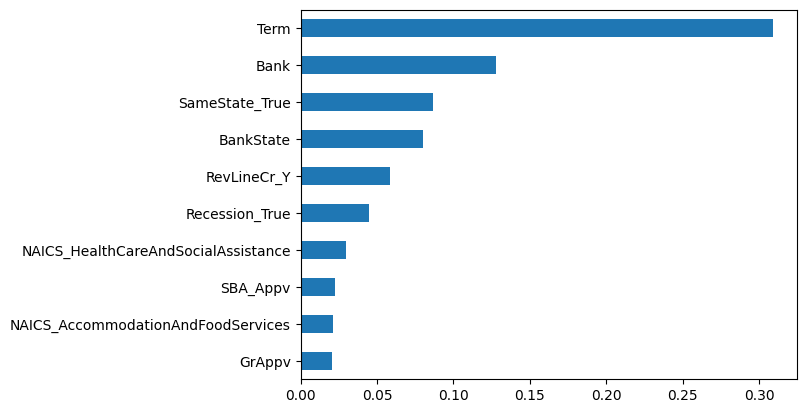

In [21]:
(pd.Series(model[-1].feature_importances_, index=X_train_tr.columns)
 .sort_values()
 .iloc[-10:]
 .plot.barh()
);

# SHAP

## Generate Shapley Values

### Explainer and Shapley Values DataFrame

In [22]:
shap.initjs()

Generating SHAP values can be **computationally intensive** and, hence, **quite long**.

So, beforehand, let's **estimate the size of the data**.

In [23]:
X_train_tr.shape

(332696, 38)

Let's estimate the corresponding time, in order to generate:
- The SHAP explainer
- The corresponding Shapley values

In [24]:
%%time
shap_explainer = shap.TreeExplainer(model[-1])
shap_ = shap_explainer(X_train_tr)

CPU times: user 9min 13s, sys: 606 ms, total: 9min 13s
Wall time: 1min 16s


The computing time is quite acceptable. Therefore, **we gave up the idea of working on a data subset**.

This will allow us to **get insights from the whole data we kept, in terms of prediction explain**.

Let's take a peek at what contains this `shap_` object.

In [25]:
shap_

.values =
array([[-9.3447559e-02, -1.2621087e-01, -2.7598706e-01, ...,
         1.3293008e+00,  3.7596658e-01,  7.6819159e-02],
       [-1.5692098e-01, -1.7698458e-01, -2.4065329e-04, ...,
         9.8585063e-01,  2.8182358e-02,  8.1417620e-02],
       [-2.8269285e-02,  2.9756024e-01, -1.0079618e-01, ...,
         1.1829206e+00, -3.6185730e-01, -1.2667267e-01],
       ...,
       [ 1.2277851e-02,  7.2210714e-02, -9.1788702e-02, ...,
         9.3492800e-01,  1.9167408e-01, -6.6415995e-02],
       [ 6.3860536e-02, -2.2900328e-01, -5.6230109e-03, ...,
         2.0746292e-01,  1.4153571e-01,  1.5977719e-01],
       [-1.2461307e-02,  4.0777496e-01, -7.5898685e-02, ...,
        -3.8274950e-01, -3.5688856e-01, -8.7036699e-02]], dtype=float32)

.base_values =
array([1.1821351, 1.1821351, 1.1821351, ..., 1.1821351, 1.1821351,
       1.1821351], dtype=float32)

.data =
array([[ 0.30031351, -0.28150129, -0.22373408, ...,  0.8853211 ,
         0.82734177,  0.75299923],
       [-0.39846993,  3.2778

In [26]:
# Get a peek at what Shapley values look like
# Even if it's rather "hermetic"
shap_values_df = pd.DataFrame(
    shap_.values,
    columns=X_train_tr.columns,
    index=X_train_tr.index
)
shap_values_df

,RetainedJob,SBA_Appv,NoEmp,GrAppv,Term,RevLineCr_Y,UrbanRural_U,SameState_True,NewExist_Y,Recession_True,...,NAICS_TransportationAndWarehousing,NAICS_Utilities,NAICS_WholesaleTrade,Region_Northeast,Region_Northwest,Region_Southeast,Region_Southwest,Bank,State,BankState
430053,-0.093448,-0.126211,-0.275987,0.142249,-4.663502,0.043530,0.049308,0.249612,0.055374,-0.290563,...,0.005703,0.0,-0.030665,0.020758,0.002177,-0.031026,-0.014694,1.329301,0.375967,0.076819
523084,-0.156921,-0.176985,-0.000241,-0.172265,-2.015371,-0.339059,0.057469,0.193275,0.089875,0.146828,...,0.001479,0.0,-0.009583,-0.032564,0.014747,0.021053,0.007942,0.985851,0.028182,0.081418
442311,-0.028269,0.297560,-0.100796,-0.020066,2.215174,0.046147,0.011903,-0.190986,-0.058287,0.250582,...,-0.007236,0.0,0.002490,0.146975,0.015235,-0.004524,0.009165,1.182921,-0.361857,-0.126673
17102,0.106446,0.590044,-0.002816,-0.197161,4.629996,-0.089402,0.039575,-0.124881,0.025174,0.269564,...,-0.001603,0.0,-0.004808,-0.044299,0.006497,-0.009820,-0.023814,-0.957634,0.114548,0.281876
565528,0.029645,0.078966,-0.182990,-0.224175,-4.632691,0.015949,0.009003,-0.337653,-0.050497,0.206873,...,0.006268,0.0,-0.016159,0.026405,-0.011075,-0.011037,0.017008,0.687397,-0.014502,-0.252219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109734,-0.014096,0.314051,-0.071375,-0.070271,4.229188,0.512196,0.021425,0.392359,0.007022,0.264771,...,-0.007206,0.0,-0.003078,0.014303,0.001663,0.002537,0.127027,-0.663813,-0.240982,-0.074693
179474,-0.030205,0.262747,-0.064671,-0.095440,4.426905,0.261391,-0.087307,-0.112149,-0.004878,0.320106,...,-0.004968,0.0,-0.000257,0.078988,0.014624,-0.004302,-0.024891,-0.610626,-0.058360,0.041126
215243,0.012278,0.072211,-0.091789,0.305413,-0.194144,-0.472788,-0.024723,-0.137487,-0.033722,-0.153294,...,-0.009873,0.0,-0.009587,-0.013391,0.033747,0.037754,-0.024432,0.934928,0.191674,-0.066416
471782,0.063861,-0.229003,-0.005623,0.140224,2.958610,-0.336011,0.016847,0.274968,0.098212,-0.352955,...,-0.017753,0.0,-0.013897,-0.017732,0.018695,0.003885,0.080155,0.207463,0.141536,0.159777


### Split Approved and Rejected Samples (into Series)

In [27]:
# Expected value for the Log-odds of the prediction
shap_explainer.expected_value

1.1821351

In [28]:
# Pandas Series for positive Log-odds
approved = (shap_values_df.sum(axis='columns') + shap_explainer.expected_value).pipe(lambda ser: ser[ser >= 0])
approved

523084    0.553087
442311    4.576084
17102     5.596459
325056    3.932640
635884    5.086433
            ...   
109734    5.896073
179474    5.422882
215243    1.349808
471782    4.189155
39448     6.025692
Length: 243645, dtype: float32

In [29]:
# Pandas Series for strictly negative Log-odds
rejected = (shap_values_df.sum(axis='columns') + shap_explainer.expected_value).pipe(lambda ser: ser[ser < 0])
rejected

430053   -1.963222
565528   -3.339440
379137   -2.142350
73866    -5.056176
693944   -0.374019
            ...   
6353     -1.941104
271374   -1.884964
233139   -8.237741
105118   -5.540112
253467   -4.154363
Length: 89051, dtype: float32

## Explaining One Prediction

### Linking Corresponding Values

This section's purpose is to **describe how to retrieve the SHAP values for one prediction** (involving `loc` and `iloc`), **then compare it with the corresponding transformed and original values**.

It's mainly pedagogical but will be useful to build a function to interpret one prediction at a time, this one being an approved or rejected one.

In [30]:
# SHAP values for 523084
shap_values_df.loc[523084]

RetainedJob                                                              -0.156921
SBA_Appv                                                                 -0.176985
NoEmp                                                                    -0.000241
GrAppv                                                                   -0.172265
Term                                                                     -2.015371
RevLineCr_Y                                                              -0.339059
UrbanRural_U                                                              0.057469
SameState_True                                                            0.193275
NewExist_Y                                                                0.089875
Recession_True                                                            0.146828
Franchise_Y                                                              -0.002135
NAICS_AccommodationAndFoodServices                                        0.055497
NAIC

In [31]:
# Corresponding transformed values
X_train_tr.loc[523084]

RetainedJob                                                              -0.398470
SBA_Appv                                                                  3.277805
NoEmp                                                                    -0.130903
GrAppv                                                                    3.578029
Term                                                                     -0.081525
RevLineCr_Y                                                               0.000000
UrbanRural_U                                                              0.000000
SameState_True                                                            1.000000
NewExist_Y                                                                0.000000
Recession_True                                                            0.000000
Franchise_Y                                                               0.000000
NAICS_AccommodationAndFoodServices                                        0.000000
NAIC

In [32]:
# Original values
X_train.loc[523084]

State                            TN
Region                    Southeast
Bank           FIRST VOLUNTEER BANK
BankState                        TN
SameState                      True
NAICS                   Information
Recession                     False
Term                             77
NewExist                          N
NoEmp                             4
RetainedJob                       0
Franchise                         N
UrbanRural                        R
RevLineCr                         N
GrAppv                    1100000.0
SBA_Appv                   825000.0
Name: 523084, dtype: object

In [33]:
X_train.index.get_loc(523084)

1

In [34]:
X_train_tr.iloc[1]

RetainedJob                                                              -0.398470
SBA_Appv                                                                  3.277805
NoEmp                                                                    -0.130903
GrAppv                                                                    3.578029
Term                                                                     -0.081525
RevLineCr_Y                                                               0.000000
UrbanRural_U                                                              0.000000
SameState_True                                                            1.000000
NewExist_Y                                                                0.000000
Recession_True                                                            0.000000
Franchise_Y                                                               0.000000
NAICS_AccommodationAndFoodServices                                        0.000000
NAIC

In [35]:
X_train.iloc[1]

State                            TN
Region                    Southeast
Bank           FIRST VOLUNTEER BANK
BankState                        TN
SameState                      True
NAICS                   Information
Recession                     False
Term                             77
NewExist                          N
NoEmp                             4
RetainedJob                       0
Franchise                         N
UrbanRural                        R
RevLineCr                         N
GrAppv                    1100000.0
SBA_Appv                   825000.0
Name: 523084, dtype: object

### Waterfall Plot Function

In [36]:
def draw_sample_waterfall_plot(kind: str) -> None:
    """
    - Display a random sample row application.
    - Draw a waterfall plot from a sample row.
    - Display the corresponding probability.
    Params
    ------
        kind (str) can either be:
        - "approved" for an approved application
        - "rejected" for a rejected application
    """
    if kind == "approved":
        cat = ((shap_values_df.sum(axis='columns') + shap_explainer.expected_value)
               .pipe(lambda ser: ser[ser >= 0])
              )
        idx = 1  # Index of the predict_proba numpy array
    elif kind == "rejected":
        cat = ((shap_values_df.sum(axis='columns') + shap_explainer.expected_value)
               .pipe(lambda ser: ser[ser < 0])
              )
        idx = 0  # Index of the predict_proba numpy array
    else:
        print(f"Expected 'approved' or 'rejected' for kind, got {kind}")
        return None
    pred_loc = cat.sample().index[0]
    pred_iloc = X_train.index.get_loc(pred_loc)
    print("===> RANDOM SAMPLE CHOSEN")
    print(X_train.iloc[pred_iloc])
    shap.plots.waterfall(shap_[pred_iloc])
    print("===> CORRESPONDING PROBABILITY")
    print(model.predict_proba(X_train.iloc[[pred_iloc]])[0][idx])

### For an Approved Prediction

===> RANDOM SAMPLE CHOSEN
State                                               TX
Region                                       Southwest
Bank                          CAPITAL CERT. DEVEL CORP
BankState                                           TX
SameState                                         True
NAICS          OtherServicesExceptPublicAdministration
Recession                                        False
Term                                               240
NewExist                                             N
NoEmp                                                5
RetainedJob                                          0
Franchise                                            Y
UrbanRural                                           U
RevLineCr                                            N
GrAppv                                        353000.0
SBA_Appv                                      353000.0
Name: 514300, dtype: object


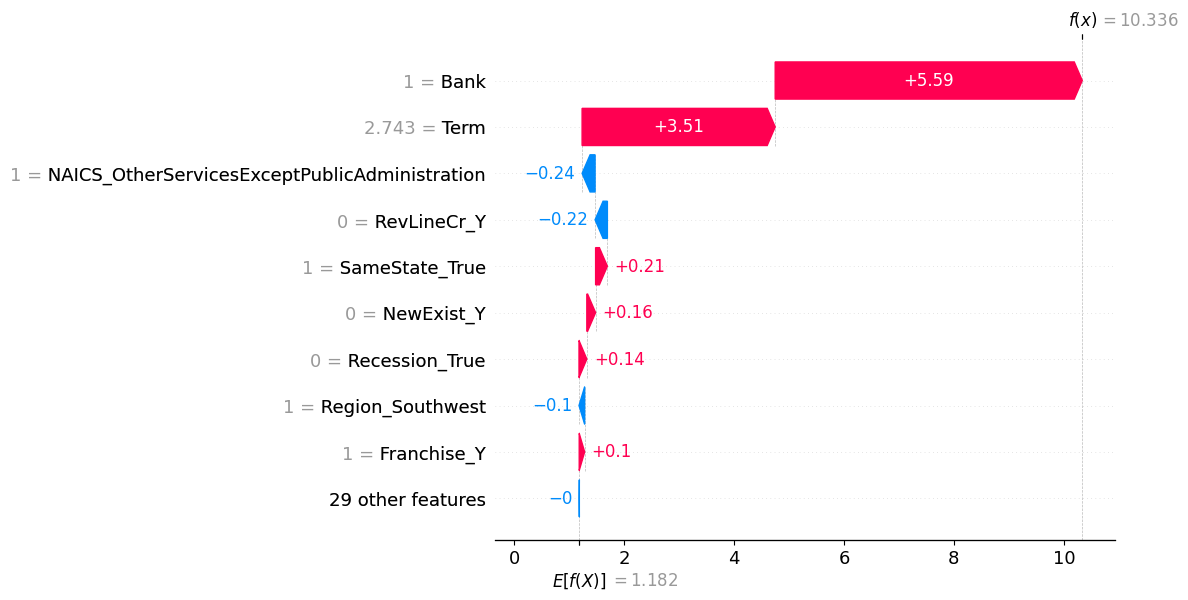

===> CORRESPONDING PROBABILITY
0.9999676


In [37]:
draw_sample_waterfall_plot("approved")

### For a Rejected Prediction

===> RANDOM SAMPLE CHOSEN
State                                     VA
Region                             Southeast
Bank              BANK OF AMERICA NATL ASSOC
BankState                                 NC
SameState                              False
NAICS          RealEstateAndRentalAndLeasing
Recession                               True
Term                                      65
NewExist                                   N
NoEmp                                      1
RetainedJob                                1
Franchise                                  N
UrbanRural                                 U
RevLineCr                                  N
GrAppv                               35000.0
SBA_Appv                             17500.0
Name: 193191, dtype: object


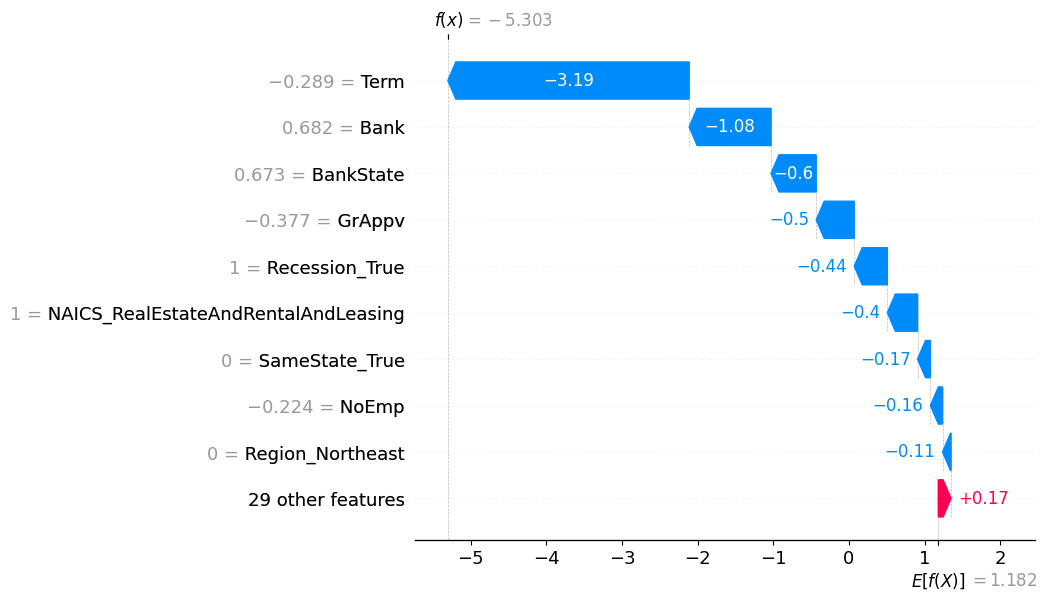

===> CORRESPONDING PROBABILITY
0.9950498


In [38]:
draw_sample_waterfall_plot("rejected")

## Explaing Variables: Dependence Plot

Trying to understand `Term`

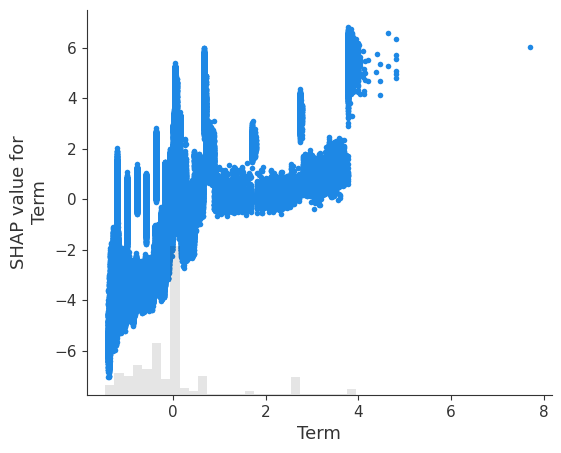

In [39]:
shap.plots.scatter(shap_[:, "Term"])

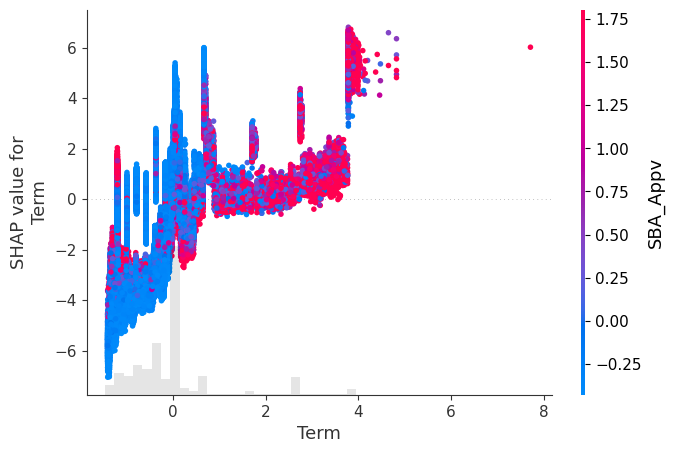

In [41]:
shap.plots.scatter(shap_[:, "Term"], color=shap_)

## Global View

### Absolute Mean SHAP

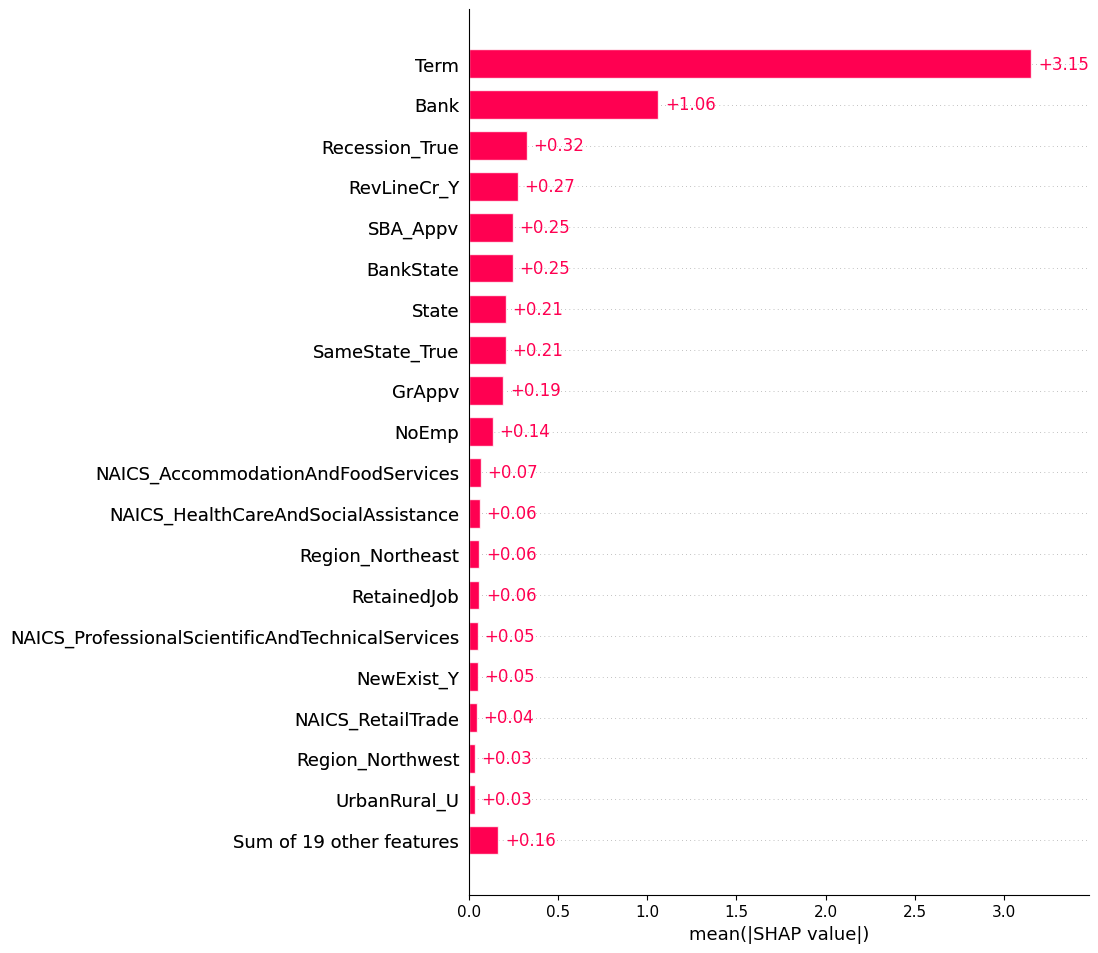

In [42]:
shap.plots.bar(shap_, max_display=20)

### Beeswarm

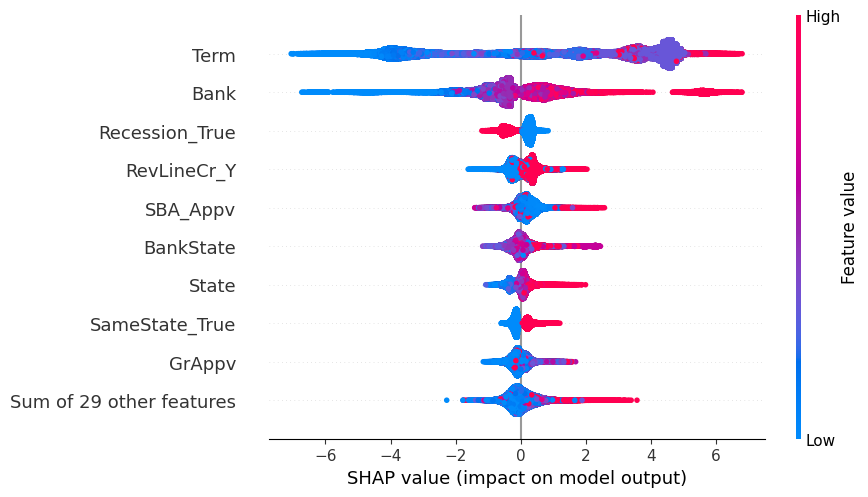

In [43]:
shap.plots.beeswarm(shap_)

## Explaining Prediction On New Data

This will be useful to **implement graph endpoint explaining prediction**

In [44]:
X_test.iloc[0]

State                                                  DC
Region                                          Northeast
Bank                                   PREMIER BANK, INC.
BankState                                              DC
SameState                                            True
NAICS          ProfessionalScientificAndTechnicalServices
Recession                                           False
Term                                                   60
NewExist                                                N
NoEmp                                                   8
RetainedJob                                             0
Franchise                                               N
UrbanRural                                              U
RevLineCr                                               N
GrAppv                                            77400.0
SBA_Appv                                          58050.0
Name: 820802, dtype: object

In [45]:
new_data = X_test.iloc[0].to_frame().T
new_data

,State,Region,Bank,BankState,SameState,NAICS,Recession,Term,NewExist,NoEmp,RetainedJob,Franchise,UrbanRural,RevLineCr,GrAppv,SBA_Appv
820802,DC,Northeast,"PREMIER BANK, INC.",DC,True,ProfessionalScientificAndTechnicalServices,False,60,N,8,0,N,U,N,77400.0,58050.0


In [46]:
new_data_tr = model[:-1].transform(new_data)
new_data_tr

,RetainedJob,SBA_Appv,NoEmp,GrAppv,Term,RevLineCr_Y,UrbanRural_U,SameState_True,NewExist_Y,Recession_True,...,NAICS_TransportationAndWarehousing,NAICS_Utilities,NAICS_WholesaleTrade,Region_Northeast,Region_Northwest,Region_Southeast,Region_Southwest,Bank,State,BankState
820802,-0.39847,-0.18862,-0.007128,-0.220018,-0.376092,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.860759,0.718543,0.842857


In [47]:
new_data_shap_ = shap_explainer(new_data_tr)
new_data_shap_

.values =
array([[-2.64308024e-02, -4.21485268e-02,  1.19945064e-01,
         9.27721523e-03,  1.88941169e+00, -3.66527215e-02,
         1.03065614e-02,  1.78365201e-01,  2.92184278e-02,
         2.22258106e-01, -3.95145826e-03,  4.25660871e-02,
        -6.31243177e-03, -1.32745330e-03,  5.10142744e-03,
        -3.41329747e-03,  8.01822636e-04,  8.68658535e-04,
        -2.15145182e-02, -7.80179491e-03,  0.00000000e+00,
        -8.03074520e-03, -2.42958241e-03,  1.29069835e-02,
         4.15806085e-01,  1.63781384e-04,  1.25146506e-03,
         1.54572306e-02, -7.18950201e-03,  0.00000000e+00,
        -3.70247802e-03,  5.64798266e-02,  3.05005051e-02,
        -2.21813982e-03, -1.30019067e-02,  8.37239206e-01,
         2.26052269e-01, -8.21736827e-03]], dtype=float32)

.base_values =
array([1.1821351], dtype=float32)

.data =
array([[-0.39846993, -0.18862035, -0.00712838, -0.22001763, -0.37609192,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.       

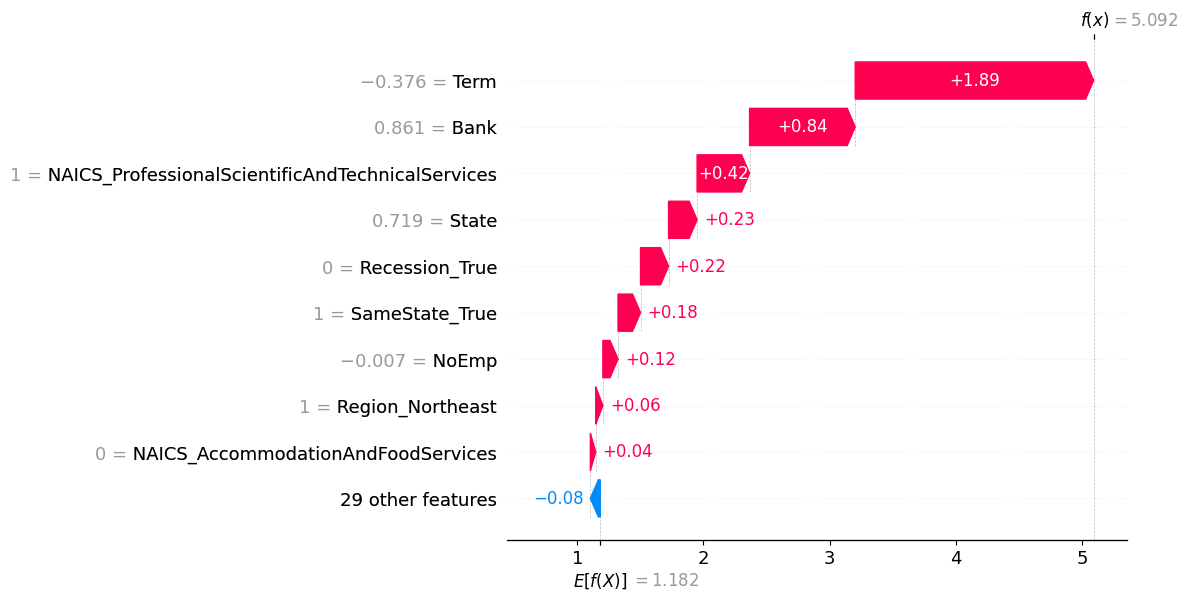

In [48]:
shap.plots.waterfall(new_data_shap_[0])

# Hyperparameter Tuning

## Optuna

We will use the Optuna library.

In [49]:
# def objective(trial):
#     # Define hyperparameter space
#     param = {
#         "verbosity": 0,
#         "objective": "binary:logistic",
#         "eval_metric": "logloss",
#         "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
#         "max_depth": trial.suggest_int("max_depth", 1, 50),
#         "max_delta_step": trial.suggest_int("max_delta_step", 0, 20),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100.0, log=True),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100.0, log=True),
#         "gamma": trial.suggest_float("gamma", 1e-9, 0.5, log=True),
#         "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-9, 500.0, log=True)
#     }
#     ######### MODEL #########
#     # Separating Features and Target
#     X = df_dropna.copy()
#     y = X.pop("MIS_Status")
    
#     # Hold-Out, stratifying with y by default
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                         test_size=0.05,
#                                                         stratify=y,
#                                                         random_state=42)
    
#     # Label Encoding Target
#     lab_enc = LabelEncoder()
#     y_train = lab_enc.fit_transform(y_train)
#     y_test = lab_enc.transform(y_test)
    
#     ##### MODEL #####
#     # Splitting Columns
#     num_cols = ["Term", "NoEmp", "CreateJob", "RetainedJob",
#                 "GrAppv", "SBA_Appv"]
    
#     cyc_cols = ["ApprovalMonth", "ApprovalDoW"]
    
#     bin_cols = ["SameState", "Recession", "NewExist", "Franchise", "LowDoc"]
    
#     nom_cols = ["Region", "NAICS", "UrbanRural", "RevLineCr"]
    
#     tgt_cols = [
#         # "City",
#         "Bank", "State", "BankState"
#     ]
    
#     # Instanciate Transformers
#     std_scl = StandardScaler()
#     cyc_dow = CyclicalEncoder("ApprovalDoW", 7)
#     cyc_mth = CyclicalEncoder("ApprovalMonth", 12)
#     ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
#                             sparse_output=False)
#     ohe_nom = OneHotEncoder(handle_unknown="ignore",
#                             sparse_output=False)
#     tgt_enc = TargetEncoder(smoothing=1.0)
    
#     # Build Pipeline
#     # Pipeline
#     preproc = ColumnTransformer(
#         transformers = [
#             ("num", std_scl, num_cols),
#             ("cyc_dow", cyc_dow, ["ApprovalDoW"]),
#             ("cyc_mth", cyc_mth, ["ApprovalMonth"]),
#             ("bin", ohe_bin, bin_cols),
#             ("nom", ohe_nom, nom_cols),
#             ("tgt", tgt_enc, tgt_cols)
#         ],
#         verbose_feature_names_out = False
#     )
#     # preproc.set_output(transform="pandas")
    
#     xgbc = xgb.XGBClassifier(random_state=42)
    
#     model = make_pipeline(preproc, xgbc)

#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     # Cross Validation
#     scores = cross_val_score(
#         model,
#         X_train, y_train,
#         cv=kfold,
#         scoring='f1_macro',
#         n_jobs=-1
#     )
#     return scores.mean()

In [50]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

In [51]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=200)

In [52]:
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

## Randomized Search CV

In [4]:
from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [5]:
X = df_short.copy().drop(columns=['City', 'CreateJob', 'LowDoc'])
y = X.pop("MIS_Status")

# Default stratify by y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

# Encode target
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.transform(y_test)

# Split kept columns
kept_set = set(X_train.columns)
num_cols = list({"Term", "NoEmp", "CreateJob", "RetainedJob", "GrAppv", "SBA_Appv"} & kept_set)
bin_cols = list({"SameState", "Recession", "NewExist", "Franchise",
                 "LowDoc", "UrbanRural", "RevLineCr"} & kept_set)
nom_cols = list({"Region", "NAICS"} & kept_set)
tgt_cols = list({"City", "Bank", "State", "BankState"} & kept_set)

# Instanciate transformers
std_scl = StandardScaler()
ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
                        sparse_output=False)
ohe_nom = OneHotEncoder(handle_unknown="ignore",
                        sparse_output=False)
tgt_enc = TargetEncoder(smoothing=1.0)

# Pipeline
## Preprocessing
preproc = ColumnTransformer(
transformers = [
    ("num", std_scl, num_cols),
    ("bin", ohe_bin, bin_cols),
    ("nom", ohe_nom, nom_cols),
    ("tgt", tgt_enc, tgt_cols)
],
verbose_feature_names_out = False
)
preproc.set_output(transform="pandas")
## Append estimator
xgbc = xgb.XGBClassifier(random_state=42)
model = make_pipeline(preproc, xgbc)

In [55]:
%%time
param_distributions = {
    "xgbclassifier__verbosity": [0],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__n_estimators": np.arange(500, 1_100, 100),
    "xgbclassifier__learning_rate": loguniform(0.01, 1.0),
    "xgbclassifier__max_depth": randint(1, 50),
    "xgbclassifier__max_delta_step": randint(0, 20),
    "xgbclassifier__subsample": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bytree": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bylevel": uniform(0.1, 1.0),
    "xgbclassifier__reg_lambda": loguniform(1e-9, 100.0),
    "xgbclassifier__reg_alpha": loguniform(1e-9, 100.0),
    "xgbclassifier__gamma": loguniform(1e-9, 0.5),
    "xgbclassifier__scale_pos_weight": loguniform(1e-9, 500.0)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=20,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_}\nBest Parameters: {random_search.best_params_}")


25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/martin/Documents/loan_

Best Score: 0.9577872915632535
Best Parameters: {'xgbclassifier__colsample_bylevel': 0.7947849330397045, 'xgbclassifier__colsample_bytree': 0.9804678390152577, 'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.0002699212875040098, 'xgbclassifier__learning_rate': 0.03901821268272623, 'xgbclassifier__max_delta_step': 5, 'xgbclassifier__max_depth': 28, 'xgbclassifier__n_estimators': 800, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 2.5283943395870274e-07, 'xgbclassifier__reg_lambda': 3.816009318638094e-05, 'xgbclassifier__scale_pos_weight': 21.55109069163411, 'xgbclassifier__subsample': 0.42434502100527394, 'xgbclassifier__verbosity': 0}
CPU times: user 4h 10min 12s, sys: 47.9 s, total: 4h 11min
Wall time: 36min 55s


In [6]:
%%time
param_distributions = {
    "xgbclassifier__verbosity": [0],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__n_estimators": np.arange(500, 1_100, 100),
    "xgbclassifier__learning_rate": loguniform(0.01, 1.0),
    "xgbclassifier__max_depth": randint(1, 50),
    "xgbclassifier__max_delta_step": randint(0, 20),
    "xgbclassifier__subsample": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bytree": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bylevel": uniform(0.1, 1.0),
    "xgbclassifier__reg_lambda": loguniform(1e-9, 100.0),
    "xgbclassifier__reg_alpha": loguniform(1e-9, 100.0),
    "xgbclassifier__gamma": loguniform(1e-9, 0.5),
    "xgbclassifier__scale_pos_weight": loguniform(1e-9, 500.0)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=300,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_}\nBest Parameters: {random_search.best_params_}")


460 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/martin/Documents/loa

Best Score: 0.9612198554551172
Best Parameters: {'xgbclassifier__colsample_bylevel': 0.658404249735805, 'xgbclassifier__colsample_bytree': 0.5242220092469763, 'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.07662131641546621, 'xgbclassifier__learning_rate': 0.016687641629195803, 'xgbclassifier__max_delta_step': 2, 'xgbclassifier__max_depth': 45, 'xgbclassifier__n_estimators': 900, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 2.8656487359664542e-05, 'xgbclassifier__reg_lambda': 0.0019328728119098468, 'xgbclassifier__scale_pos_weight': 0.46626302053599167, 'xgbclassifier__subsample': 0.8671948531085717, 'xgbclassifier__verbosity': 0}
CPU times: user 1d 6h 38min 6s, sys: 4min 9s, total: 1d 6h 42min 15s
Wall time: 4h 31min 26s


In [7]:
%%time
param_distributions = {
    "xgbclassifier__verbosity": [0],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__n_estimators": np.arange(500, 1_100, 100),
    "xgbclassifier__learning_rate": loguniform(0.01, 1.0),
    "xgbclassifier__max_depth": randint(1, 50),
    "xgbclassifier__max_delta_step": randint(0, 20),
    "xgbclassifier__subsample": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bytree": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bylevel": uniform(0.1, 1.0),
    "xgbclassifier__reg_lambda": loguniform(1e-9, 100.0),
    "xgbclassifier__reg_alpha": loguniform(1e-9, 100.0),
    "xgbclassifier__gamma": loguniform(1e-9, 0.5),
    "xgbclassifier__scale_pos_weight": loguniform(1e-9, 500.0)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=50,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_}\nBest Parameters: {random_search.best_params_}")


60 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/martin/Documents/loan_

Best Score: 0.9612198554551172
Best Parameters: {'xgbclassifier__colsample_bylevel': 0.658404249735805, 'xgbclassifier__colsample_bytree': 0.5242220092469763, 'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.07662131641546621, 'xgbclassifier__learning_rate': 0.016687641629195803, 'xgbclassifier__max_delta_step': 2, 'xgbclassifier__max_depth': 45, 'xgbclassifier__n_estimators': 900, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 2.8656487359664542e-05, 'xgbclassifier__reg_lambda': 0.0019328728119098468, 'xgbclassifier__scale_pos_weight': 0.46626302053599167, 'xgbclassifier__subsample': 0.8671948531085717, 'xgbclassifier__verbosity': 0}
CPU times: user 8h 39min 2s, sys: 1min 37s, total: 8h 40min 39s
Wall time: 1h 18min 6s


In [8]:
%%time
param_distributions = {
    "xgbclassifier__verbosity": [0],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__n_estimators": np.arange(500, 1_100, 100),
    "xgbclassifier__learning_rate": loguniform(0.01, 1.0),
    "xgbclassifier__max_depth": randint(1, 50),
    "xgbclassifier__max_delta_step": randint(0, 20),
    "xgbclassifier__subsample": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bytree": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bylevel": uniform(0.1, 1.0),
    "xgbclassifier__reg_lambda": loguniform(1e-9, 100.0),
    "xgbclassifier__reg_alpha": loguniform(1e-9, 100.0),
    "xgbclassifier__gamma": loguniform(1e-9, 0.5),
    "xgbclassifier__scale_pos_weight": loguniform(1e-9, 500.0)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=20,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_}\nBest Parameters: {random_search.best_params_}")


25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/martin/Documents/loan_

Best Score: 0.95778729065981
Best Parameters: {'xgbclassifier__colsample_bylevel': 0.7947849330397045, 'xgbclassifier__colsample_bytree': 0.9804678390152577, 'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.0002699212875040098, 'xgbclassifier__learning_rate': 0.03901821268272623, 'xgbclassifier__max_delta_step': 5, 'xgbclassifier__max_depth': 28, 'xgbclassifier__n_estimators': 800, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 2.5283943395870274e-07, 'xgbclassifier__reg_lambda': 3.816009318638094e-05, 'xgbclassifier__scale_pos_weight': 21.55109069163411, 'xgbclassifier__subsample': 0.42434502100527394, 'xgbclassifier__verbosity': 0}
CPU times: user 4h 29min 39s, sys: 56.3 s, total: 4h 30min 35s
Wall time: 40min 18s


In [56]:
%%time
param_distributions = {
    "xgbclassifier__verbosity": [0],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__eval_metric": ["logloss"],
    "xgbclassifier__n_estimators": np.arange(500, 1_100, 100),
    "xgbclassifier__learning_rate": loguniform(0.01, 1.0),
    "xgbclassifier__max_depth": randint(1, 50),
    "xgbclassifier__max_delta_step": randint(0, 20),
    "xgbclassifier__subsample": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bytree": uniform(0.1, 1.0),
    "xgbclassifier__colsample_bylevel": uniform(0.1, 1.0),
    "xgbclassifier__reg_lambda": loguniform(1e-9, 100.0),
    "xgbclassifier__reg_alpha": loguniform(1e-9, 100.0),
    "xgbclassifier__gamma": loguniform(1e-9, 0.5),
    "xgbclassifier__scale_pos_weight": loguniform(1e-9, 500.0)
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=20,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Score: {random_search.best_score_}\nBest Parameters: {random_search.best_params_}")


25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/martin/Documents/loan_approval/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/home/martin/Documents/loan_

Best Score: 0.9577872915632535
Best Parameters: {'xgbclassifier__colsample_bylevel': 0.7947849330397045, 'xgbclassifier__colsample_bytree': 0.9804678390152577, 'xgbclassifier__eval_metric': 'logloss', 'xgbclassifier__gamma': 0.0002699212875040098, 'xgbclassifier__learning_rate': 0.03901821268272623, 'xgbclassifier__max_delta_step': 5, 'xgbclassifier__max_depth': 28, 'xgbclassifier__n_estimators': 800, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 2.5283943395870274e-07, 'xgbclassifier__reg_lambda': 3.816009318638094e-05, 'xgbclassifier__scale_pos_weight': 21.55109069163411, 'xgbclassifier__subsample': 0.42434502100527394, 'xgbclassifier__verbosity': 0}
CPU times: user 4h 8min 56s, sys: 49.7 s, total: 4h 9min 46s
Wall time: 36min 39s


# Best Model's Characteristics

## Build & Score On Test Set ($F_1$ macro)

In [5]:
%%time
# LOAD DATAFRAME
df_short = pd.read_csv("../data/cleaned_df_short.csv", index_col=0)

# BUILD MODEL
COLS_TO_DROP = ['City', 'CreateJob', 'LowDoc'] 

X = df_short.copy().drop(columns=COLS_TO_DROP)
y = X.pop("MIS_Status")

# Default stratify by y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

# Encode target
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.transform(y_test)

# Split kept columns
kept_set = set(X_train.columns)
num_cols = list({"Term", "NoEmp", "CreateJob", "RetainedJob", "GrAppv", "SBA_Appv"} & kept_set)
bin_cols = list({"SameState", "Recession", "NewExist", "Franchise",
                 "LowDoc", "UrbanRural", "RevLineCr"} & kept_set)
nom_cols = list({"Region", "NAICS"} & kept_set)
tgt_cols = list({"City", "Bank", "State", "BankState"} & kept_set)

# Instanciate transformers
std_scl = StandardScaler()
ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
                        sparse_output=False)
ohe_nom = OneHotEncoder(handle_unknown="ignore",
                        sparse_output=False)
tgt_enc = TargetEncoder(smoothing=1.0)

# Pipeline
## Preprocessing
preproc = ColumnTransformer(
transformers = [
    ("num", std_scl, num_cols),
    ("bin", ohe_bin, bin_cols),
    ("nom", ohe_nom, nom_cols),
    ("tgt", tgt_enc, tgt_cols)
],
verbose_feature_names_out = False
)
preproc.set_output(transform="pandas")
## Append estimator
xgbc = xgb.XGBClassifier(random_state=42)
model = make_pipeline(preproc, xgbc)

# SET BEST HYPERPARAMETERS
best_params = {
    'xgbclassifier__colsample_bylevel': 0.5042897472548691, 
    'xgbclassifier__colsample_bytree': 0.6309376784120938,
    'xgbclassifier__eval_metric': 'logloss',
    'xgbclassifier__gamma': 0.00015032547632461585,
    'xgbclassifier__learning_rate': 0.01046761262328419,
    'xgbclassifier__max_delta_step': 10,
    'xgbclassifier__max_depth': 25,
    'xgbclassifier__n_estimators': 800,
    'xgbclassifier__objective': 'binary:logistic',
    'xgbclassifier__reg_alpha': 2.872268280704231e-09,
    'xgbclassifier__reg_lambda': 2.366591909619298e-05,
    'xgbclassifier__scale_pos_weight': 0.8283817065736674,
    'xgbclassifier__subsample': 0.554918889507587,
    'xgbclassifier__verbosity': 0
}

model.set_params(**best_params)

# TRAIN AND SCORE
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
raw_f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"{raw_f1_macro = :.4f}")

raw_f1_macro = 0.9545
CPU times: user 10min 9s, sys: 3.71 s, total: 10min 13s
Wall time: 1min 24s


## ROC Curve

In [28]:
def draw_ROC_curve(model, X, y_true) -> None:
    probas_test = model.predict_proba(X_test)
    # Computing False Positive Rates, True Positive Rates, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, probas_test[:, 1])
    roc_auc = auc(fpr, tpr)
    # Draw curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='lightseagreen', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)',
              size="x-large", weight="bold", c="b")
    plt.legend(loc="lower right")
    plt.grid(ls="--")
    plt.show()

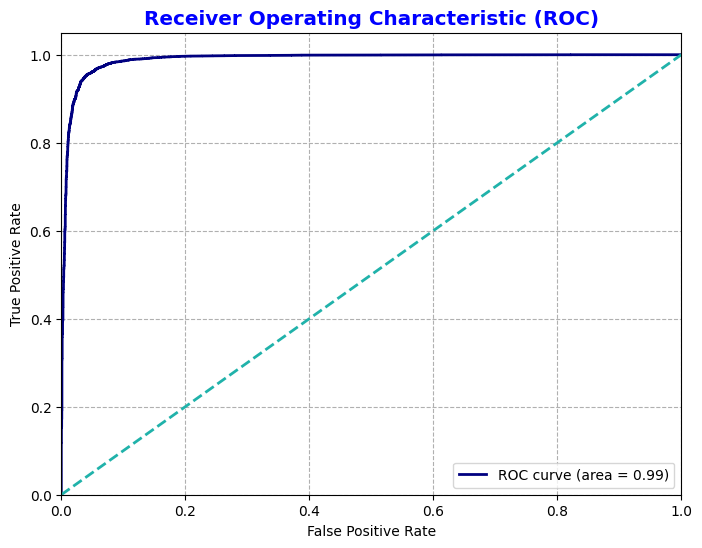

In [29]:
draw_ROC_curve(model, X_test, y_test)

## Confusion Matrix

### Display

In [21]:
def draw_confusion_matrix(clf, X, y_true) -> None:
    """Display a confusion matrix enhanced with a heatmap"""
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels = clf.classes_)
    disp.plot(cmap="Blues")
    
    plt.title("Confusion Matrix", size="x-large", weight="bold", c="b")
    plt.show()

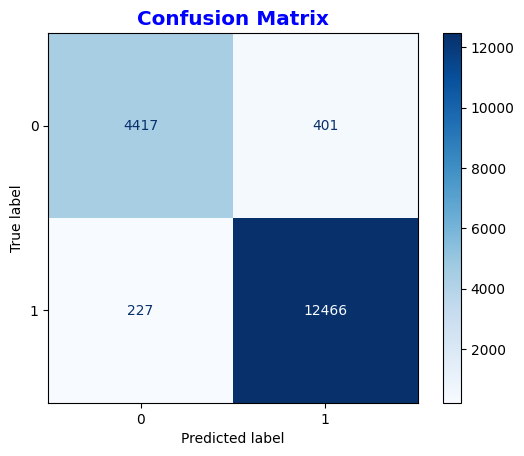

In [22]:
draw_confusion_matrix(model, X_test, y_test)

> **NOTE**
>
> As a remainder, here, the positive class (as chosen by Scikit-Learn) is 'P I F' and the negative class is therefore 'ChgOff'.

### Analysis

- There are 401 applications predicted as 1 (P I F) that were, in reality, 0 (ChgOff). Hence 401 **False Positives**
- There are 227 applications predicted as 0 (ChgOff) that were, in reality, 1 (P I F). Hence 227 **False Negatives**

In [34]:
TN = 4_417
TP = 12_466
FP = 401
FN = 227

recall = TP / (FN + TP)
precision = TP / (FP + TP)

In [37]:
round(recall * 100, 2)

98.21

In [38]:
round(precision * 100, 2)

96.88